# Fingerprint-based similarity scores

## Challenge
1. Many different fingerprints AND possible variations thereof (e.g. count/binary, log, weighted...) AND different metrics lead to **a lot** of possible variations!
2. No ground truth, so it is hard to measure what is good and what is better...

Data:

Compare multiple fingerprints on the "ms2 structures" dataset [Bushuiev 2024].

In [1]:
import os
from pathlib import Path
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

#from matchms.importing import load_from_mgf

ROOT = Path(os.getcwd()).parents[0]

path_data = os.path.join(Path(ROOT), "data")

In [2]:
filename = "compounds_unique_inchikey14.pickle"
compounds = pd.read_pickle(os.path.join(path_data, filename))
compounds.head()

inchikey                                              inchi  \
0  AAAQFGUYHFJNHI  InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...   
1  AABFWJDLCCDJJN  InChI=1S/C22H16N2O/c1-25-15-9-10-20-19(13-15)1...   
2  AABILZKQMVKFHP  InChI=1S/C21H33NO8/c1-7-13(2)18(23)30-16-9-11-...   
3  AABUHSBGEIUSRJ  InChI=1S/C17H16N2O2/c1-13(20)18-15-8-10-16(11-...   
4  AABUKWVVUWBZCS  InChI=1S/C21H14O3/c22-16-11-12-17-18(13-16)24-...   

                                              smiles             spectrum_id  
0  CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2c(ccc(OC)c2...                    None  
1          COc1cc2c(cc1)[nH]c1c2ccnc1-c1cccc2ccccc12                    None  
2  C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...  MSBNK-NaToxAq-NA003250  
3                 CC(O)=Nc1ccc(NC(=O)C=Cc2ccccc2)cc1      CCMSLIB00010107357  
4            O=c1oc2cc(O)ccc2c(-c2ccccc2)c1-c1ccccc1      CCMSLIB00010104862

In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator

def calculate_mass(smiles):
    # Convert SMILES string to a molecule object
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return "Invalid SMILES"
    # Calculate the molecular mass
    mass = Descriptors.MolWt(molecule)
    return mass

In [4]:
masses = []
for smiles_string in tqdm(compounds.smiles):
    masses.append(calculate_mass(smiles_string))

  0%|          | 0/37663 [00:00<?, ?it/s]

In [5]:
compounds["mass"] = masses
compounds.head()

inchikey                                              inchi  \
0  AAAQFGUYHFJNHI  InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...   
1  AABFWJDLCCDJJN  InChI=1S/C22H16N2O/c1-25-15-9-10-20-19(13-15)1...   
2  AABILZKQMVKFHP  InChI=1S/C21H33NO8/c1-7-13(2)18(23)30-16-9-11-...   
3  AABUHSBGEIUSRJ  InChI=1S/C17H16N2O2/c1-13(20)18-15-8-10-16(11-...   
4  AABUKWVVUWBZCS  InChI=1S/C21H14O3/c22-16-11-12-17-18(13-16)24-...   

                                              smiles             spectrum_id  \
0  CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2c(ccc(OC)c2...                    None   
1          COc1cc2c(cc1)[nH]c1c2ccnc1-c1cccc2ccccc12                    None   
2  C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...  MSBNK-NaToxAq-NA003250   
3                 CC(O)=Nc1ccc(NC(=O)C=Cc2ccccc2)cc1      CCMSLIB00010107357   
4            O=c1oc2cc(O)ccc2c(-c2ccccc2)c1-c1ccccc1      CCMSLIB00010104862   

      mass  
0  423.904  
1  324.383  
2  427.494  
3  280.327  
4  314.340

In [6]:
from utils import FingerprintGenerator #, fingerprint_from_smiles #, compute_all_fingerprints

In [7]:
import metrics


def compute_ruzicka_similarities(fingerprints):
    return metrics.ruzicka_similarity_matrix(fingerprints, fingerprints)

def compute_ruzicka_similarities_weighted(fingerprints, weights):
    return metrics.ruzicka_similarity_matrix_weighted(fingerprints, fingerprints, weights)

def compute_ruzicka_similarities_log(fingerprints):
    return metrics.ruzicka_similarity_matrix(np.log(1 + fingerprints), np.log(1 + fingerprints))

def compute_jaccard_similarities(fingerprints):
    return metrics.jaccard_similarity_matrix(fingerprints, fingerprints)

def compute_jaccard_similarities_weighted(fingerprints, weights):
    return metrics.jaccard_similarity_matrix_weighted(fingerprints, fingerprints, weights)

In [8]:
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem


def compute_fingerprints(fpgen, count):
    fp_generator = FingerprintGenerator(fpgen)
    
    fingerprints = []
    for inchikey, row in tqdm(compounds.iterrows(), total=len(compounds)):
        fp = fp_generator.fingerprint_from_smiles(row.smiles, count)
        if fp is None:
            print(f"Missing fingerprint for {inchikey}: {row.smiles}")
        else:
            fingerprints.append(fp)
    return np.vstack(fingerprints)  

In [9]:
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem

fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096)
count = False

fingerprints_classic = compute_fingerprints(fpgen, count)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [10]:
compounds.shape[0]

37663

In [11]:
#NUM_FINGERPRINTS = 10_000

#rng = np.random.default_rng(seed=0)
#indices_selected = rng.choice(np.arange(len(compounds.shape[0])), NUM_FINGERPRINTS, replace=False)

In [9]:
#or: USE ALL!
indices_selected = np.arange(compounds.shape[0])

In [13]:
fingerprints_selected = fingerprints_classic[indices_selected]
fingerprints_selected.shape

(37663, 4096)

In [14]:
%%time

similarities_classic = compute_jaccard_similarities(fingerprints_selected)

CPU times: user 3min 55s, sys: 1min 18s, total: 5min 13s
Wall time: 15.2 s


In [15]:
similarities_classic.shape

(37663, 37663)

In [23]:
similarities_classic[:5, :5]

array([[1.        , 0.16414265, 0.22535211, 0.09383833, 0.1648299 ],
       [0.16414265, 1.        , 0.14056017, 0.07103825, 0.20114942],
       [0.22535211, 0.14056017, 1.        , 0.07820197, 0.14409369],
       [0.09383833, 0.07103825, 0.07820197, 1.        , 0.07368421],
       [0.1648299 , 0.20114942, 0.14409369, 0.07368421, 1.        ]],
      dtype=float32)

In [25]:
similarities_classic = similarities_classic.astype(np.float16)

In [18]:
# too big! --> 5 GB !!
np.save("similarities_tanimoto_rdkit_4096bits.npy", similarities_classic)

In [10]:
similarities_classic = np.load("similarities_tanimoto_rdkit_4096bits.npy")

In [ ]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)
fingerprints_morgan3_count = compute_fingerprints(fpgen, True)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [16]:
%%time

similarities_morgan3_count = compute_ruzicka_similarities(fingerprints_morgan3_count)

CPU times: user 1h 13min 32s, sys: 7.83 s, total: 1h 13min 40s
Wall time: 2min 33s


In [19]:
# too big! --> 5 GB !!
np.save("similarities_ruzicka_morgan3_4096bits.npy", similarities_morgan3_count)

In [9]:
similarities_morgan3_count = np.load("similarities_ruzicka_morgan3_4096bits.npy")

In [26]:
similarities_morgan3_count = similarities_morgan3_count.astype(np.float16)

In [17]:
similarities_morgan3_count.shape

(37663, 37663)

## Morgan-3 binary + Tanimoto

In [61]:
fingerprints_morgan3 = compute_fingerprints(fpgen, count=False)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [62]:
%%time

similarities_morgan3 = compute_jaccard_similarities(fingerprints_morgan3)

CPU times: user 4min 18s, sys: 1min 18s, total: 5min 37s
Wall time: 15.8 s


In [63]:
# too big! --> 5 GB !!
np.save("similarities_tanimoto_morgan3_4096bits.npy", similarities_morgan3)

In [11]:
similarities_morgan3 = np.load("similarities_tanimoto_morgan3_4096bits.npy")

## Morgan-2 count

In [22]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096)

#fingerprints_morgan2_count = compute_fingerprints(fpgen, count=True)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [23]:
%%time

#similarities_morgan2_count = compute_ruzicka_similarities(fingerprints_morgan2_count)

CPU times: user 1h 9min 20s, sys: 7.33 s, total: 1h 9min 27s
Wall time: 2min 27s


## Morgan-6 count

In [65]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=4096)

fingerprints_morgan6_count = compute_fingerprints(fpgen, count=True)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [66]:
%%time

similarities_morgan6_count = compute_ruzicka_similarities(fingerprints_morgan6_count)

CPU times: user 1h 8min 57s, sys: 8.09 s, total: 1h 9min 5s
Wall time: 2min 28s


In [69]:
# too big! --> 5 GB !!
np.save("similarities_ruzicka_morgan6_4096bits.npy", similarities_morgan6_count)

## Morgan-9 count

In [67]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096)

fingerprints_morgan9_count = compute_fingerprints(fpgen, count=True)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [68]:
%%time

similarities_morgan9_count = compute_ruzicka_similarities(fingerprints_morgan9_count)

CPU times: user 1h 9min 36s, sys: 8.68 s, total: 1h 9min 45s
Wall time: 2min 28s


In [70]:
# too big! --> 5 GB !!
np.save("similarities_ruzicka_morgan9_4096bits.npy", similarities_morgan9_count)

## MAP4

In [76]:
from typing import List
from rdkit.Chem import Mol, MolFromSmiles # pylint: disable=import-error,no-name-in-module
from map4 import MAP4


map4 = MAP4(
    dimensions=4096,
    radius=2,
    include_duplicated_shingles=False,
)

molecules: List[Mol] = [MolFromSmiles(smiles) for smiles in tqdm(compounds.smiles.values)]
fingerprints_map4: np.ndarray = map4.calculate_many(
    molecules,
    number_of_threads=32,
    verbose=True,
)

  0%|          | 0/37663 [00:00<?, ?it/s]

Calculating fingerprints:   0%|                       | 0/37663 [00:00<?, ?it/s]

In [77]:
fingerprints_map4.shape

(37663, 4096)

In [78]:
%%time

similarities_map4 = compute_jaccard_similarities(fingerprints_map4)

CPU times: user 4min 14s, sys: 1min 18s, total: 5min 33s
Wall time: 15.7 s


In [31]:
similarities_count_morgan3[:10, :5]

NameError: name 'similarities_count_morgan3' is not defined

In [ ]:
similarities_count_morgan6[:10, :5]

In [12]:
#from utils import remove_diagonal

def remove_diagonal(A):
    m = A.shape[0]
    strided = np.lib.stride_tricks.as_strided
    s0,s1 = A.strides
    return strided(A.ravel()[1:], shape=(m-1,m), strides=(s0+s1,s1)).reshape(m,-1)



def compare_distributions(
    similarities1,
    similarities2,
    label1,
    label2,
    title="",
    ignore_diagonal=True
):
    if ignore_diagonal:
        similarities1 = remove_diagonal(similarities1)
        similarities2 = remove_diagonal(similarities2)

    fig, ax = plt.subplots(1, figsize=(8, 5))
    ax.hist(similarities1.reshape(-1),
                    bins=50, rwidth=0.8, alpha=0.5, label=label1)
    ax.hist(similarities2.reshape(-1),
                    bins=50, rwidth=0.8, alpha=0.5, label=label2)
    ax.set_title(title)
    ax.set_xlabel("Tanimoto(-like) score")
    ax.set_ylabel("Score counts")
    
    ax.set_yscale("log")
    ax.set_yscale("log")
    plt.legend()
    plt.show()

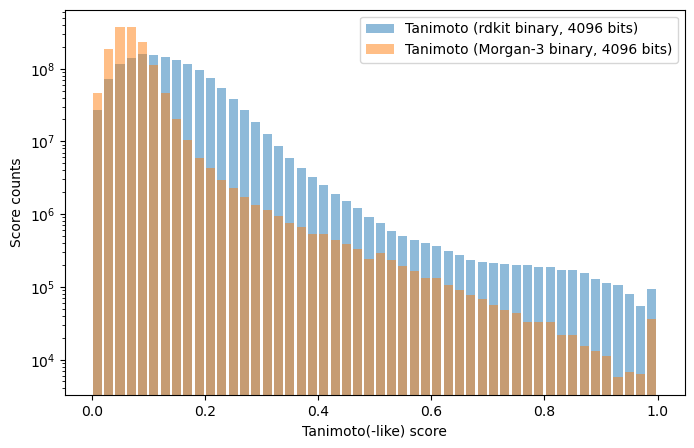

In [13]:
NBITS = 4096

compare_distributions(
    similarities_classic,
    similarities_morgan3,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Tanimoto (Morgan-3 binary, {NBITS} bits)",
    ignore_diagonal=True,
)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata

def scale_to_match_distribution(reference, target):
    """
    Scales the target similarity scores to match the distribution of the reference similarity scores.
    
    Parameters:
    - reference: np.ndarray, the reference similarity scores.
    - target: np.ndarray, the target similarity scores to be scaled.
    
    Returns:
    - scaled_target: np.ndarray, the scaled similarity scores.
    """
    shape_original = target.shape
    
    # Flatten arrays and sort reference
    reference = reference.flatten()
    target = target.flatten()
    
    # Sort reference and target, get their quantiles
    reference_sorted = np.sort(reference)
    target_ranks = rankdata(target, method='ordinal')
    
    # Map target quantiles to reference quantiles
    scaled_target = reference_sorted[target_ranks - 1]
    
    return scaled_target.reshape(shape_original)

In [15]:
# Example usage with your compare_distributions function
scaled_similarities_morgan3 = scale_to_match_distribution(similarities_classic, similarities_morgan3)

In [18]:
# scaled_similarities_morgan3 = scaled_similarities_morgan3.reshape(similarities_classic.shape)

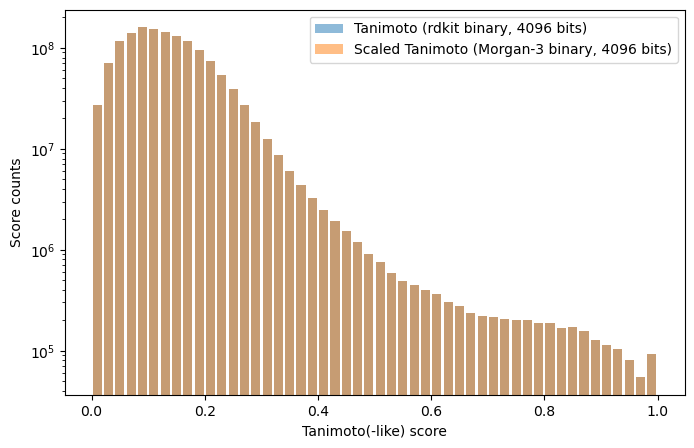

In [19]:
NBITS = 4096

compare_distributions(
    similarities_classic,
    scaled_similarities_morgan3,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Scaled Tanimoto (Morgan-3 binary, {NBITS} bits)",
    ignore_diagonal=True,
)

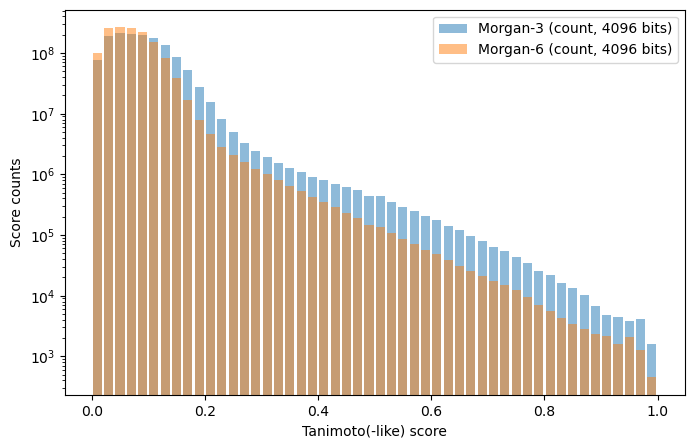

In [26]:
NBITS = 4096

compare_distributions(similarities_morgan3_count,
                      similarities_morgan6_count,
                      f"Morgan-3 (count, {NBITS} bits)",
                      f"Morgan-6 (count, {NBITS} bits)",
)

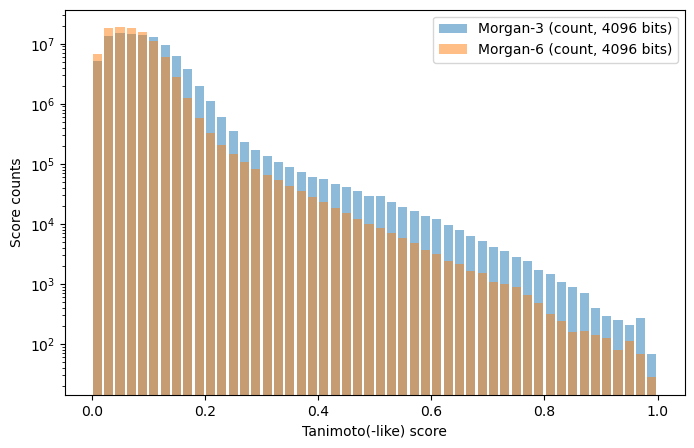

In [23]:
NBITS = 4096

compare_distributions(similarities_count_morgan3,
                      similarities_count_morgan6,
                      f"Morgan-3 (count, {NBITS} bits)",
                      f"Morgan-6 (count, {NBITS} bits)",
)

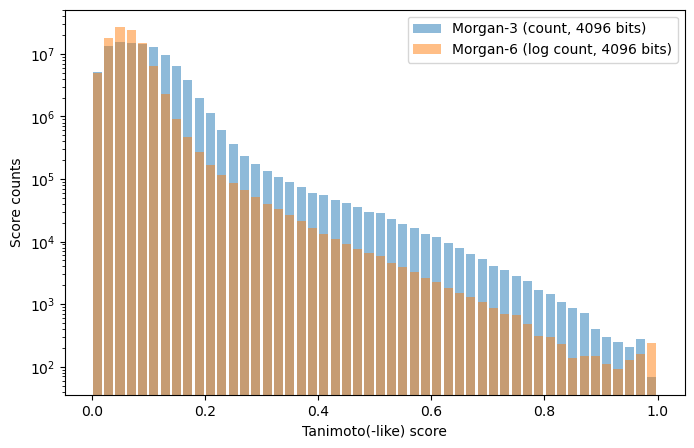

In [83]:
NBITS = 4096

compare_distributions(similarities_count_morgan3,
                      similarities_count_morgan6_log,
                      f"Morgan-3 (count, {NBITS} bits)",
                      f"Morgan-6 (log count, {NBITS} bits)",
)

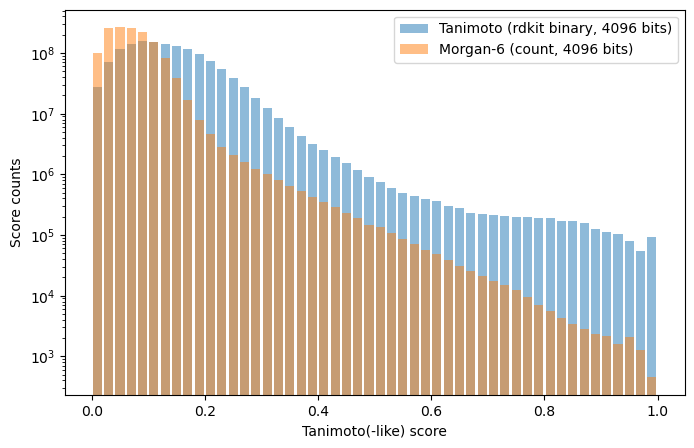

In [29]:
NBITS = 4096

compare_distributions(similarities_classic,
                      similarities_count_morgan6,
                      f"Tanimoto (rdkit binary, {NBITS} bits)",
                      f"Morgan-6 (count, {NBITS} bits)",
)

In [60]:
idx0.shape[0], idx1.shape[0]

(5280, 20714)

In [71]:
log_positions

array([  1.        ,   1.66810054,   2.7825594 ,   4.64158883,
         7.74263683,  12.91549665,  21.5443469 ,  35.93813664,
        59.94842503, 100.        ])

8578 8525


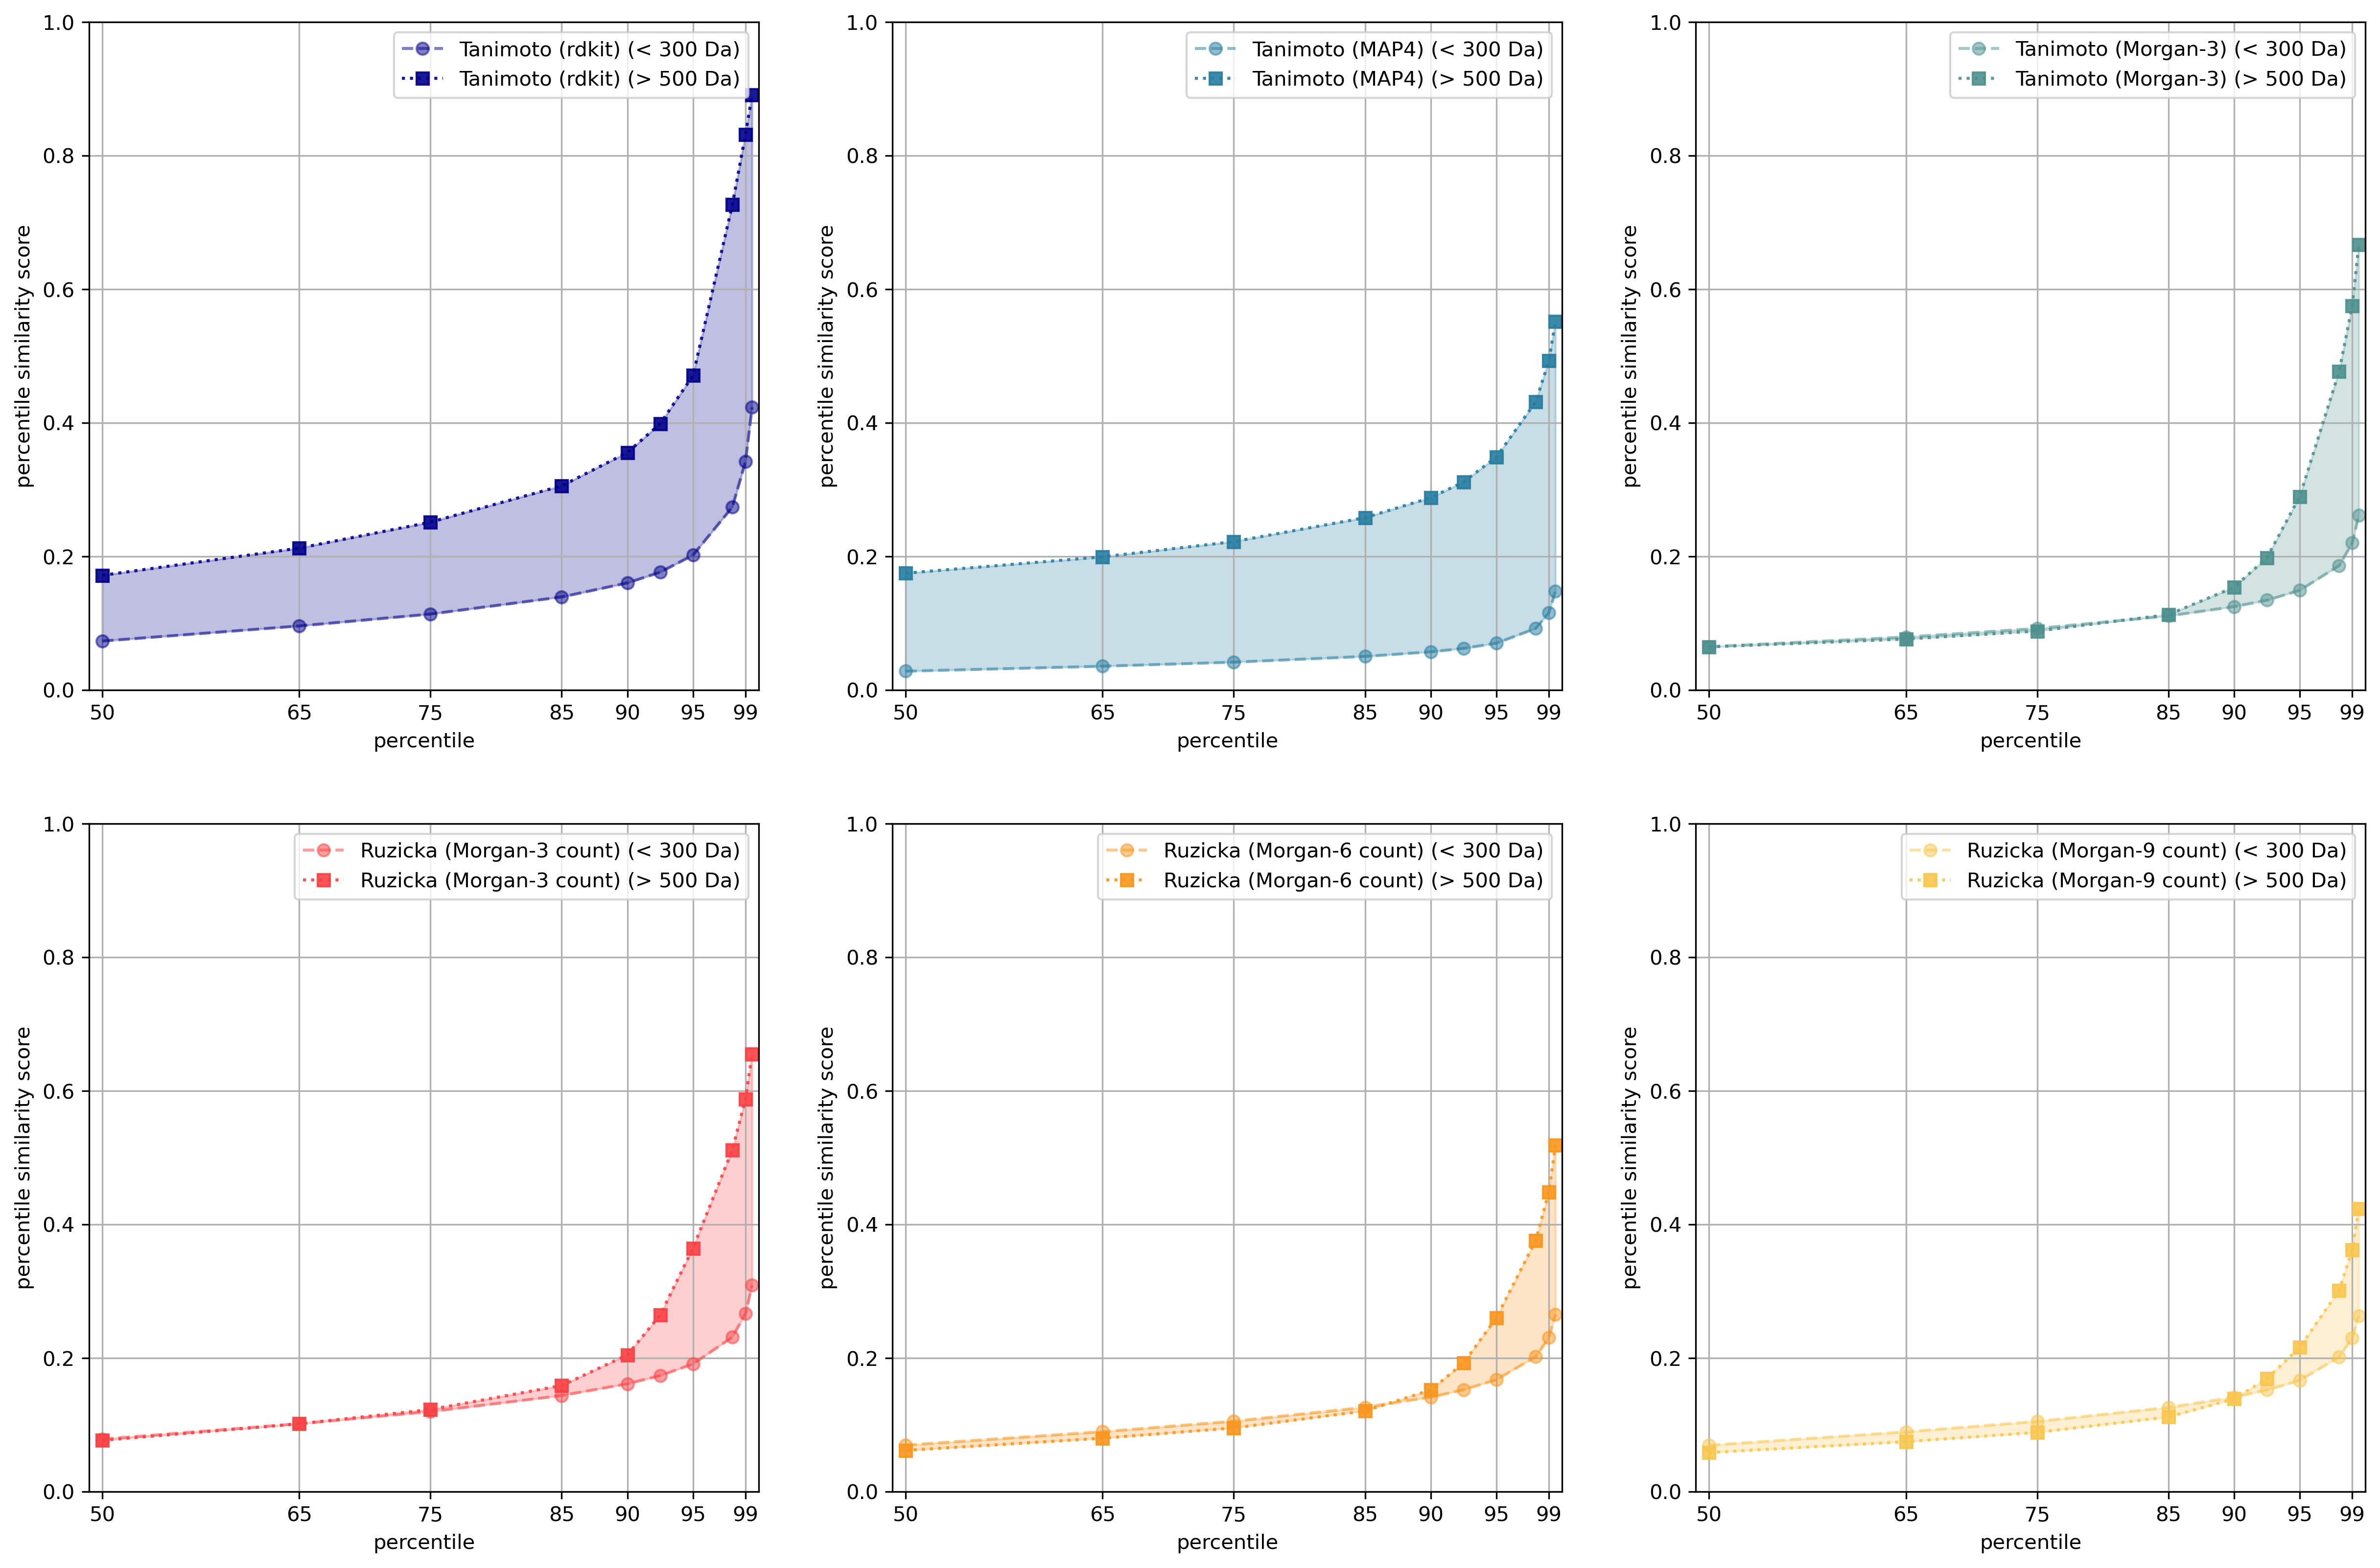

In [54]:
#percentiles = np.arange(0, 101)
percentiles = [50, 65, 75, 85, 90, 92.5, 95, 98, 99, 99.5] #, 99.9]
percentiles_ticks = [50, 65, 75, 85, 90, 95, 99]

mass_low = 300
mass_high = 500

idx1 = np.where(compounds.mass[indices_selected] > mass_high)[0]
idx0 = np.where(compounds.mass[indices_selected] < mass_low)[0]
print(idx0.shape[0], idx1.shape[0])

similarities_dict = {
    "Tanimoto (rdkit)": similarities_classic,
    "Tanimoto (MAP4)": similarities_map4,
    "Tanimoto (Morgan-3)": similarities_morgan3,
    #"Ruzicka (Morgan-2 count, 4096 bits)": similarities_morgan2_count,
    "Ruzicka (Morgan-3 count)": similarities_morgan3_count,
    "Ruzicka (Morgan-6 count)": similarities_morgan6_count,
    "Ruzicka (Morgan-9 count)": similarities_morgan9_count,
}

# Compare selected percentiles
fig, axes = plt.subplots(2, 3, figsize=(20, 13), dpi=300)


#colors = ["darkblue", "dodgerblue", "teal", "darkred", "crimson", "orange"]
colors = ["darkblue", "#277DA1", "#4D908E", "#F94144", "#F8961E", "#F9C74F"]

curves =  {key: {} for key, _ in similarities_dict.items()}

coords = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

for i, (key, similarities) in enumerate(similarities_dict.items()):
    percentile_scores = np.percentile(similarities[np.ix_(idx0, idx0)].reshape(-1), percentiles)
    curves[key][mass_low] = percentile_scores
    axes[coords[i]].plot(percentiles, percentile_scores, ".--", markersize=12, label=key+f" (< {mass_low} Da)", color=colors[i], alpha=0.5)

    percentile_scores = np.percentile(similarities[np.ix_(idx1, idx1)].reshape(-1), percentiles)
    curves[key][mass_high] = percentile_scores
    axes[coords[i]].plot(percentiles, percentile_scores, "s:", markersize=6, label=key+f" (> {mass_high} Da)", color=colors[i],  alpha=0.9)

for i, (key, similarities) in enumerate(similarities_dict.items()):
    axes[coords[i]].fill_between(percentiles, curves[key][mass_low], curves[key][mass_high], color=colors[i], alpha=0.25)

    axes[coords[i]].set_xticks(percentiles_ticks, [str(x) for x in percentiles_ticks])
    axes[coords[i]].grid(True)
    axes[coords[i]].set_xlabel("percentile")
    axes[coords[i]].set_ylabel("percentile similarity score")
    axes[coords[i]].set_ylim(0, 1)
    axes[coords[i]].set_xlim(49, 100)
    axes[coords[i]].legend()

plt.tight_layout()
plt.savefig("fig_low_high_mass_score_percentiles.pdf")
plt.savefig("fig_low_high_mass_score_percentiles.png", dpi=400)
plt.show()

# Score vs Score comparisons

This was previously done using hexbin plots, which look nice, but fail for too large data due to matplotlib caused memory inefficiency (required > 120GB RAM).

So now using heatmap plots.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def heatmap_comparison(similarities1, similarities2, label1, label2, bins=100, filename=None):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    
    # Compute the 2D histogram
    hist, x_edges, y_edges = np.histogram2d(
        similarities1.ravel(), 
        similarities2.ravel(), 
        bins=bins
    )
    
    # Display the heatmap using imshow with logarithmic color scale
    im = ax.imshow(hist.T, origin='lower', aspect='equal',
                   extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                   cmap='viridis', norm=LogNorm(vmin=1, vmax=np.max(hist)))
    
    # Add colorbar with proper tick formatting
    cb = fig.colorbar(im, ax=ax)
    #tick_values = np.logspace(0, np.log10(np.max(hist)), num=10)
    #cb.set_ticks(tick_values)
    #cb.set_ticklabels([f"{int(t):,}" for t in tick_values])  # Rounded integer labels
    cb.set_label('Count')
    
    # Add grid and labels
    ax.grid(True, zorder=1)
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()


## Tanimoto (rdkit) vs Tanimoto (Morgan-3)

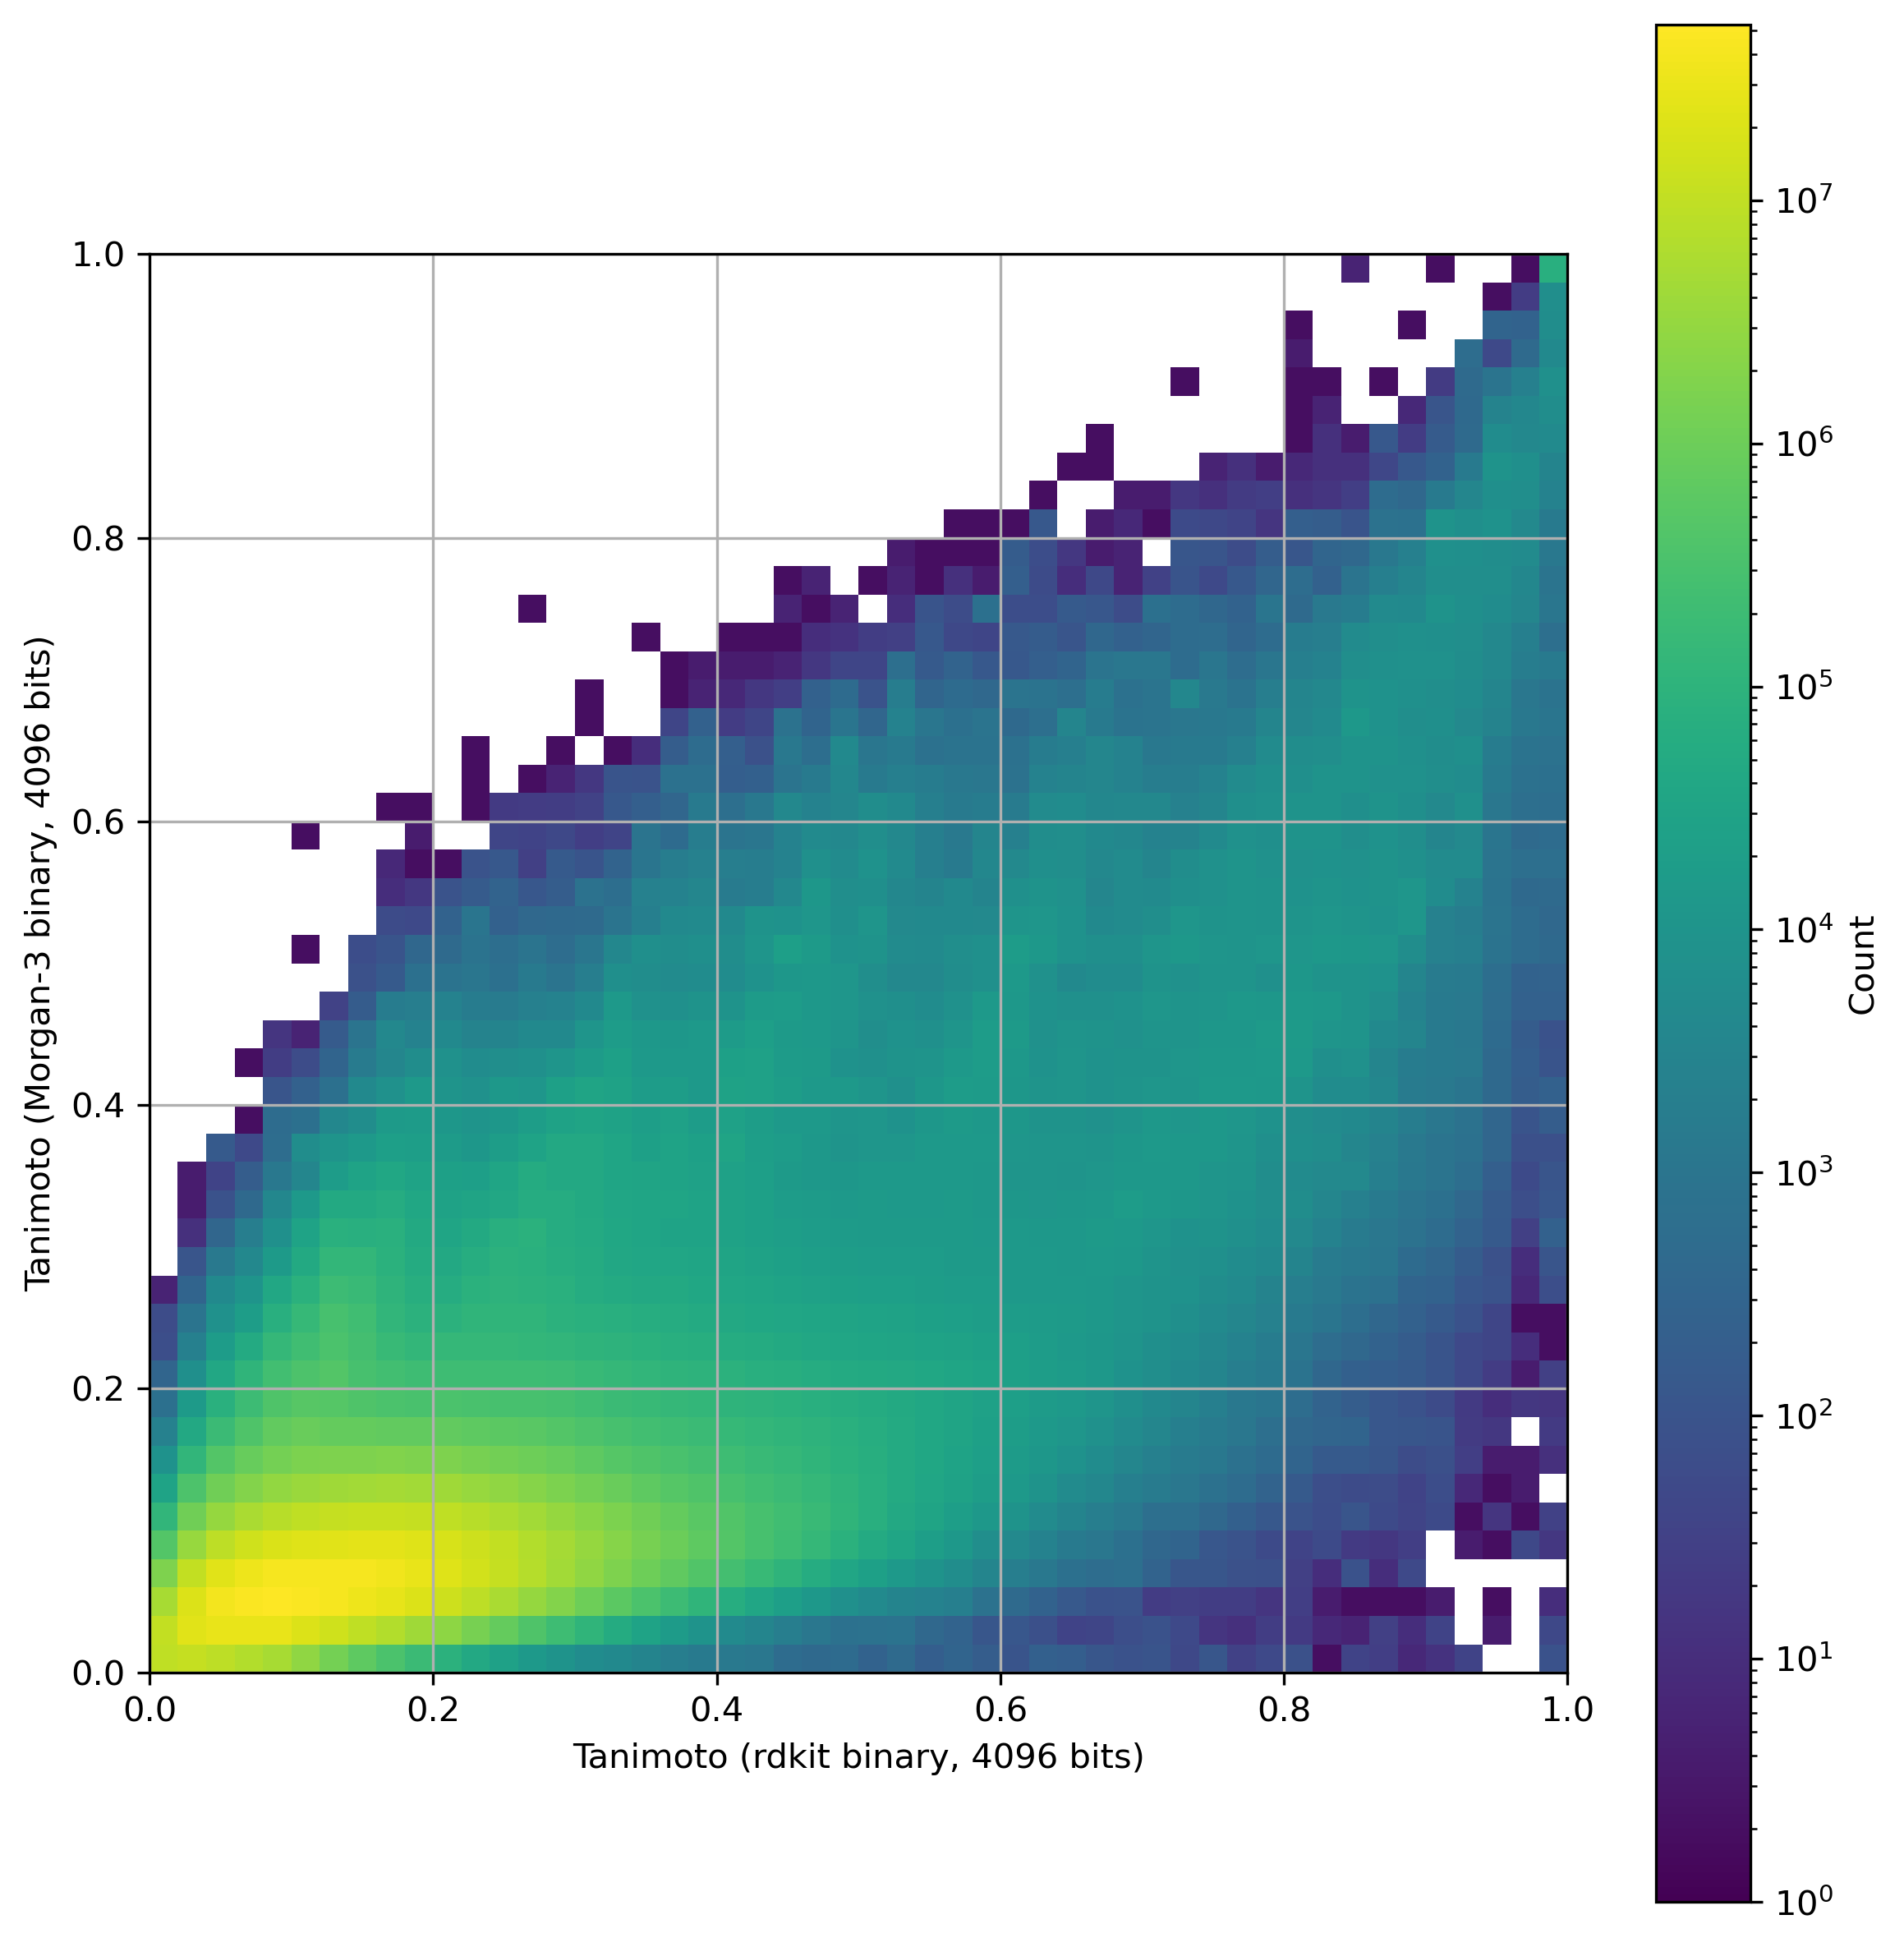

In [64]:
heatmap_comparison(
    similarities_classic,
    similarities_morgan3,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Tanimoto (Morgan-3 binary, {NBITS} bits)",
    bins=50,
    filename="heatmap_tanimoto_rdkit_vs_tanimoto_morgan3.png"
)

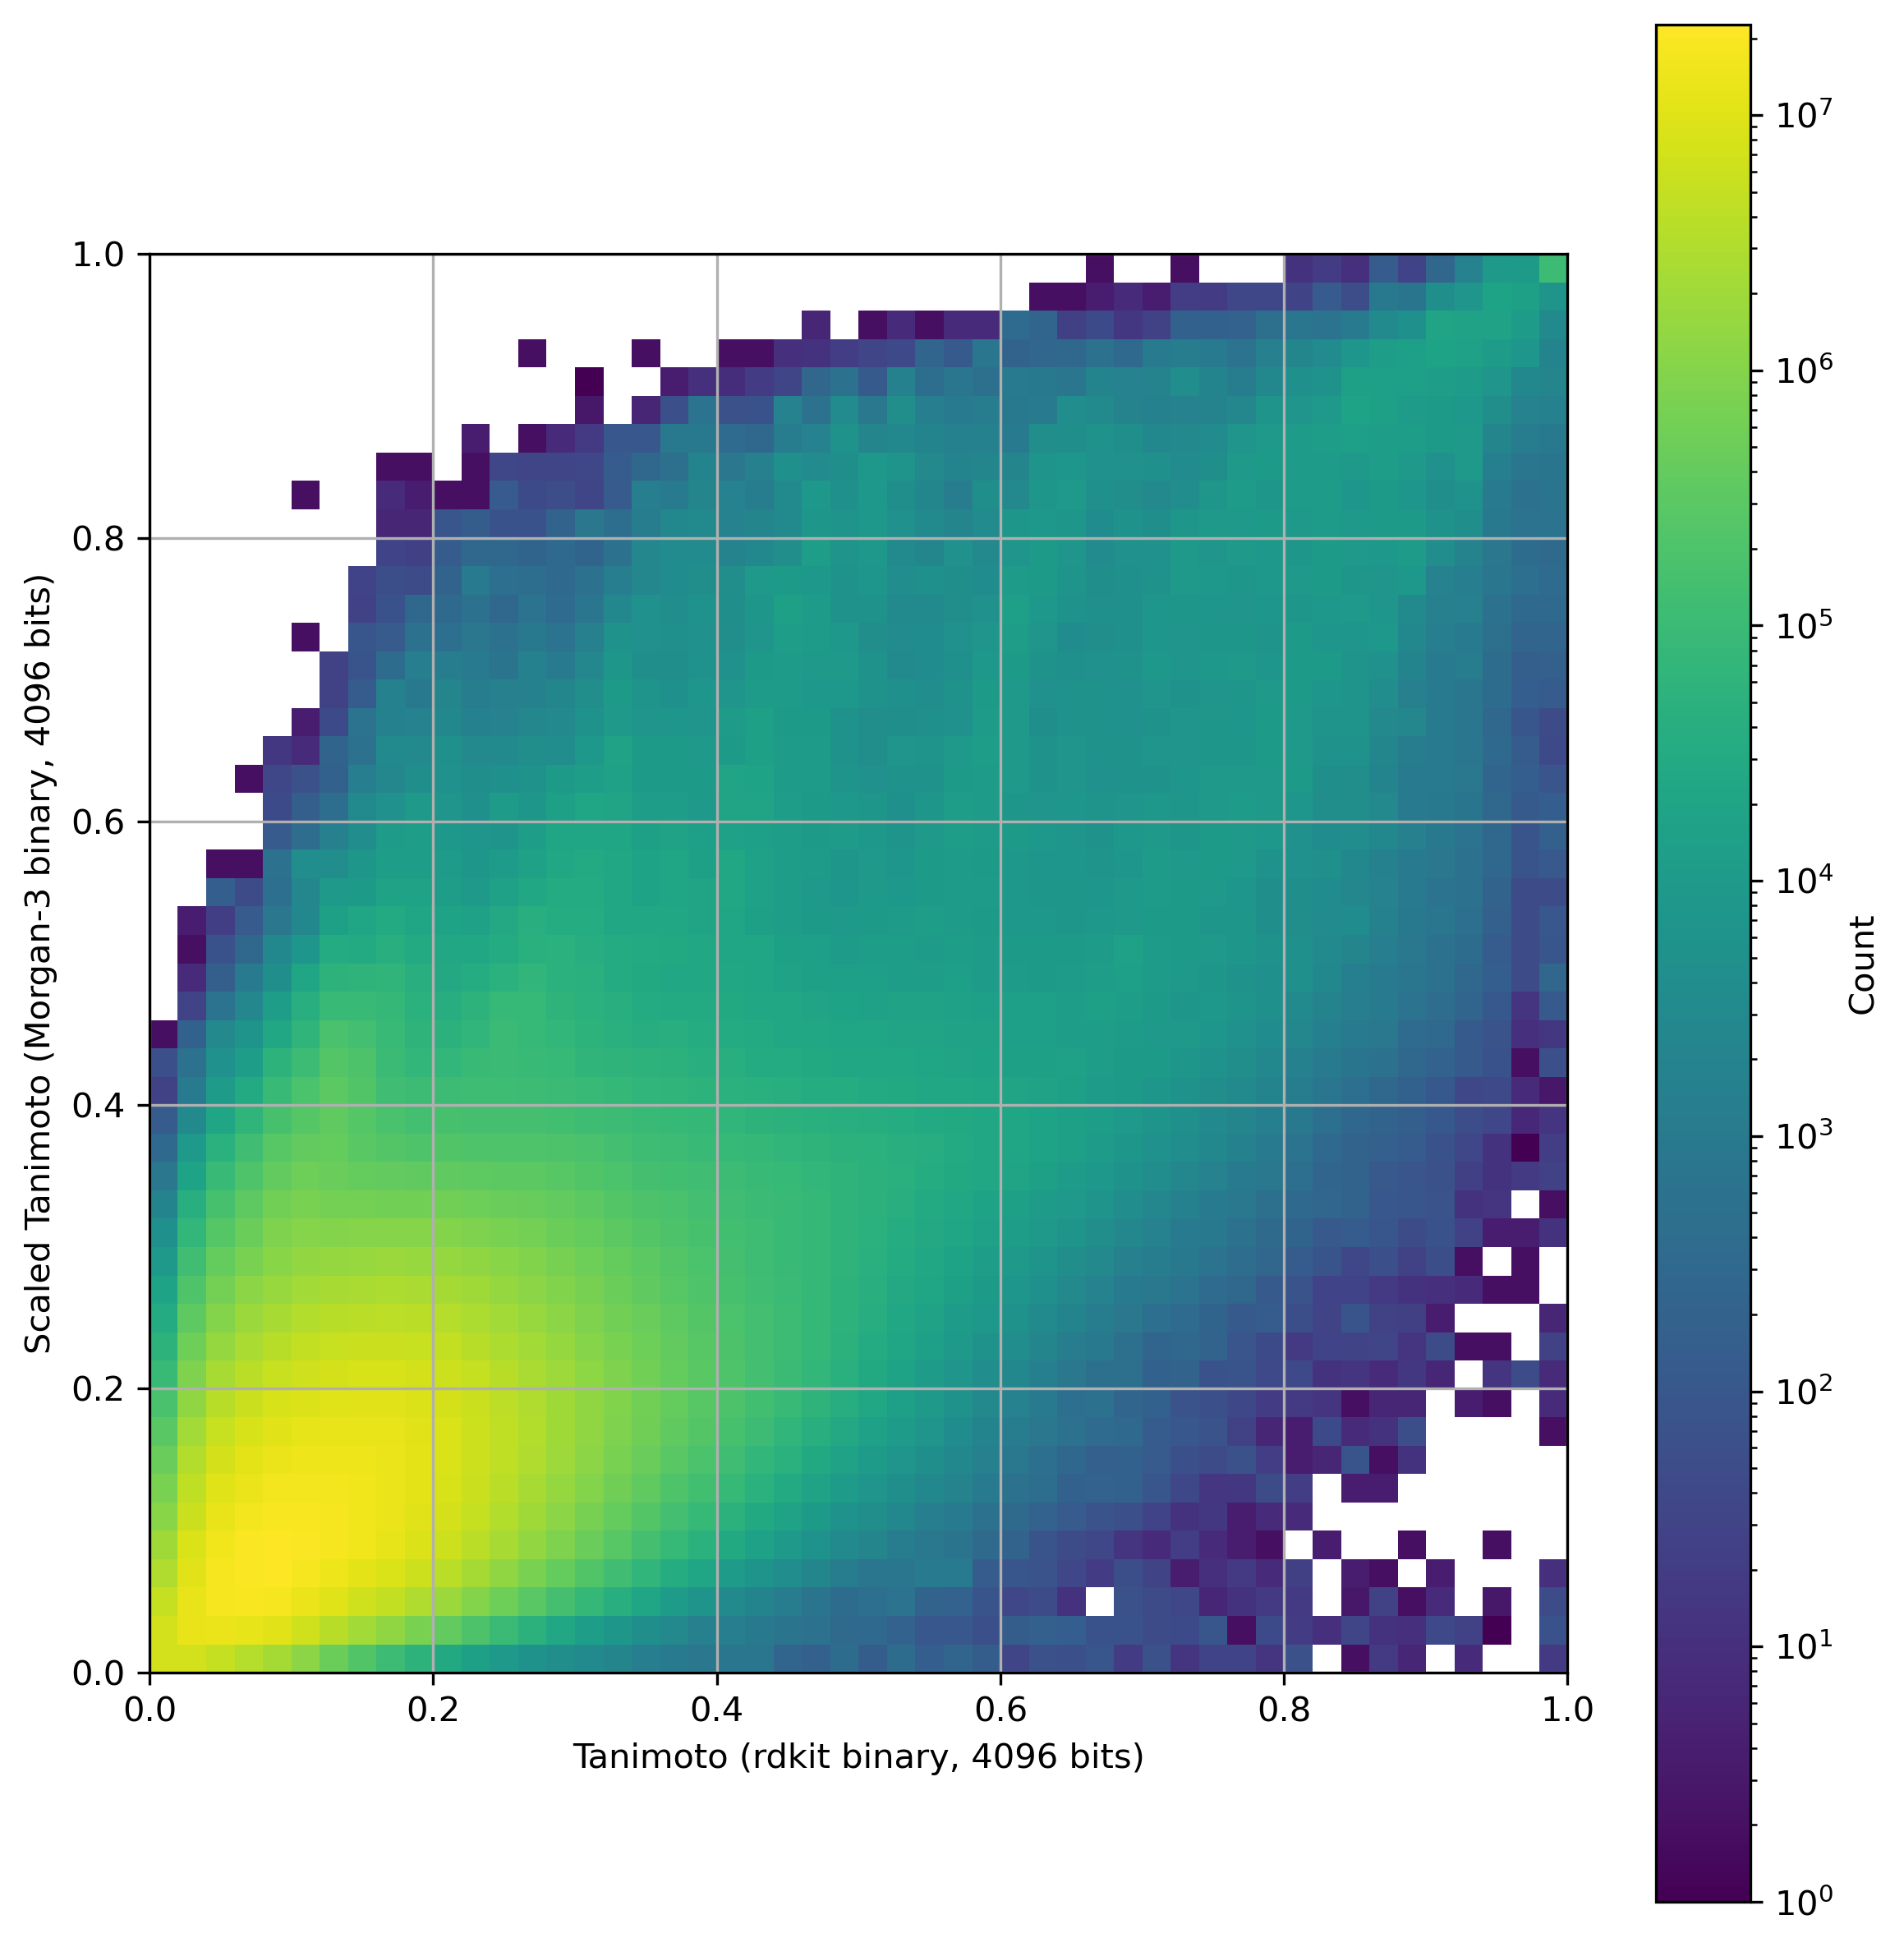

In [21]:
heatmap_comparison(
    similarities_classic,
    scaled_similarities_morgan3,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Scaled Tanimoto (Morgan-3 binary, {NBITS} bits)",
    bins=50,
    filename="heatmap_tanimoto_rdkit_vs_scaled_tanimoto_morgan3.png"
)

## Tanimoto (rdkit) vs Ruzicka (Morgan-3)

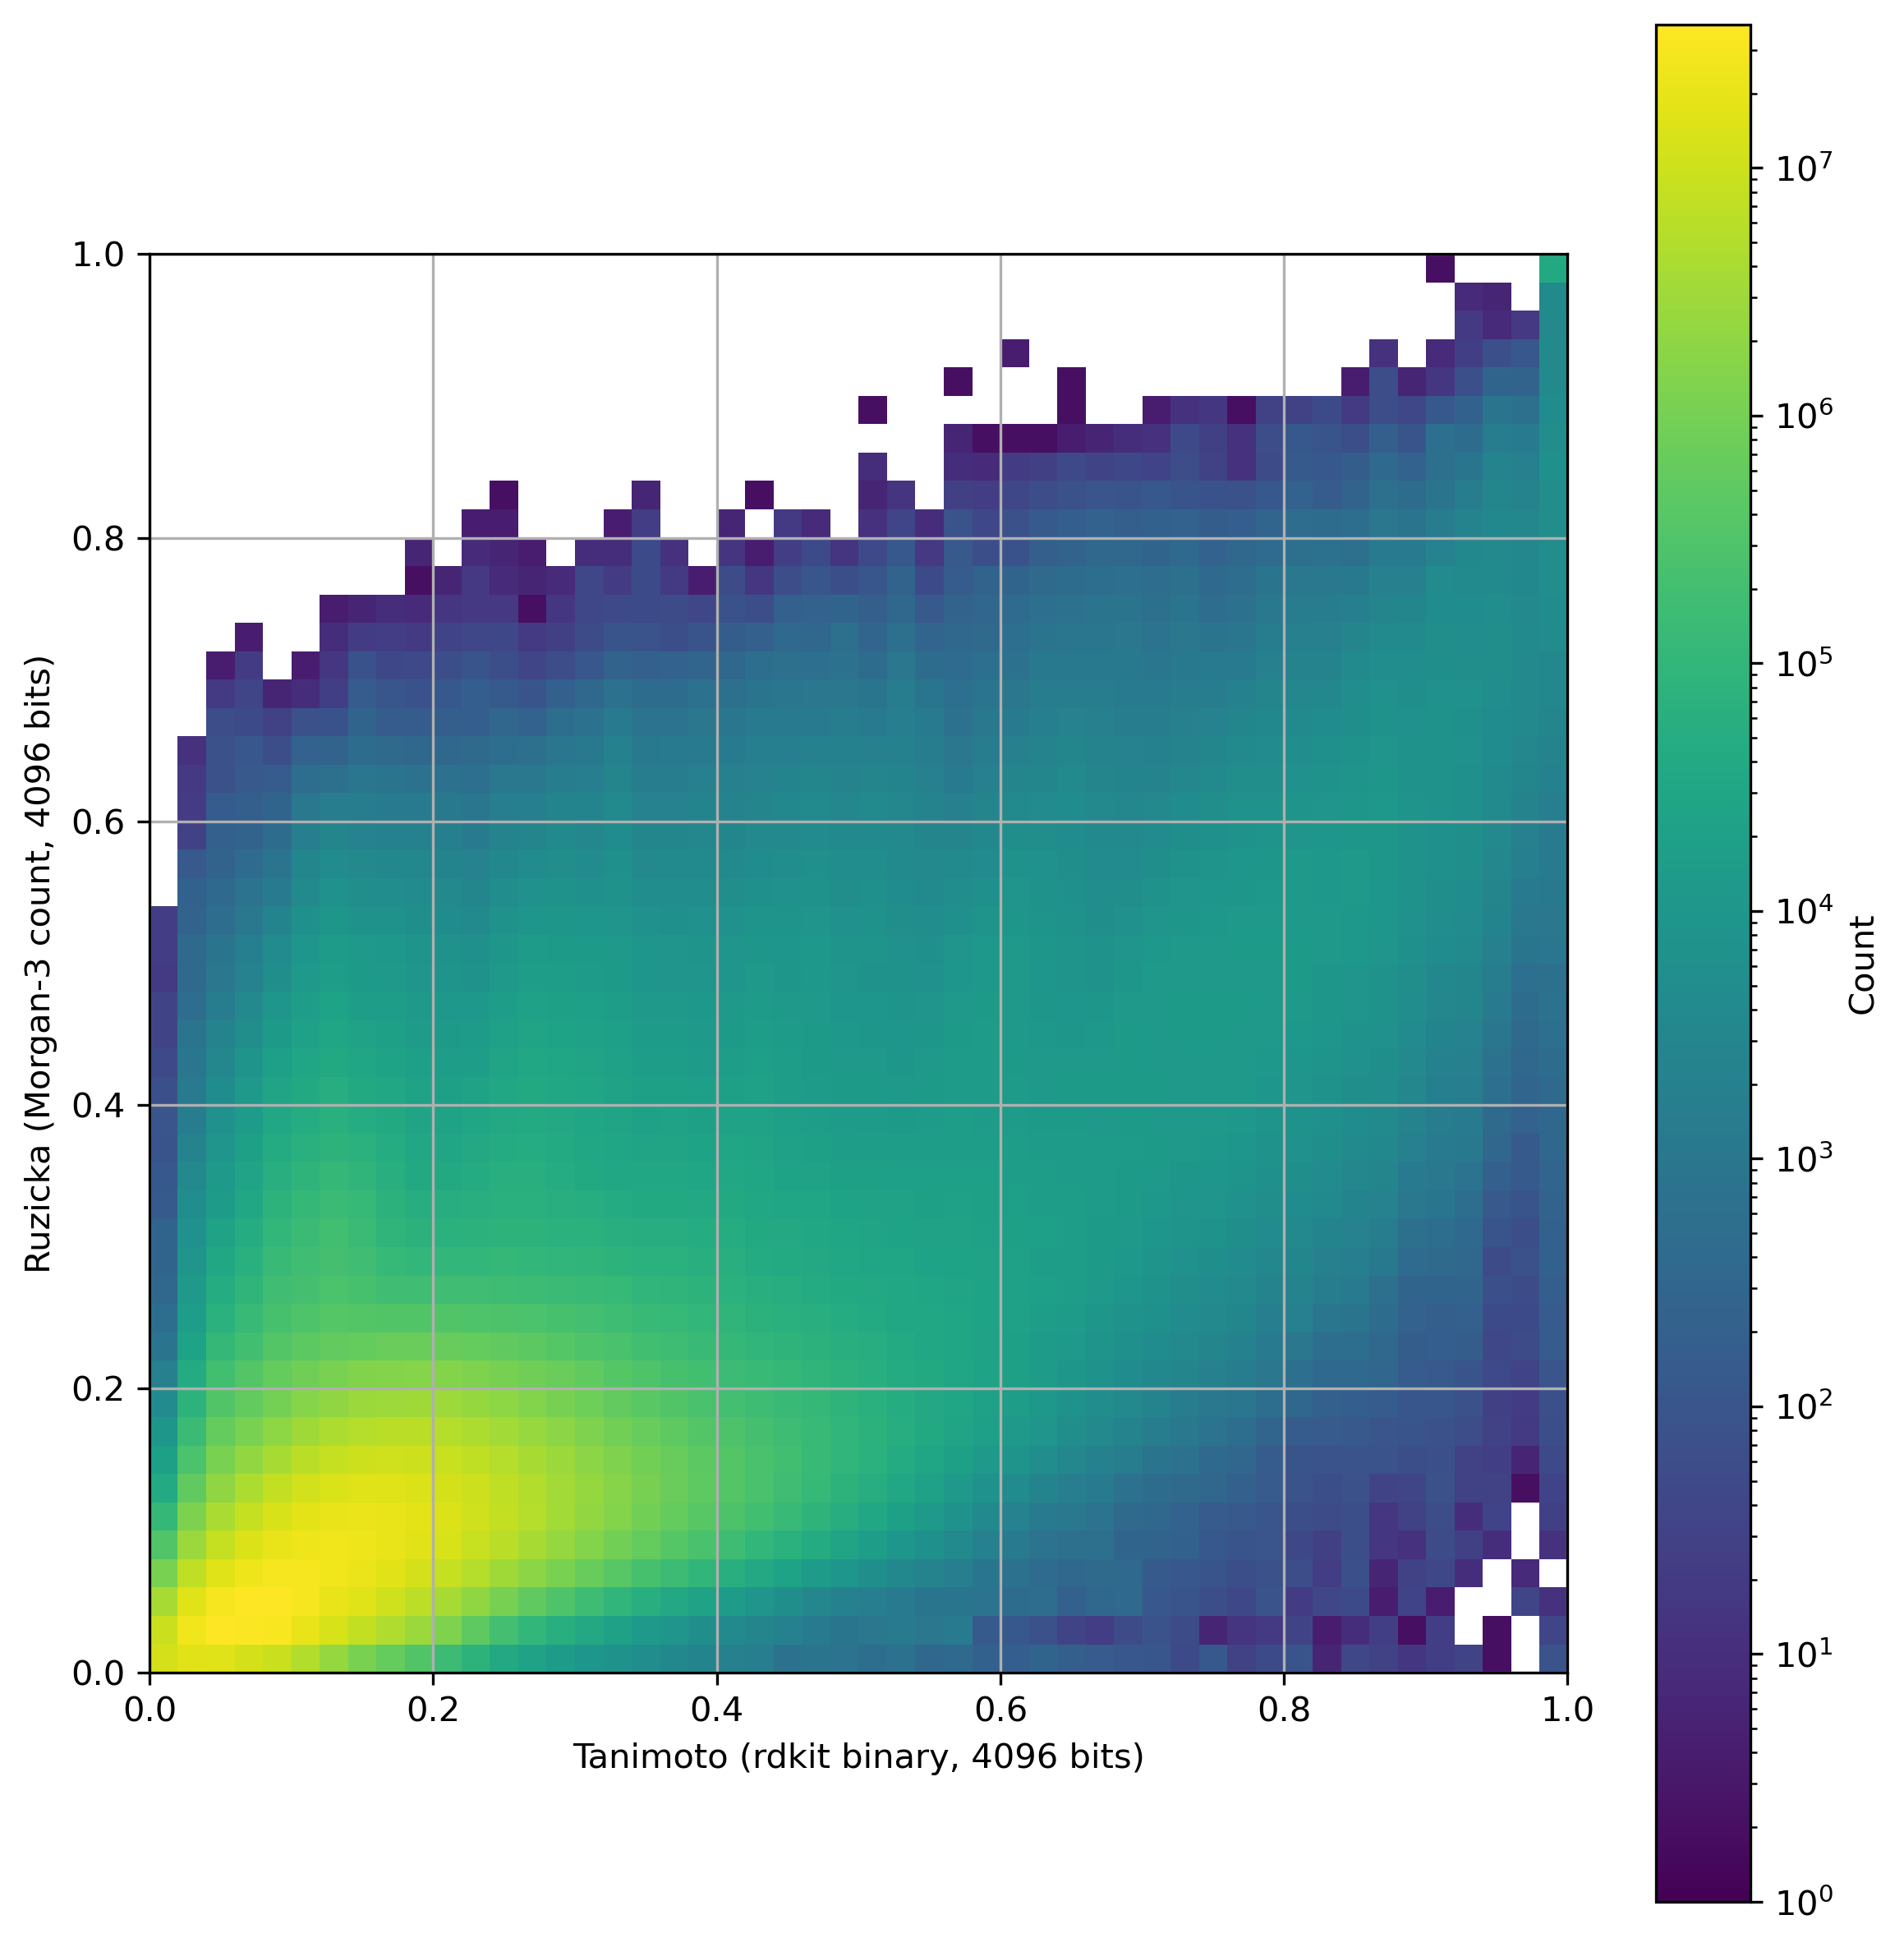

In [55]:
heatmap_comparison(
    similarities_classic,
    similarities_morgan3_count,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    bins=50,
    filename="heatmap_tanimoto_rdkit_vs_ruzicka_morgan3.png"
)

## Tanimoto (Morgan-3) vs Ruzicka (Morgan-3)

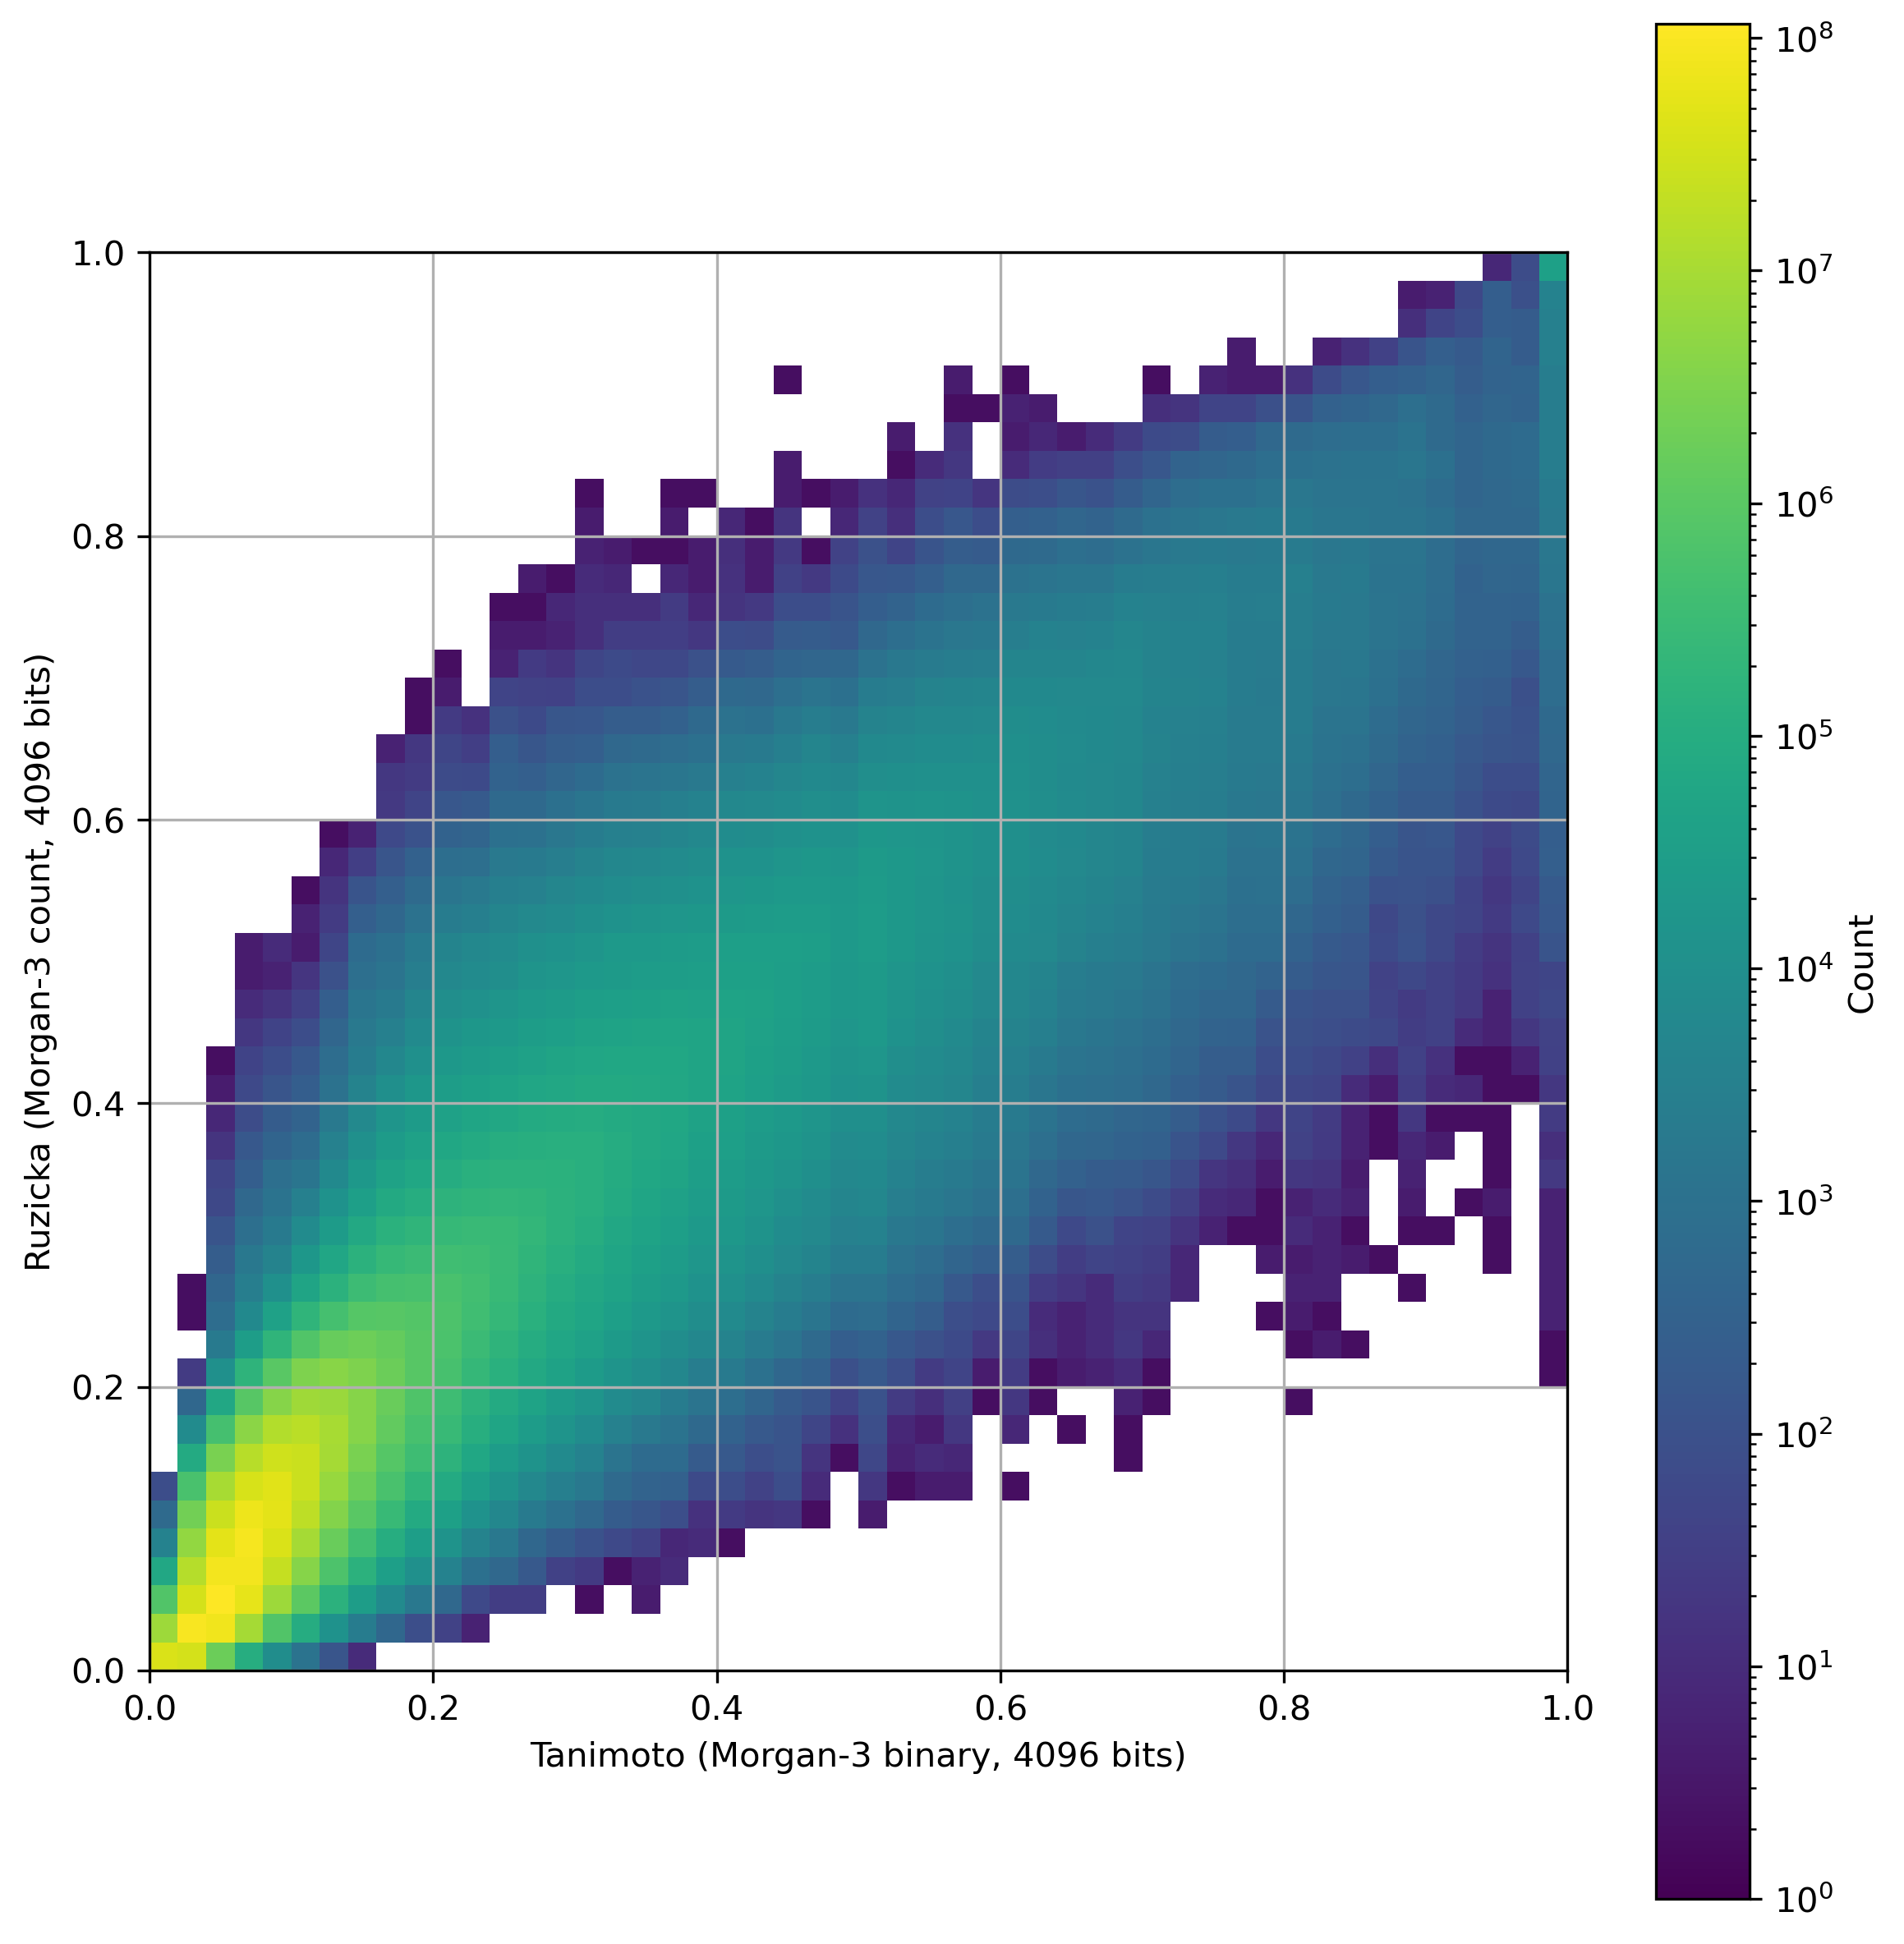

In [72]:
heatmap_comparison(
    similarities_morgan3,
    similarities_morgan3_count,
    f"Tanimoto (Morgan-3 binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    bins=50,
    filename="heatmap_tanimoto_morgan3_vs_ruzicka_morgan3.png"
)

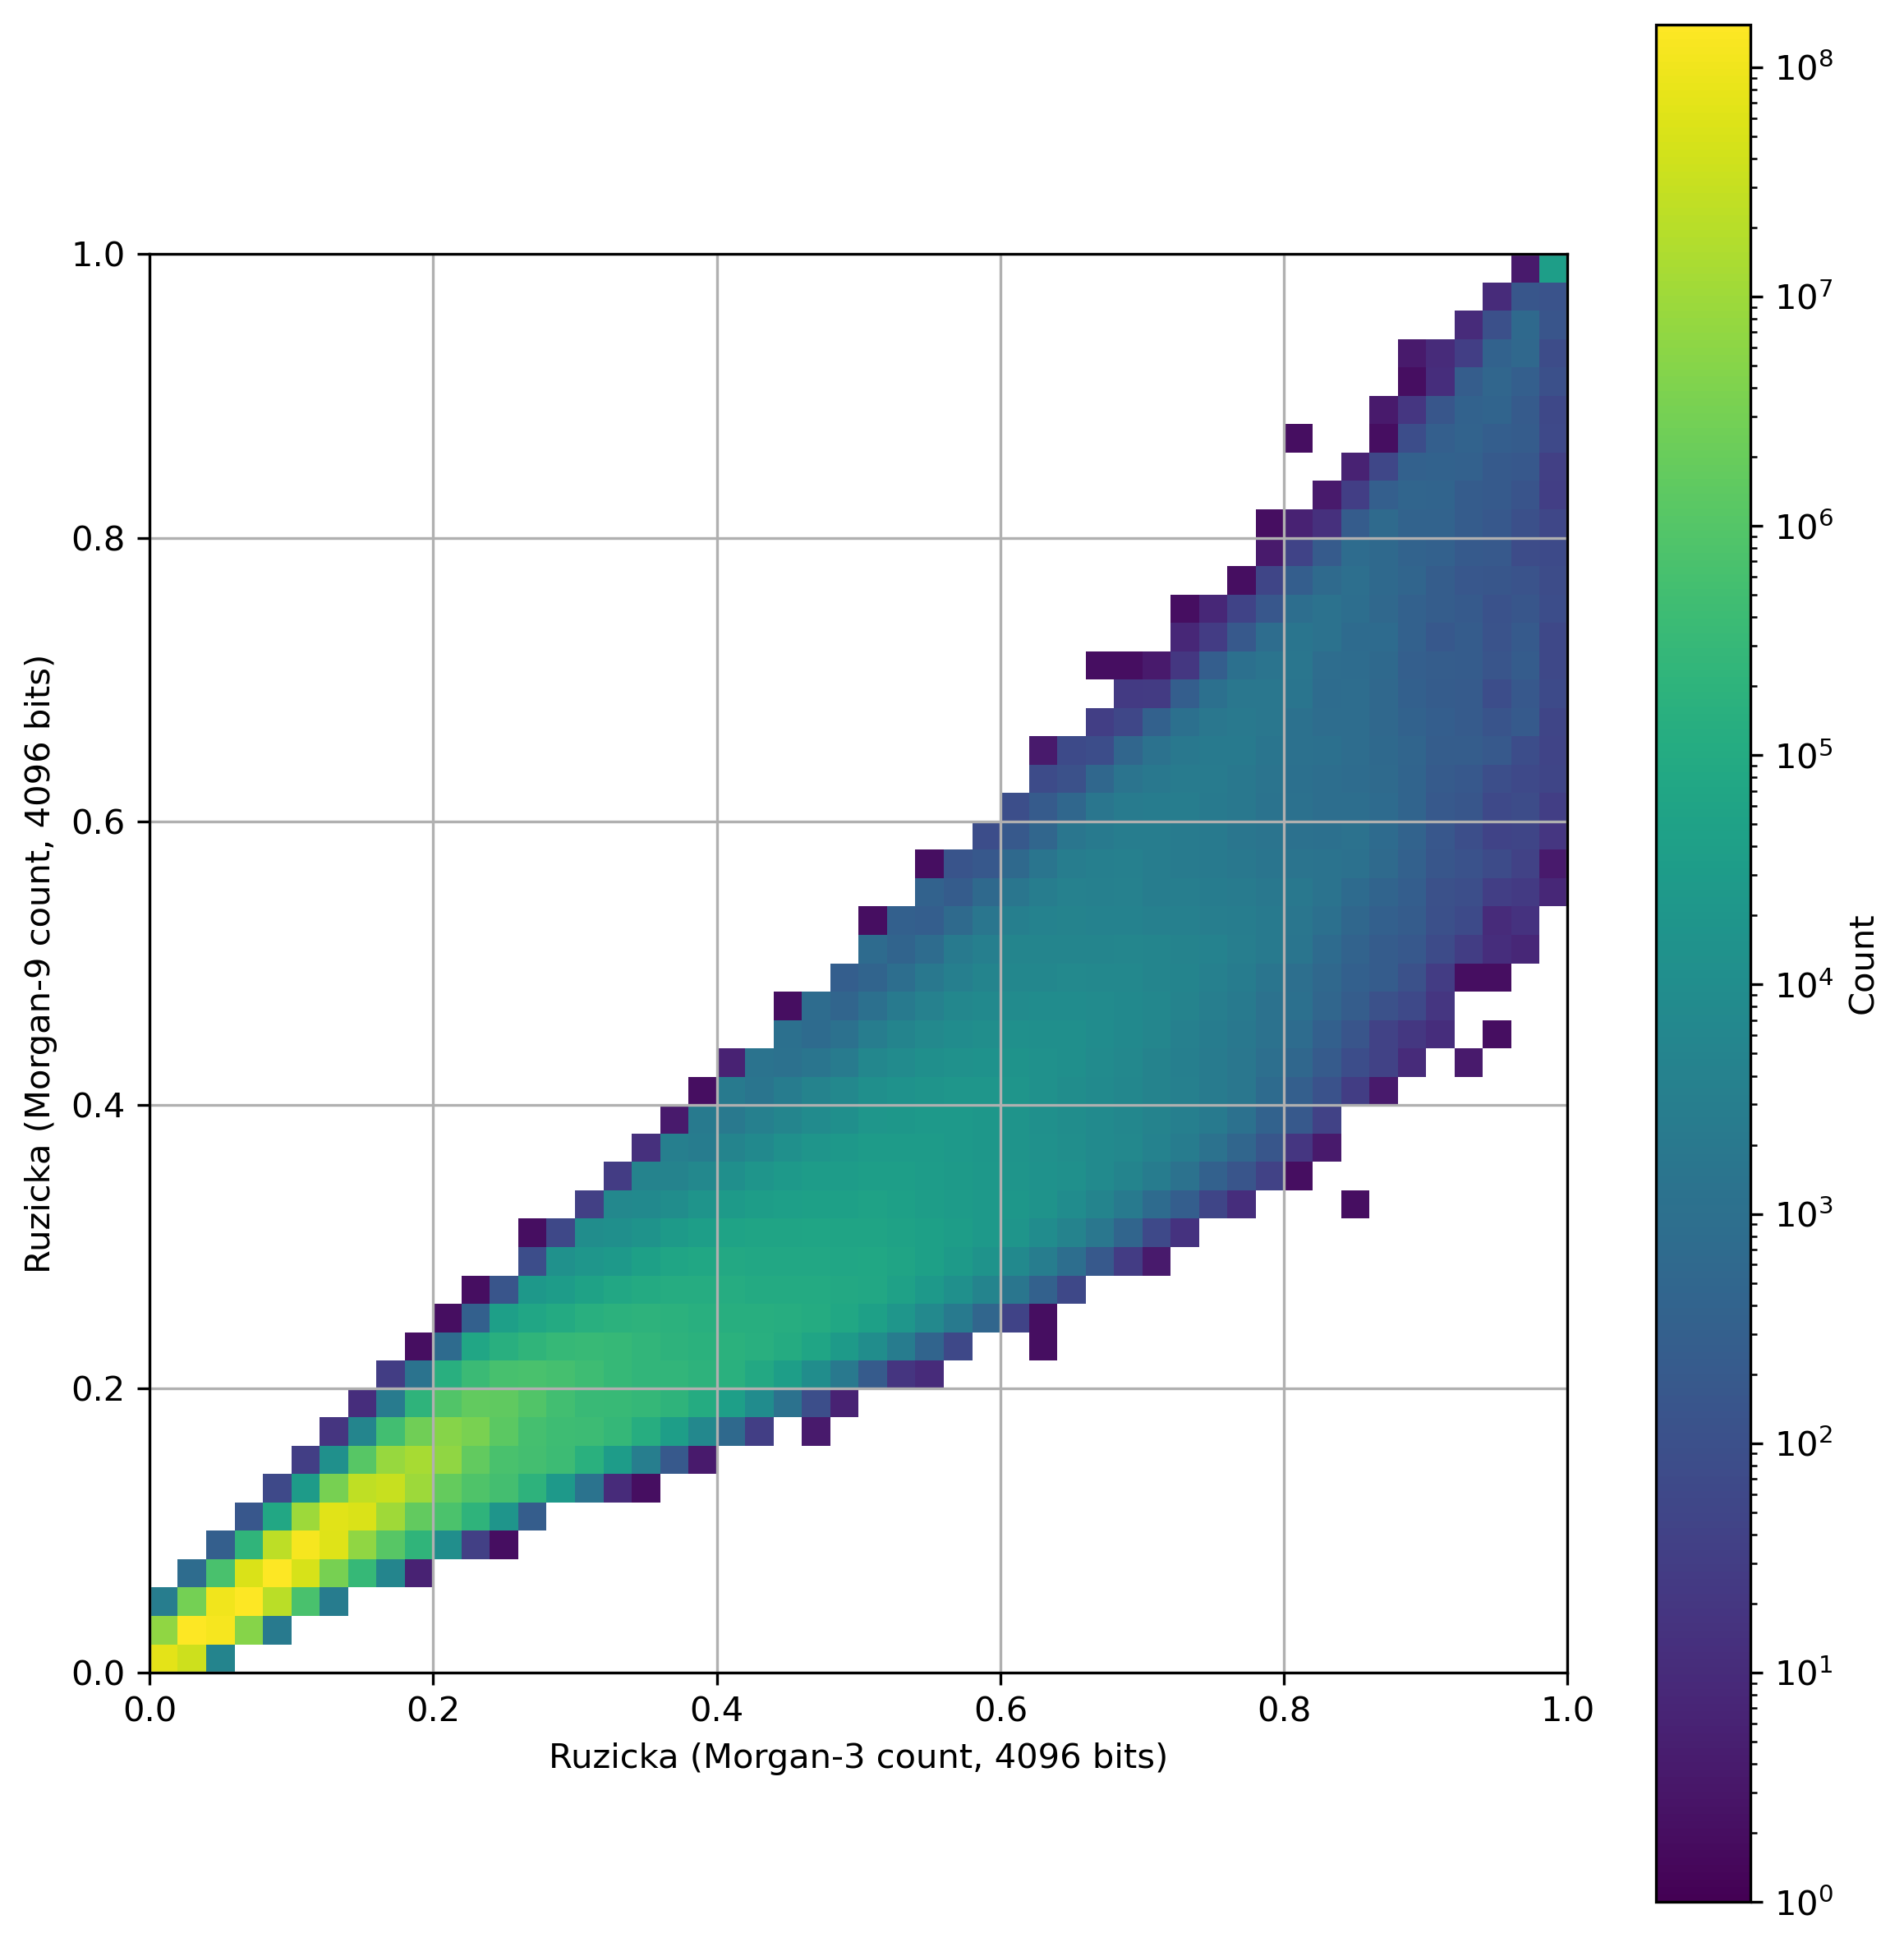

In [74]:
heatmap_comparison(
    similarities_morgan3_count,
    similarities_morgan9_count,
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    f"Ruzicka (Morgan-9 count, {NBITS} bits)",
    bins=50,
    filename="heatmap_ruzicka_morgan3_vs_ruzicka_morgan9.png"
)

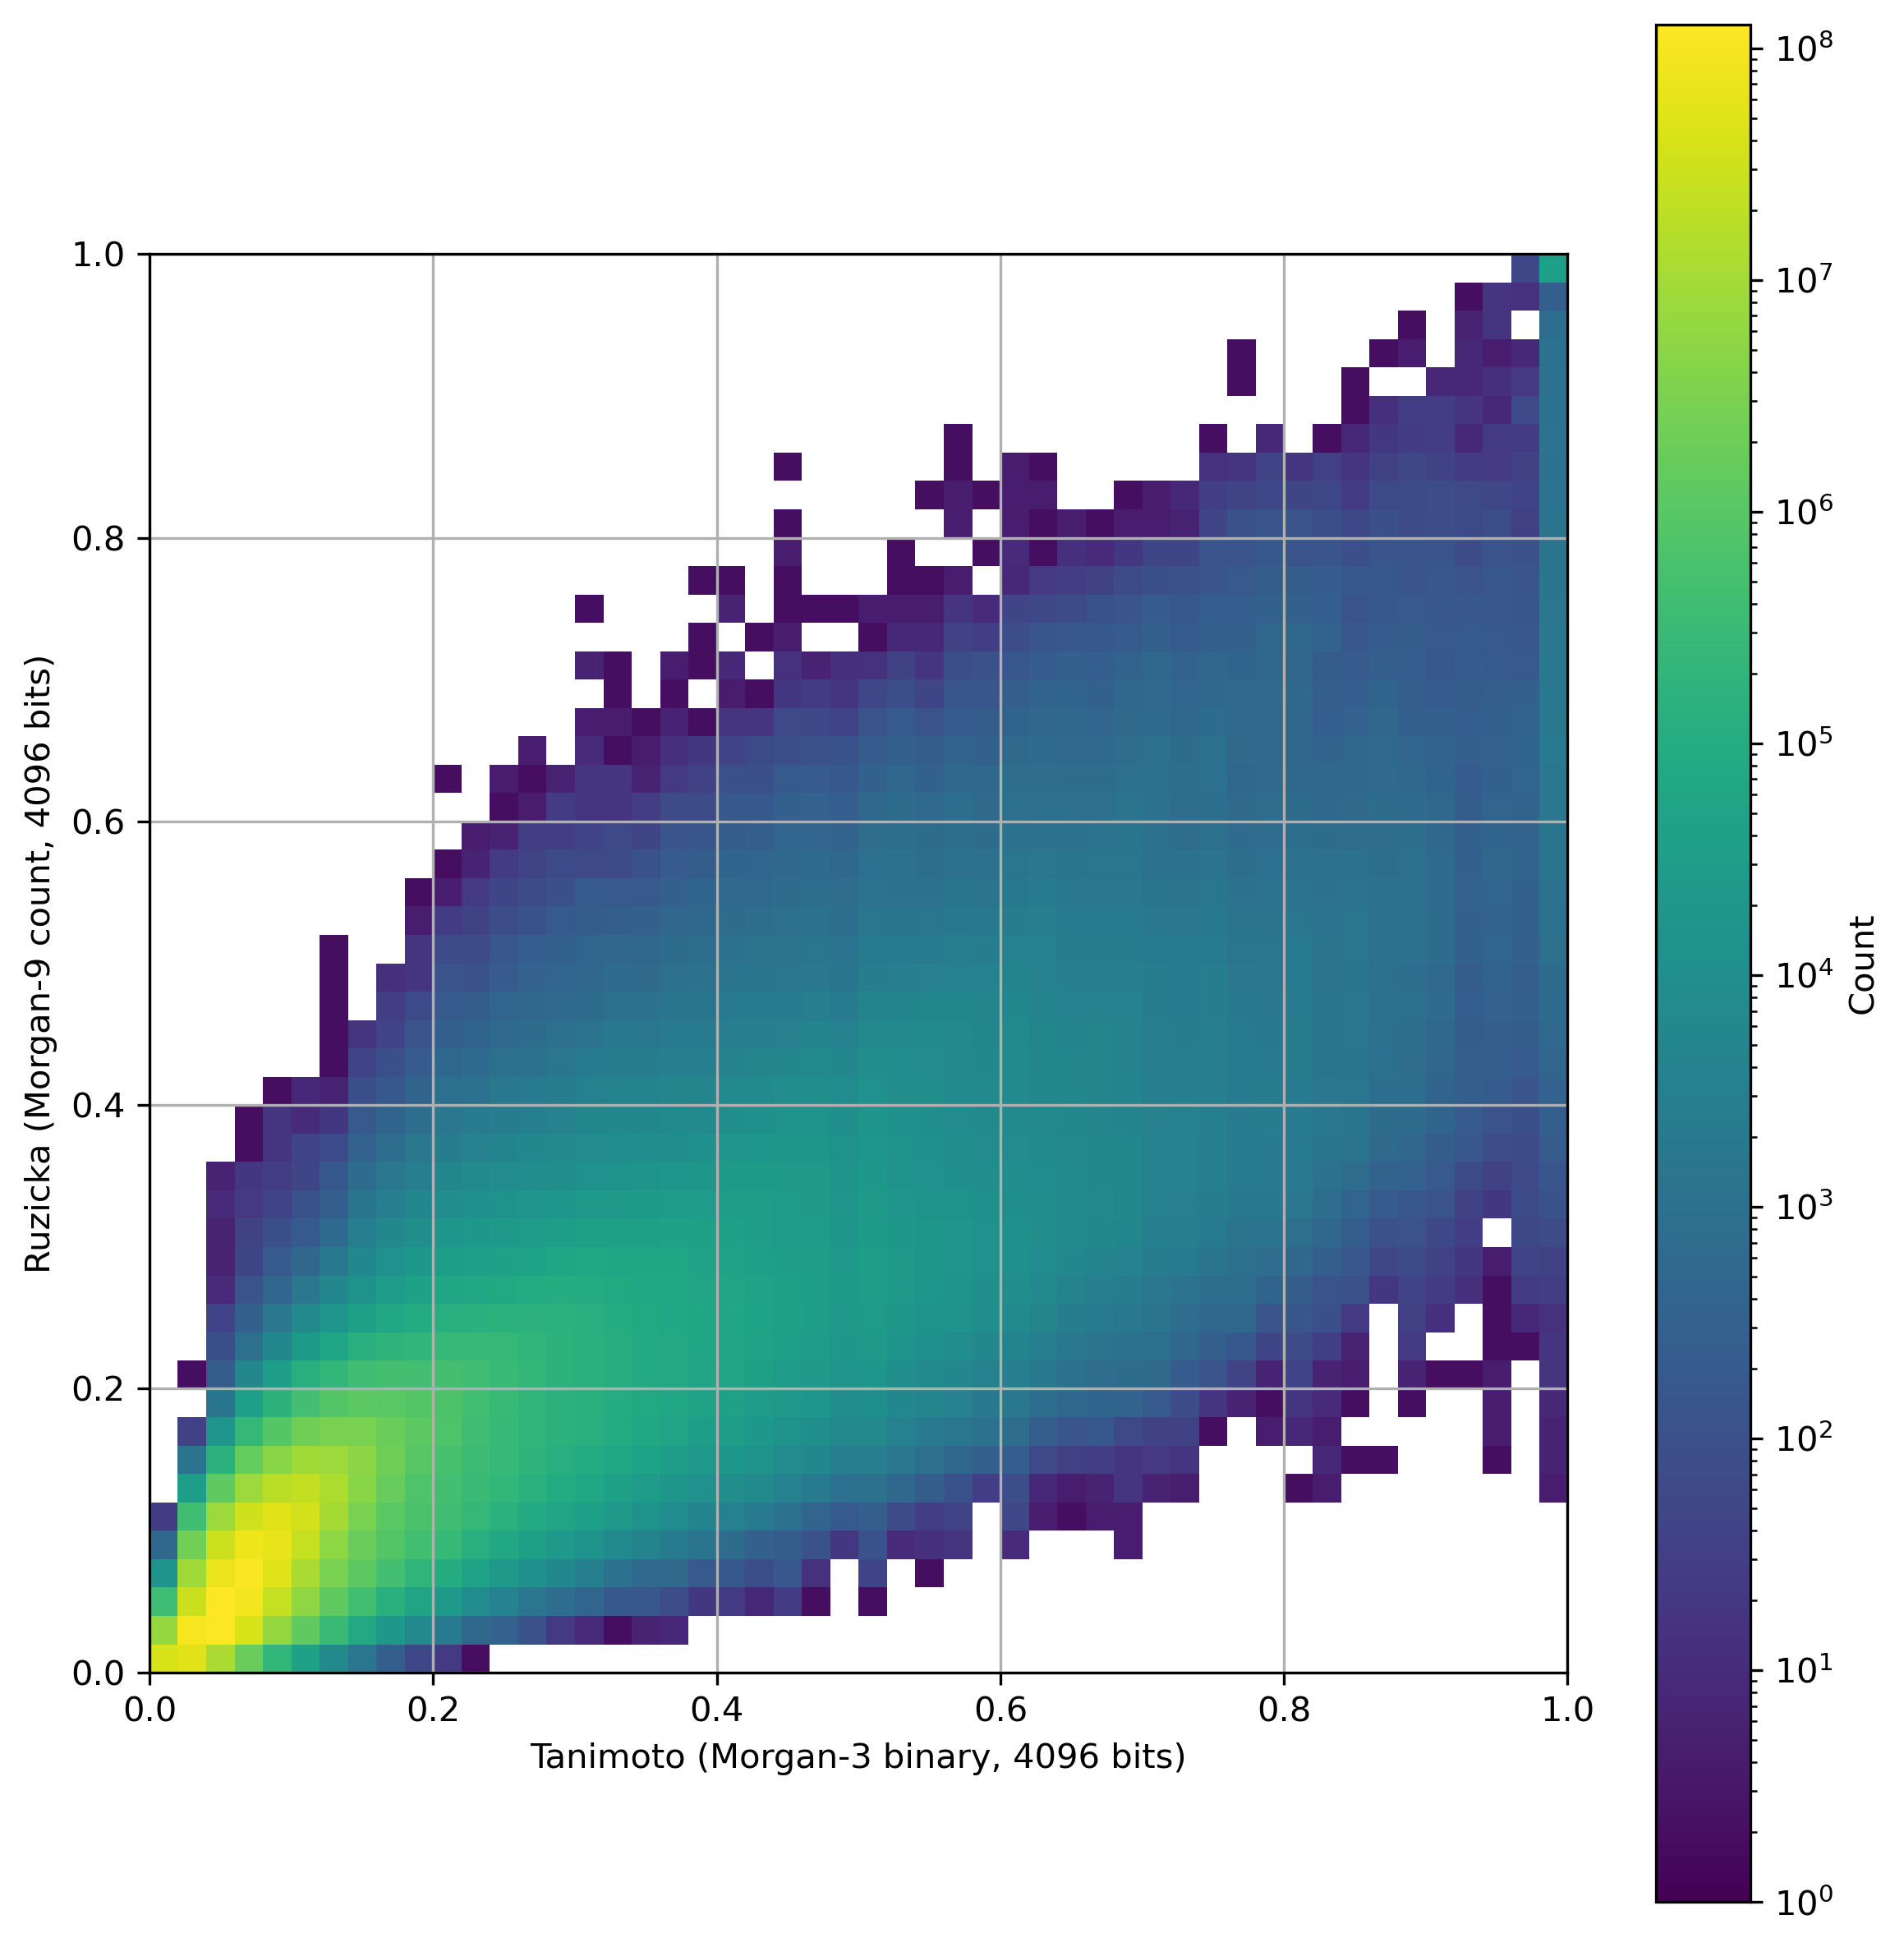

In [75]:
heatmap_comparison(
    similarities_morgan3,
    similarities_morgan9_count,
    f"Tanimoto (Morgan-3 binary, {NBITS} bits)",
    f"Ruzicka (Morgan-9 count, {NBITS} bits)",
    bins=50,
    filename="heatmap_tanimoto_morgan3_vs_ruzicka_morgan9.png"
)

## Compare to MAP4

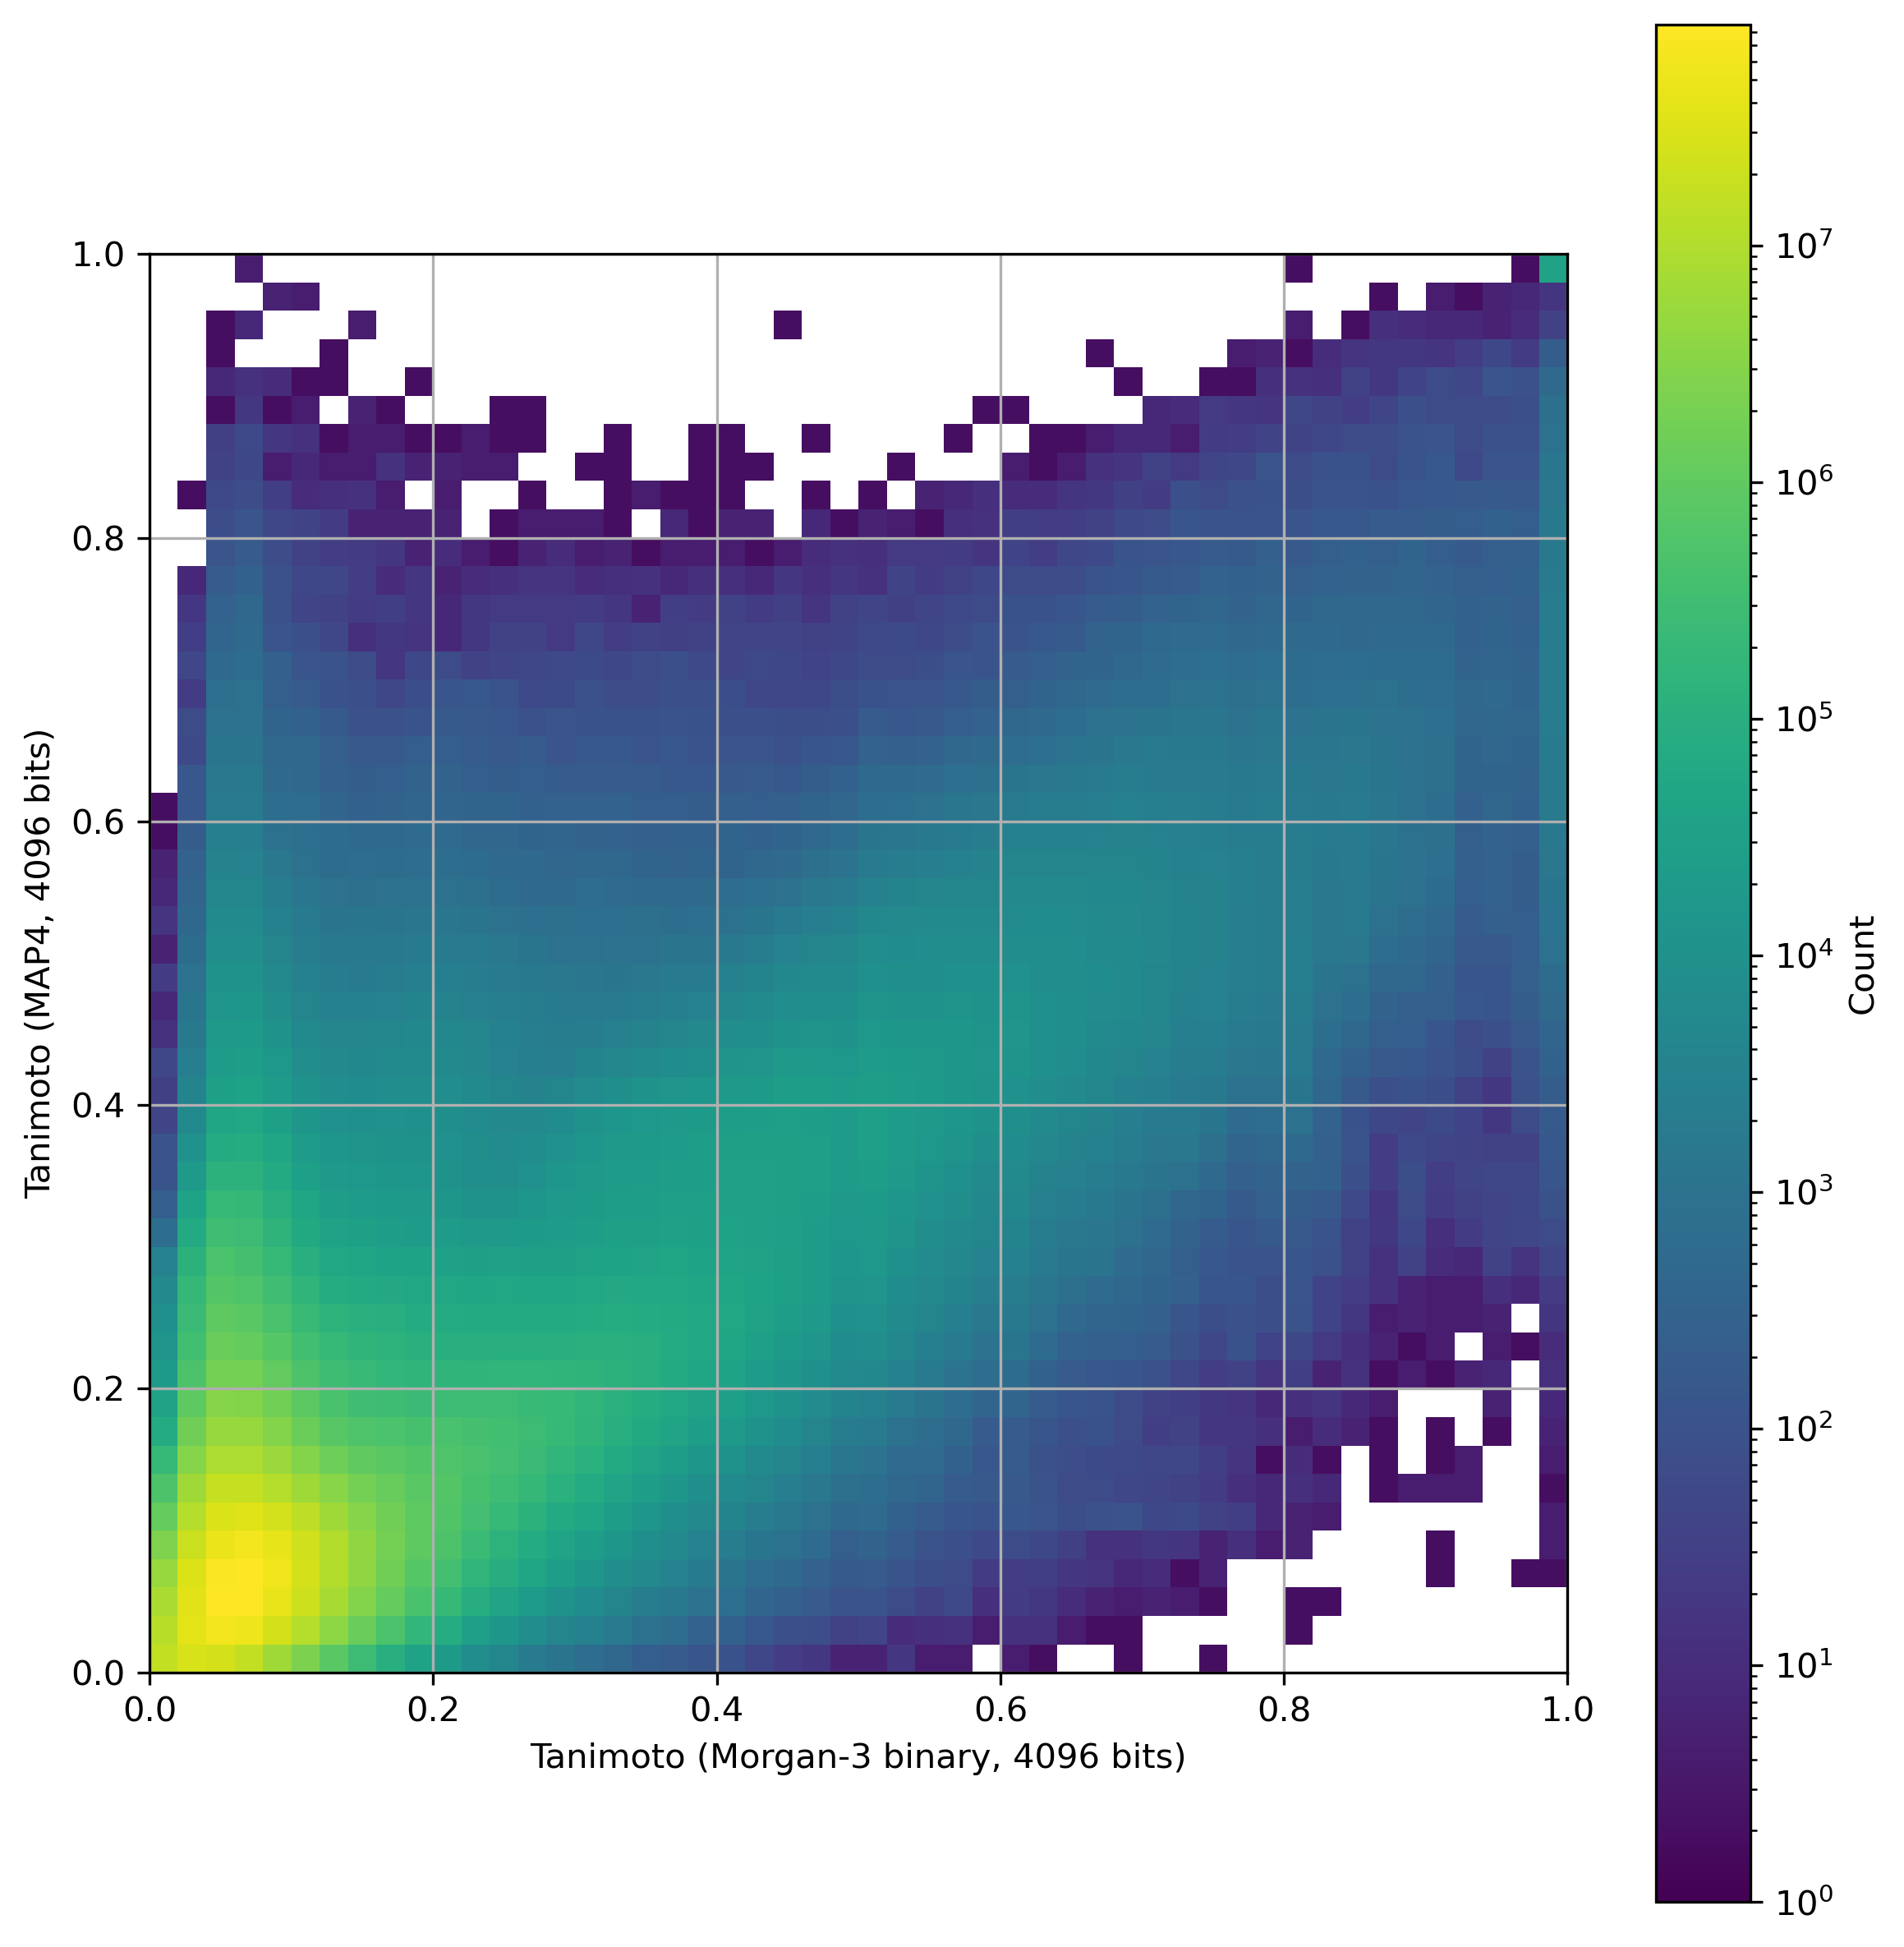

In [81]:
heatmap_comparison(
    similarities_morgan3,
    similarities_map4,
    f"Tanimoto (Morgan-3 binary, {NBITS} bits)",
    f"Tanimoto (MAP4, {NBITS} bits)",
    bins=50,
    filename="heatmap_tanimoto_morgan3_vs_tanimoto_map4.png"
)

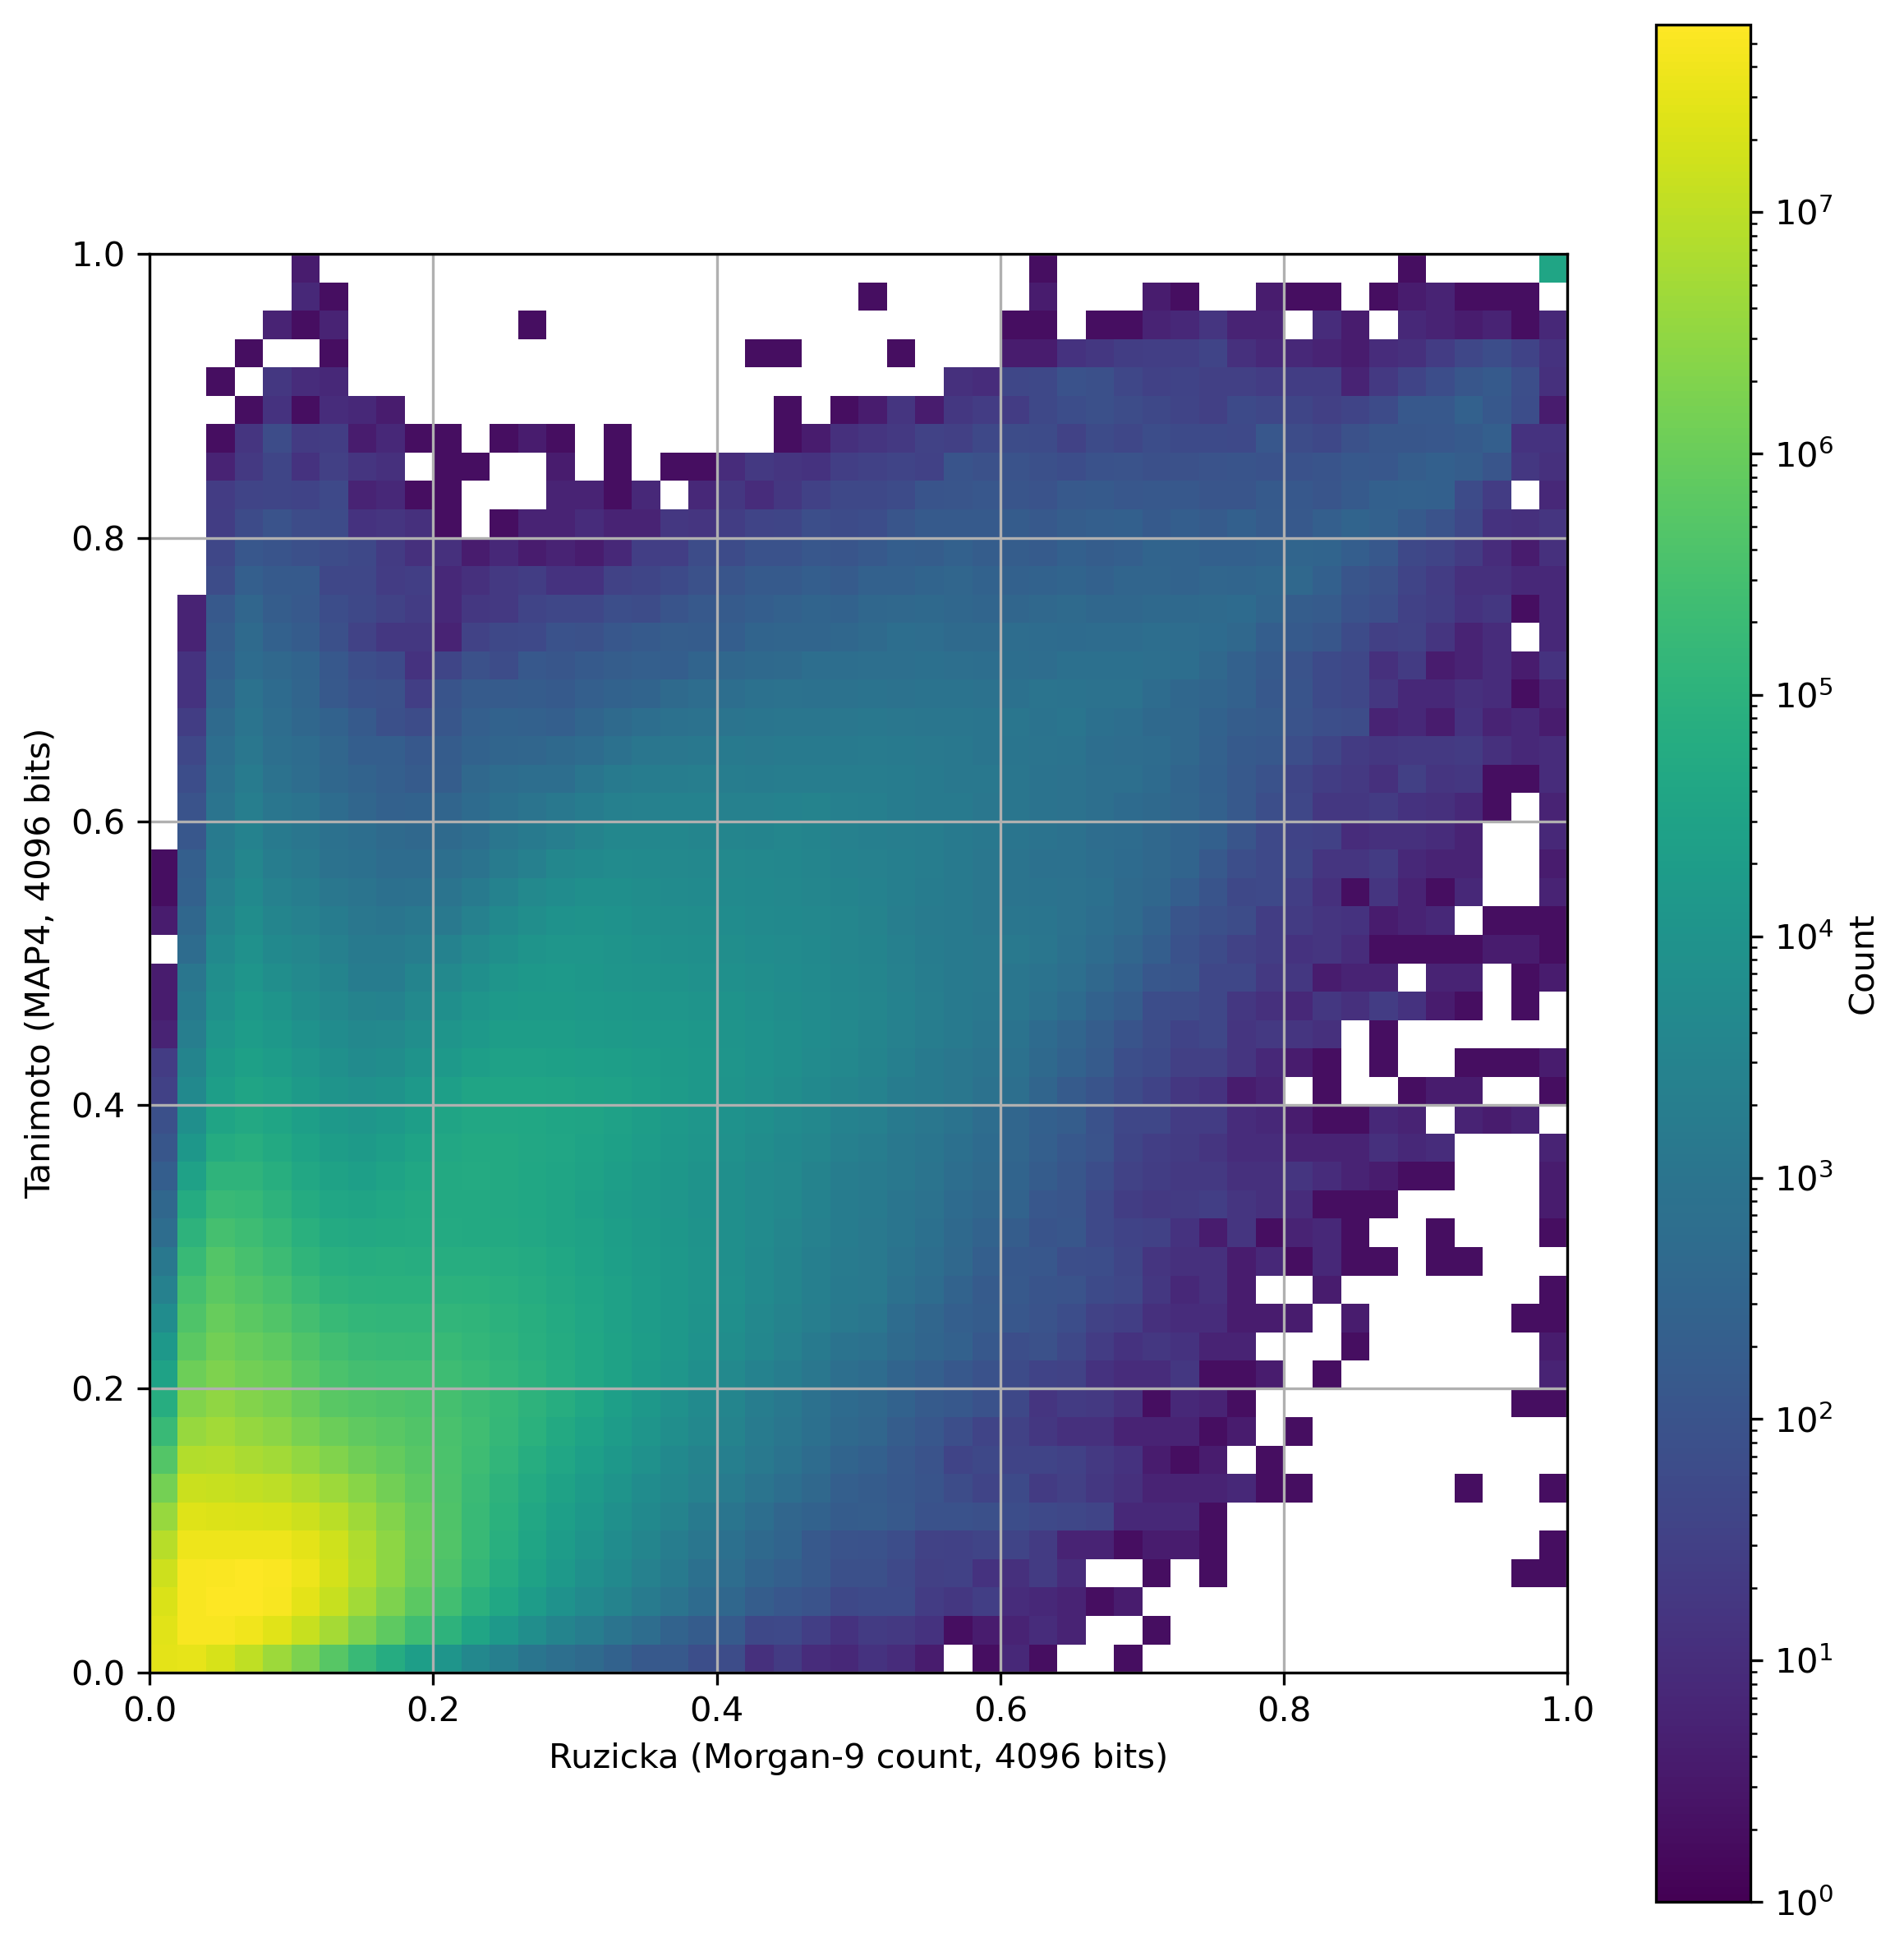

In [80]:
heatmap_comparison(
    similarities_morgan9_count,
    similarities_map4,
    f"Ruzicka (Morgan-9 count, {NBITS} bits)",
    f"Tanimoto (MAP4, {NBITS} bits)",
    bins=50,
    filename="heatmap_ruzicka_morgan9_vs_tanimoto_map4.png"
)

In [88]:
def get_score_summary(id1, id2):
    scores = {
        "Tanimoto (rdkit binary fp)": similarities_classic[id1, id2],
        "Tanimoto (Morgan-3 binary fp)": similarities_morgan3[id1, id2],
        "Tanimoto (MAP4 fp)": similarities_map4[id1, id2],
        "Ruzicka (Morgan-3 count fp)": similarities_morgan3_count[id1, id2],
        "Ruzicka (Morgan-9 count fp)": similarities_morgan9_count[id1, id2],
    }
    scores = pd.DataFrame.from_dict(scores, orient='index', columns=["Score"])
    return scores

In [94]:
def show_pairs(unique_pairs):
    for pair in unique_pairs:
        display(get_score_summary(pair[0], pair[1]))
    
        smiles1 = compounds.smiles[indices_selected[pair[0]]]
        smiles2 = compounds.smiles[indices_selected[pair[1]]]
        mol = Chem.MolFromSmiles(smiles1)
        display(mol)
        mol = Chem.MolFromSmiles(smiles2)
        display(mol)

In [191]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

def get_score_summary(id1, id2):
    scores = {
        "Tanimoto (rdkit binary fp)": similarities_classic[id1, id2],
        "Tanimoto (Morgan-3 binary fp)": similarities_morgan3[id1, id2],
        "Tanimoto (MAP4 fp)": similarities_map4[id1, id2],
        "Ruzicka (Morgan-3 count fp)": similarities_morgan3_count[id1, id2],
        "Ruzicka (Morgan-9 count fp)": similarities_morgan9_count[id1, id2],
    }
    return pd.DataFrame.from_dict(scores, orient='index', columns=["Score"])


def show_pairs_in_grid(unique_pairs, ncols=2, figsize=(30, 18), filename=None):
    nrows = -(-len(unique_pairs) // ncols)  # Ceiling division to get number of rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten to iterate easily

    for i, pair in enumerate(unique_pairs):
        id1, id2 = pair
        ax = axes[i]
        
        # Get SMILES and render molecules
        smiles1 = compounds.smiles[indices_selected[id1]]
        smiles2 = compounds.smiles[indices_selected[id2]]
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        img = Draw.MolsToGridImage([mol1, mol2], molsPerRow=2, subImgSize=(800, 800), returnPNG=False)
        
        ax.imshow(img)
        ax.axis('off')
        
        # Get and display score summary below the molecules
        scores = get_score_summary(id1, id2)
        ax.set_title(f"Pair {i + 1}")
        ax.text(0.5, 0, scores.to_string(header=False), 
                transform=ax.transAxes, ha='center', fontsize=10, family='monospace')
    
    # Hide any unused subplots if number of pairs is less than grid size
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()


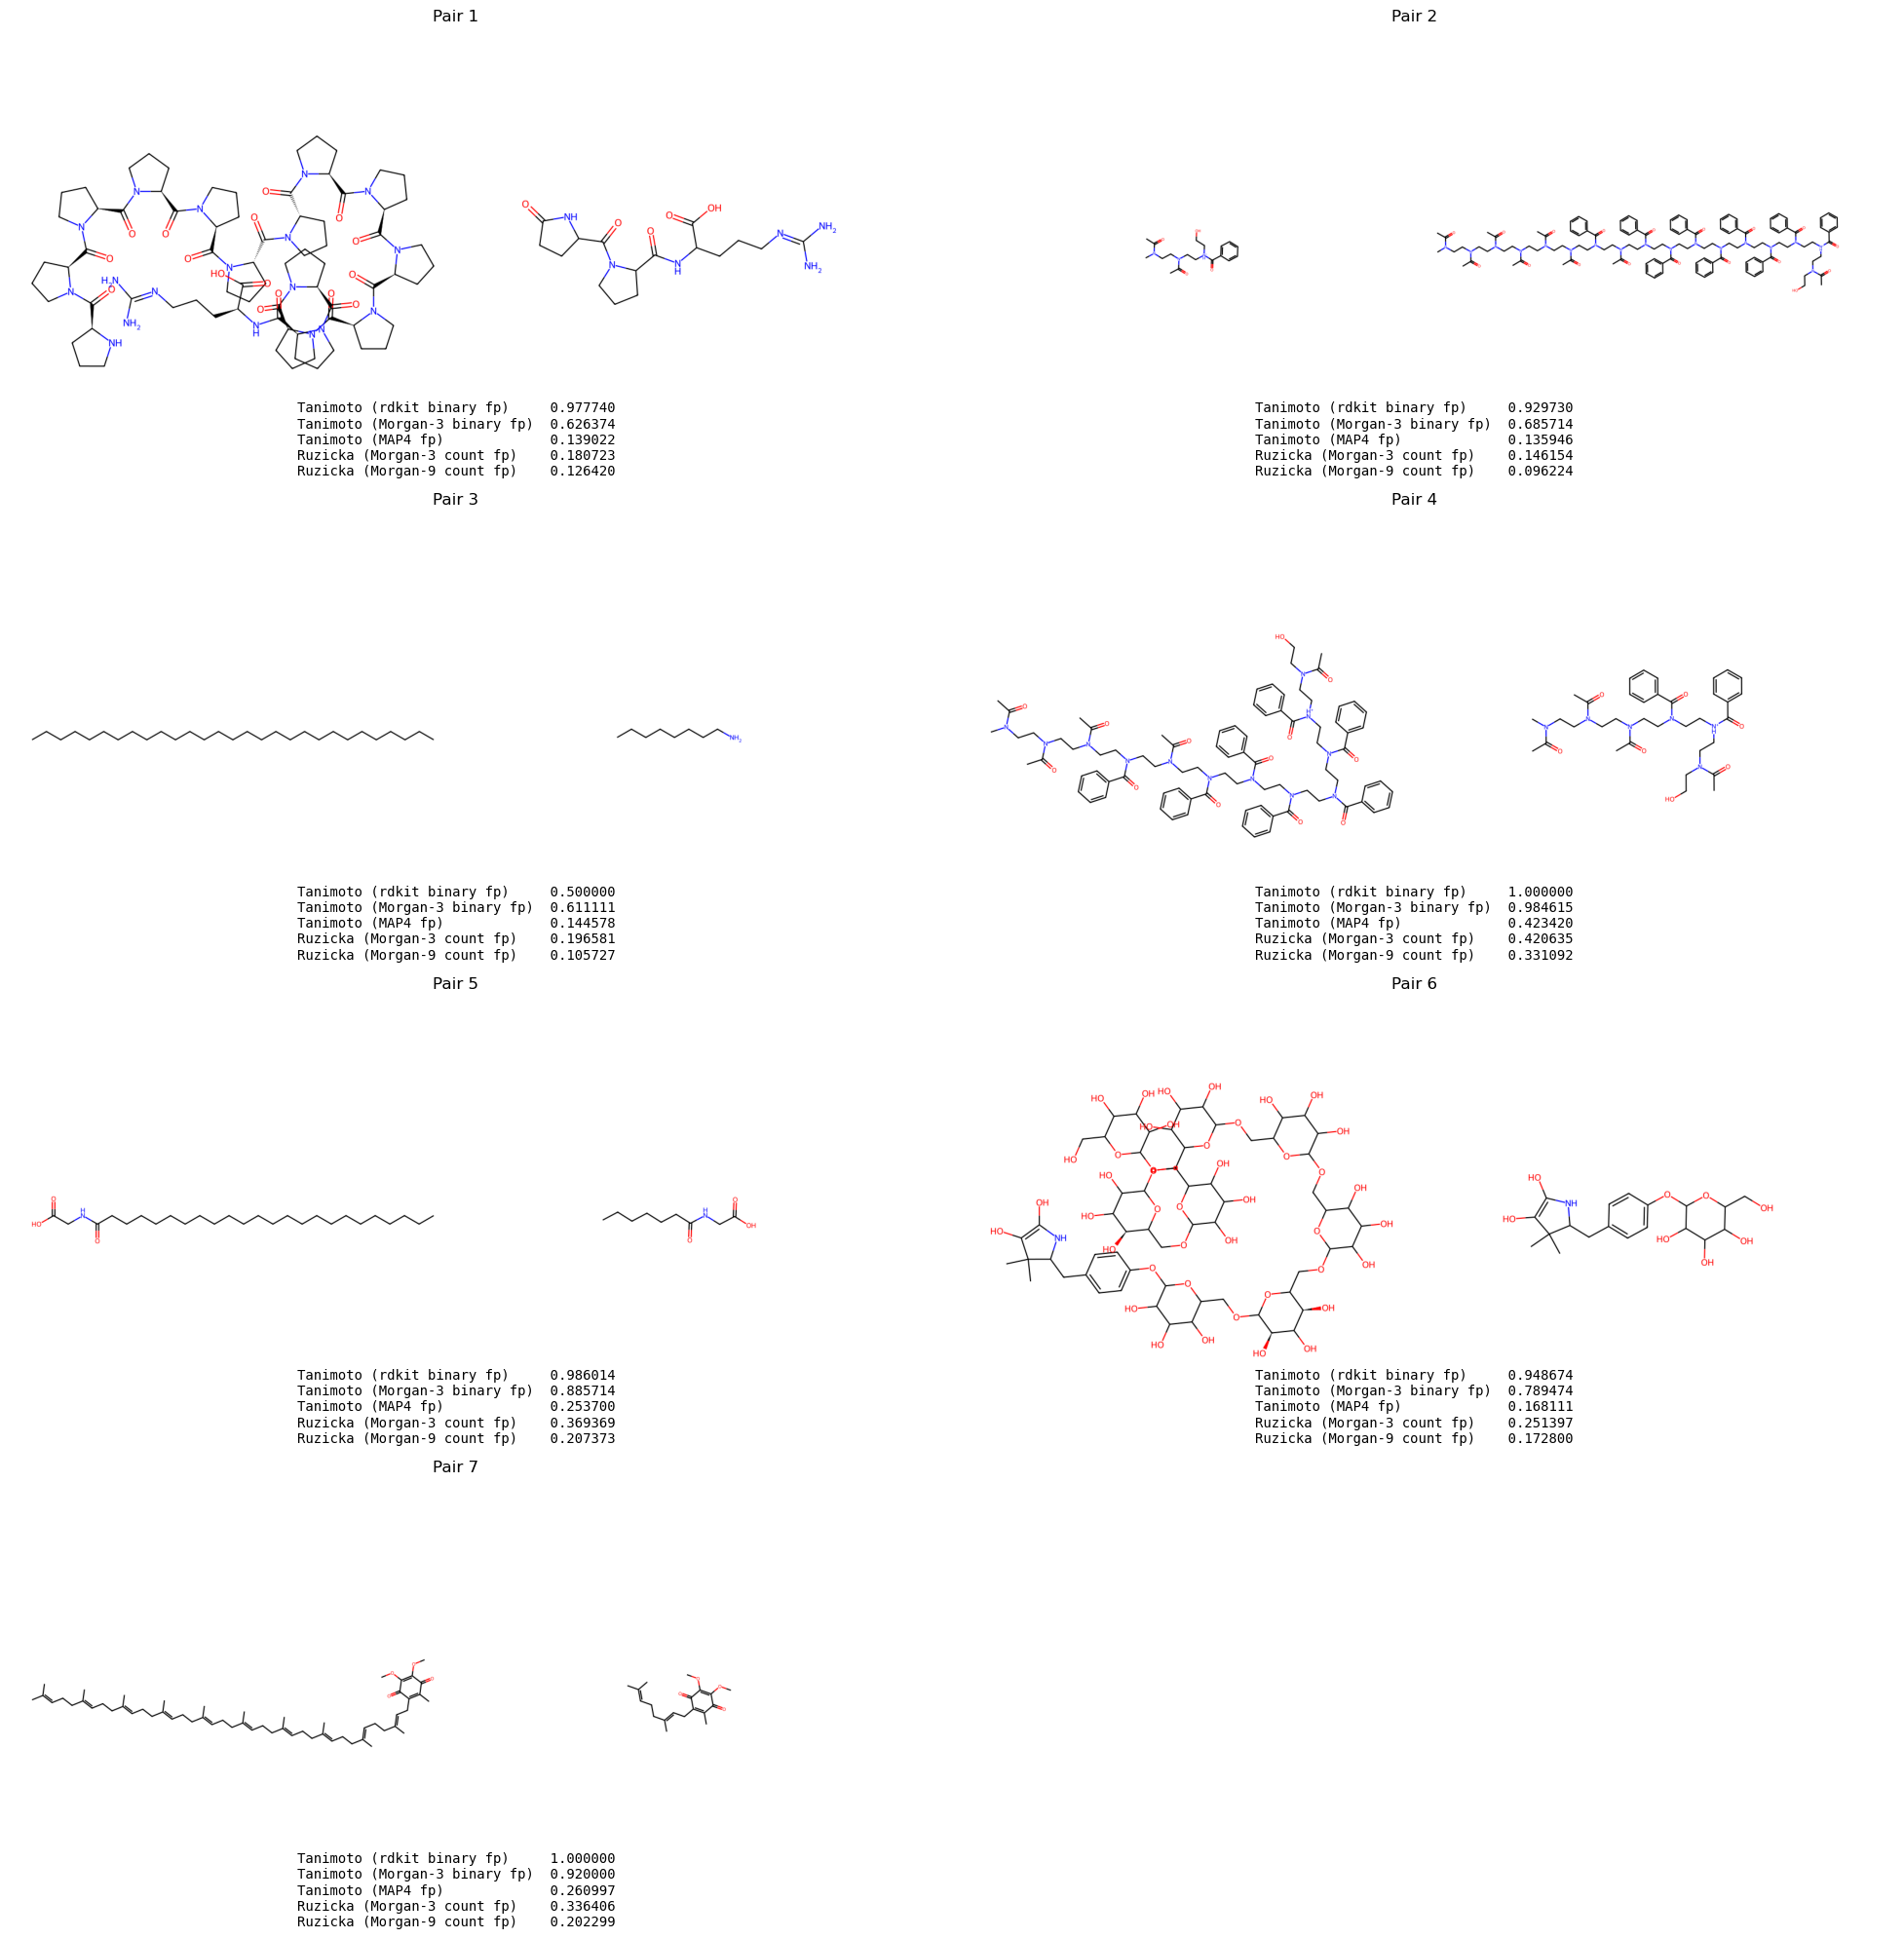

In [194]:
show_pairs_in_grid(selected_pairs_high12_low345, ncols=2, figsize=(20, 20),
                   filename="selected_pairs_high12_low345.png"
                  )

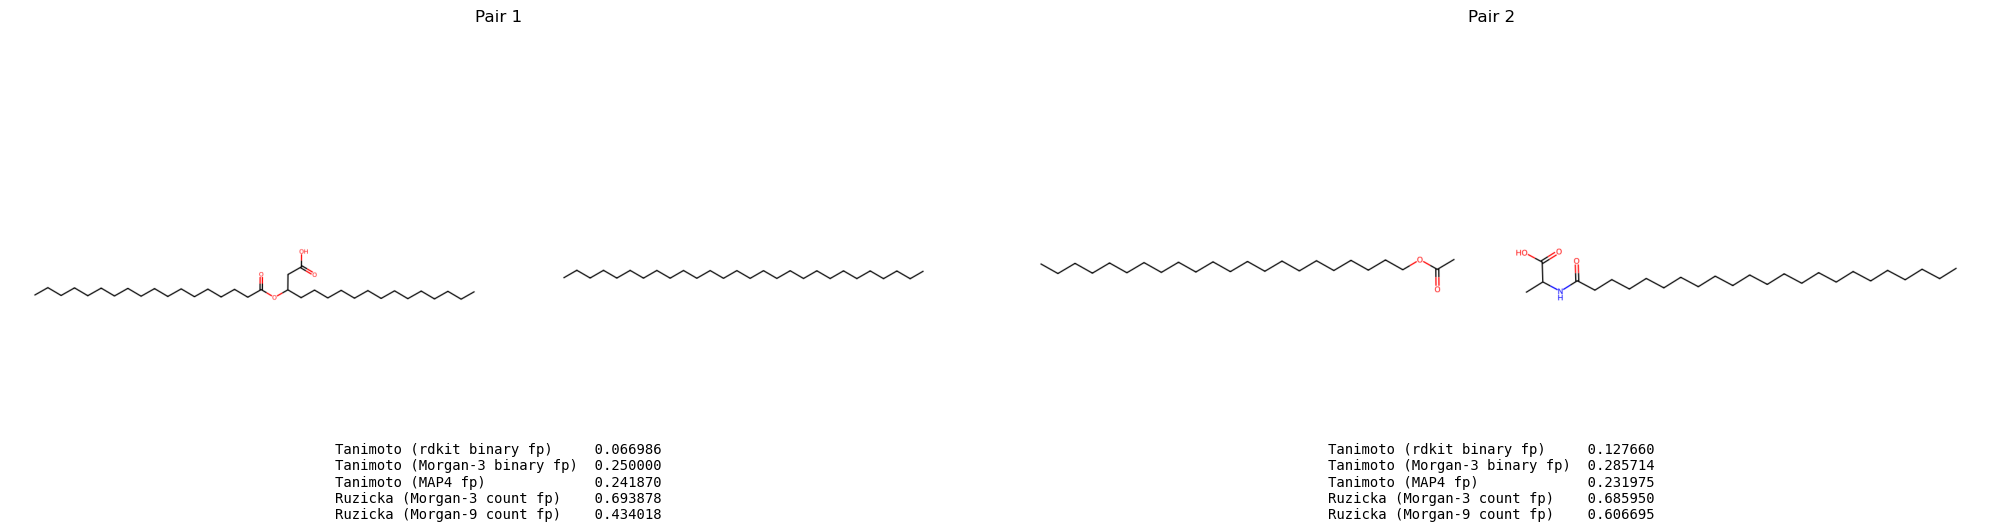

In [195]:
show_pairs_in_grid(selected_pairs_low123_high45 , ncols=2, figsize=(20, 20),
                   filename="selected_pairs_low123_high45.png"
                  )

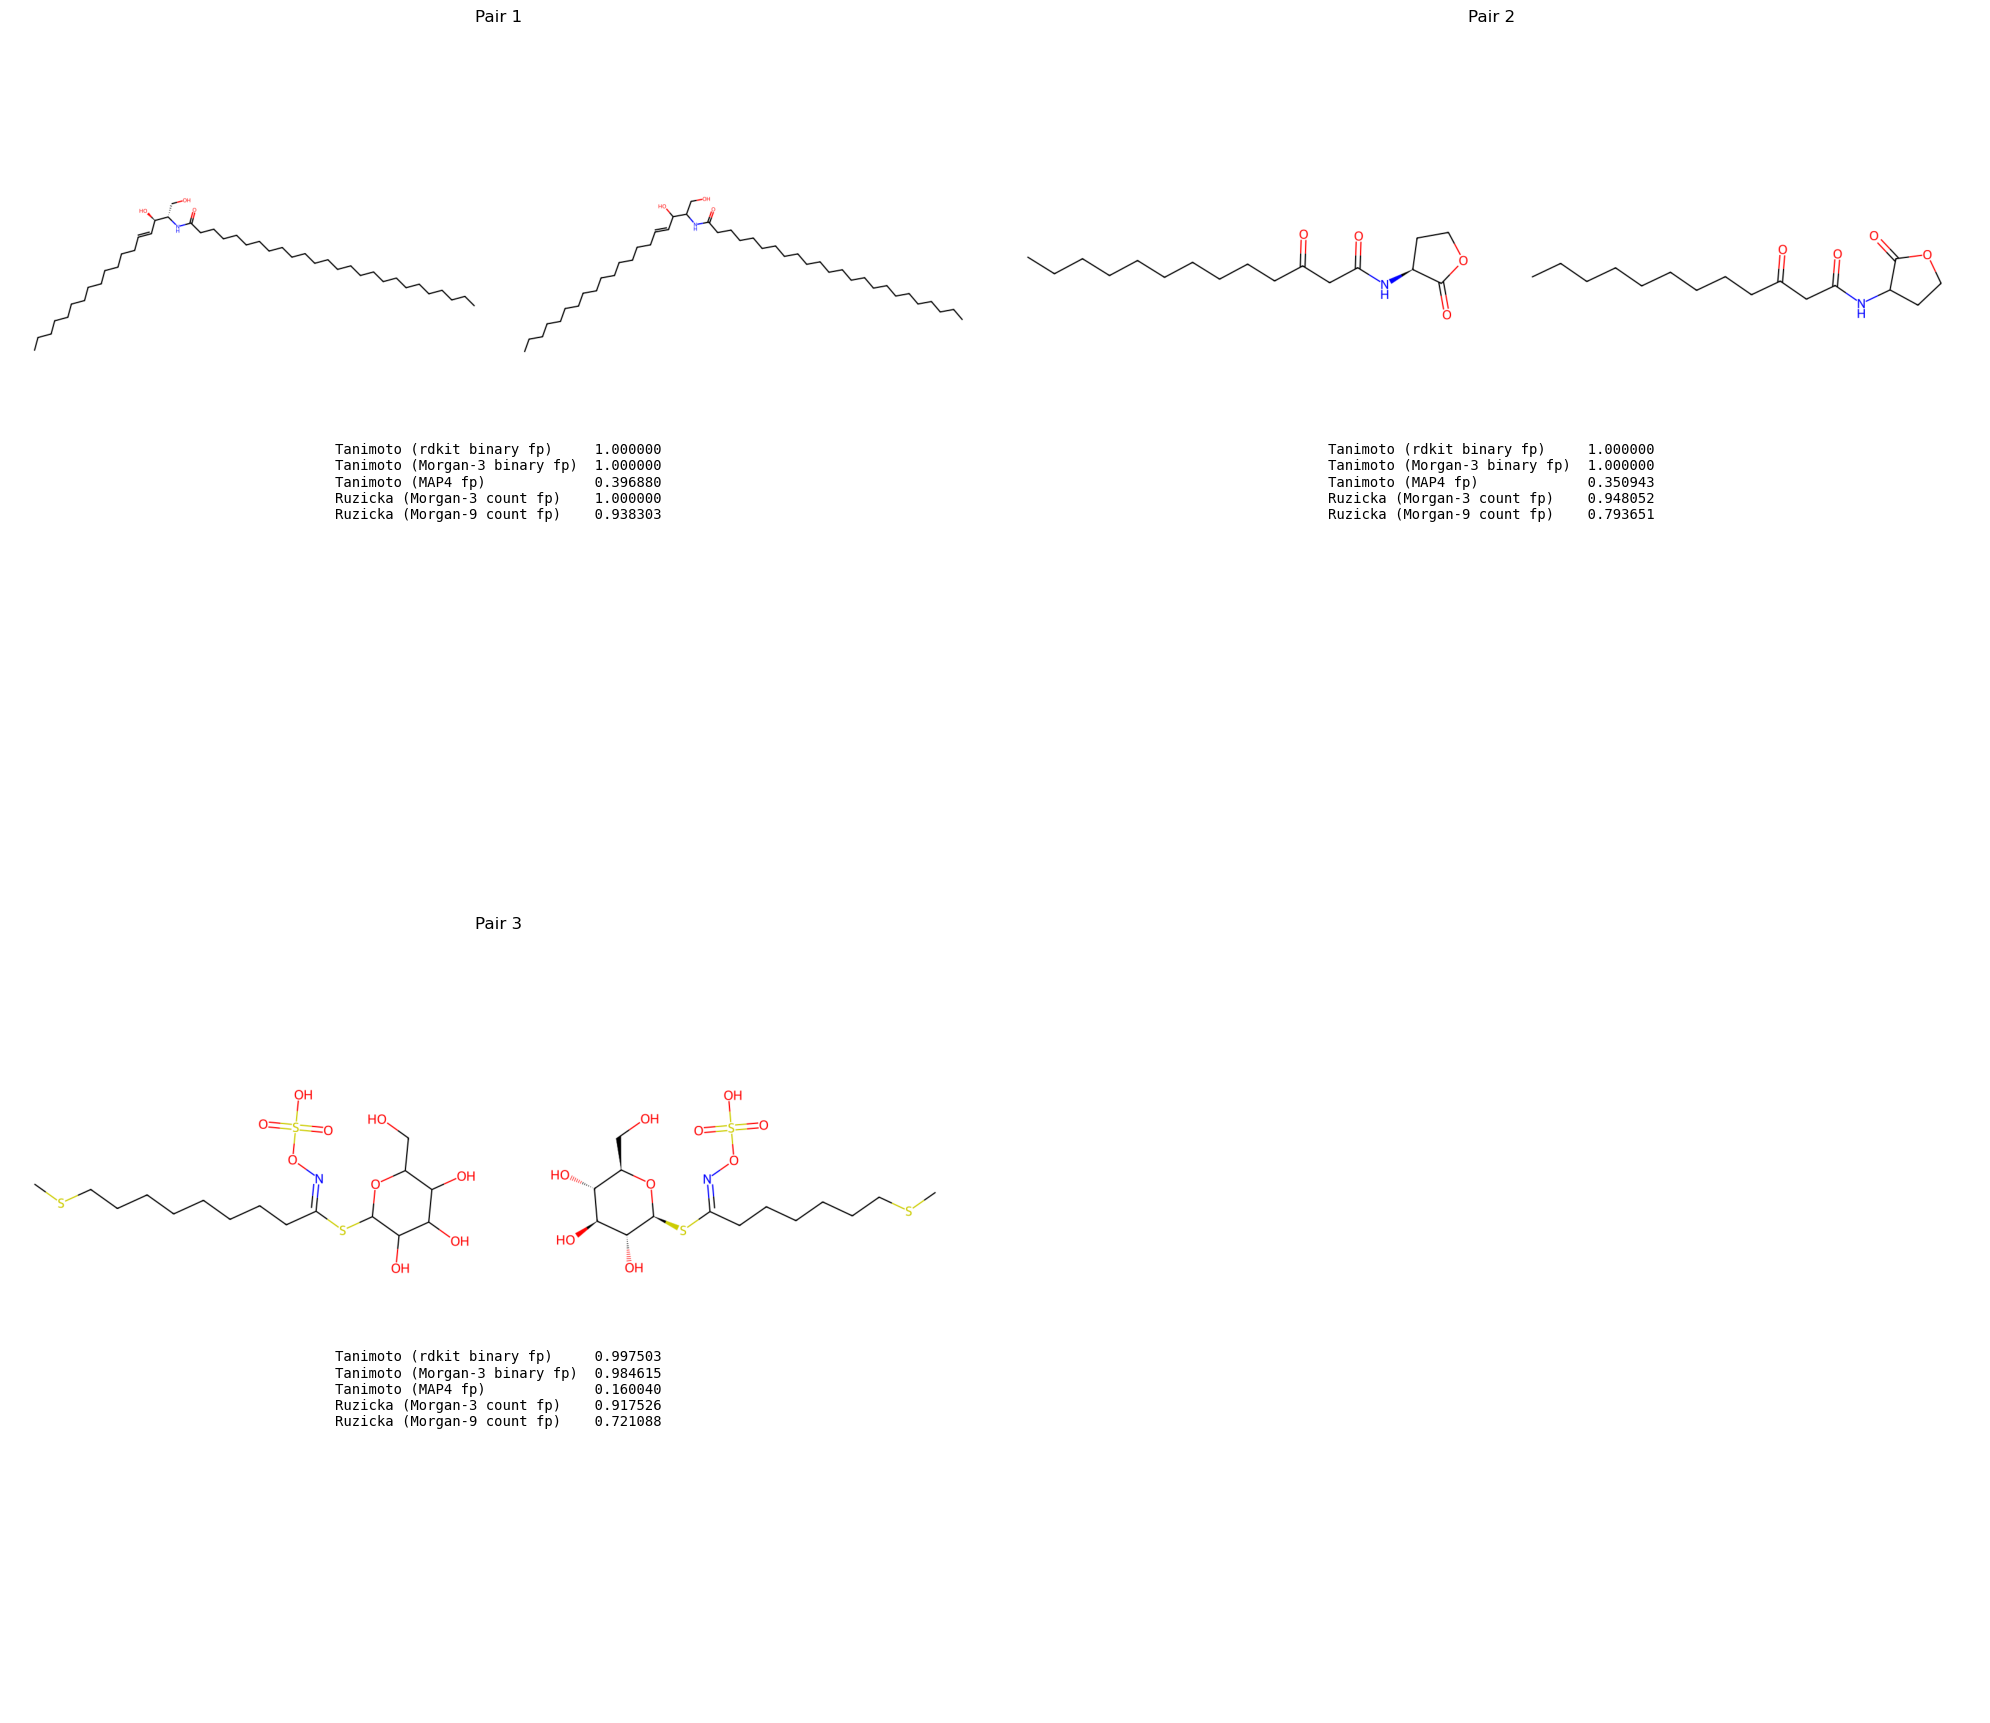

In [196]:
show_pairs_in_grid(selected_pairs_high1245_low3 , ncols=2, figsize=(20, 20),
                   filename="selected_pairs_high1245_low3.png"
                  )

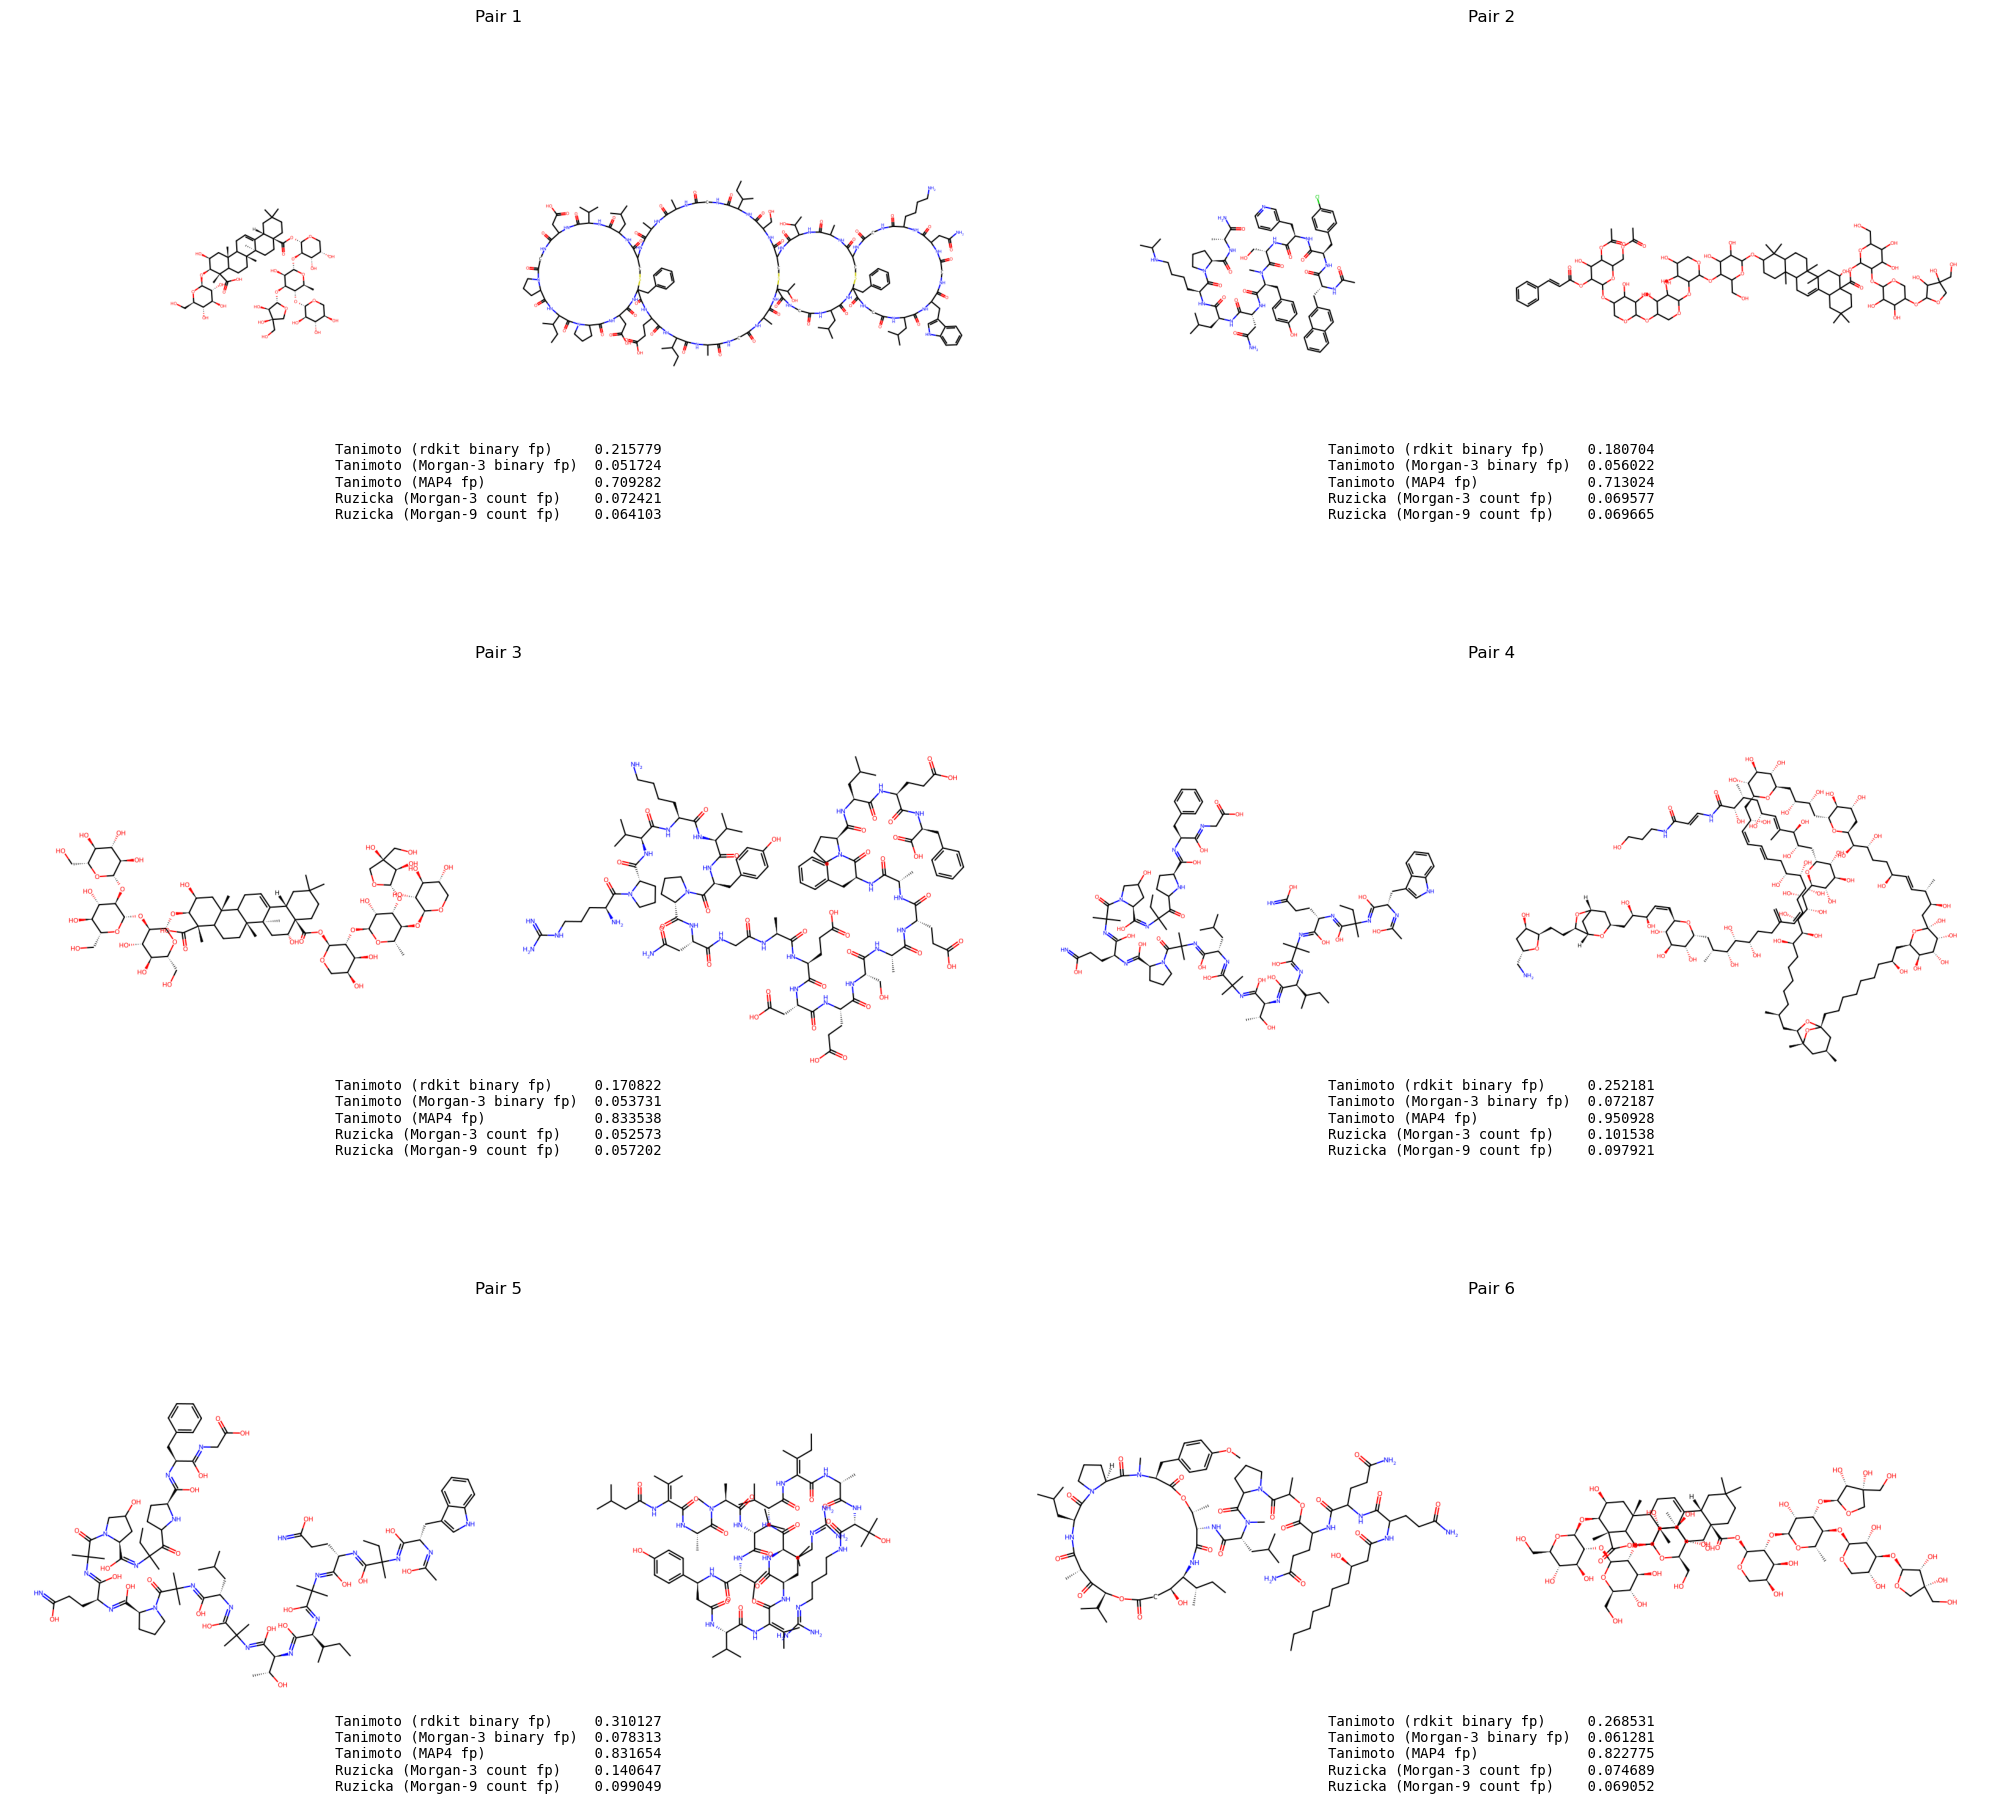

In [197]:
show_pairs_in_grid(selected_pairs_low1245_high3 , ncols=2, figsize=(20, 20),
                   filename="selected_pairs_low1245_high3.png"
                  )

In [155]:
idx = np.where((similarities_morgan3_count > 0.8) \
               & (similarities_morgan3 < 0.4) \
               #& (similarities_map4 > 0.5)
              )
idx[0].shape

(14,)

In [149]:
idx = np.where((similarities_morgan3_count > 0.9) \
               #& (similarities_morgan3 < 0.2) \
               & (similarities_map4 < 0.4)
              )
idx[0].shape

(240,)

In [145]:
# idx = np.where(np.abs(similarities_morgan3_count - similarities_morgan3) > 0.5) 
idx = np.where(((similarities_morgan3_count - similarities_morgan3) < -0.5) \
               & (similarities_map4 > 0.5)
              ) 
idx[0].shape

(18,)

In [172]:
# MANUAL CURATION!
selected_pairs_high12_low345 = [(769, 13201), (40, 36045), (11277, 11759),
                                (629, 4118), (709, 25756),
                                (279, 17156), (161, 27494)
                               ]

selected_pairs_high1245_low3 = [(3746, 7282), (1787, 22304), (4509, 36134)]

selected_pairs_low123_high45 = [(1151, 37592), (1398, 16827)]

selected_pairs_low1245_high3 = [(206, 28321), (562, 24300), (24440, 37563), (1495, 4507), (1495, 10679), (12197, 30695)]

Score
Tanimoto (rdkit binary fp)     0.215779
Tanimoto (Morgan-3 binary fp)  0.051724
Tanimoto (MAP4 fp)             0.709282
Ruzicka (Morgan-3 count fp)    0.072421
Ruzicka (Morgan-9 count fp)    0.064103

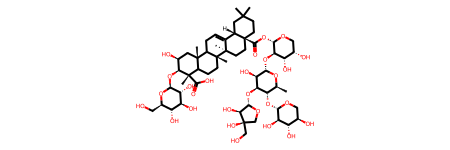

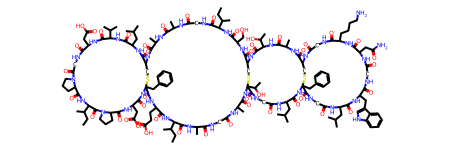

Score
Tanimoto (rdkit binary fp)     0.180704
Tanimoto (Morgan-3 binary fp)  0.056022
Tanimoto (MAP4 fp)             0.713024
Ruzicka (Morgan-3 count fp)    0.069577
Ruzicka (Morgan-9 count fp)    0.069665

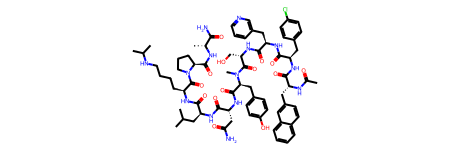

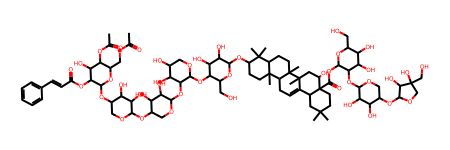

Score
Tanimoto (rdkit binary fp)     0.170822
Tanimoto (Morgan-3 binary fp)  0.053731
Tanimoto (MAP4 fp)             0.833538
Ruzicka (Morgan-3 count fp)    0.052573
Ruzicka (Morgan-9 count fp)    0.057202

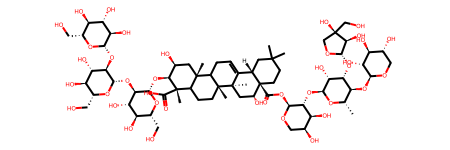

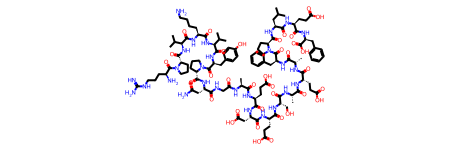

Score
Tanimoto (rdkit binary fp)     0.252181
Tanimoto (Morgan-3 binary fp)  0.072187
Tanimoto (MAP4 fp)             0.950928
Ruzicka (Morgan-3 count fp)    0.101538
Ruzicka (Morgan-9 count fp)    0.097921

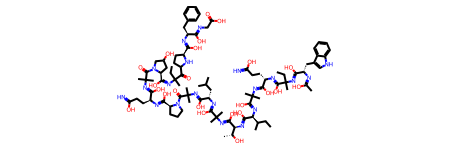

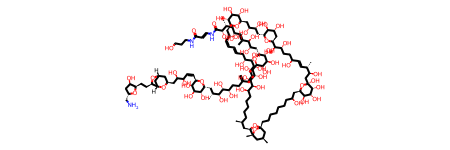

Score
Tanimoto (rdkit binary fp)     0.310127
Tanimoto (Morgan-3 binary fp)  0.078313
Tanimoto (MAP4 fp)             0.831654
Ruzicka (Morgan-3 count fp)    0.140647
Ruzicka (Morgan-9 count fp)    0.099049

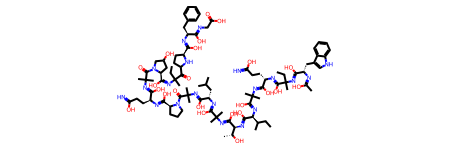

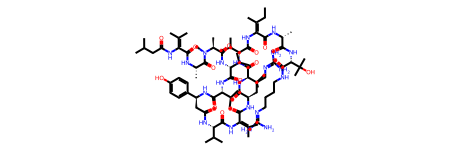

Score
Tanimoto (rdkit binary fp)     0.268531
Tanimoto (Morgan-3 binary fp)  0.061281
Tanimoto (MAP4 fp)             0.822775
Ruzicka (Morgan-3 count fp)    0.074689
Ruzicka (Morgan-9 count fp)    0.069052

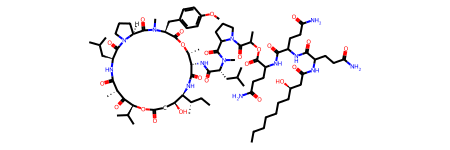

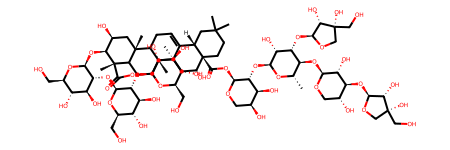

In [173]:
show_pairs(selected_pairs_low1245_high3)

In [156]:
pairs = list(zip(idx[0], idx[1]))
unique_pairs = set()
for pair in pairs[-20:]:
    sorted_pair = tuple(sorted(pair))
    unique_pairs.add(sorted_pair)
unique_pairs = list(unique_pairs)

unique_pairs

[(np.int64(7802), np.int64(19399)),
 (np.int64(13583), np.int64(36929)),
 (np.int64(13583), np.int64(34813)),
 (np.int64(14348), np.int64(27667)),
 (np.int64(15598), np.int64(21778)),
 (np.int64(13741), np.int64(15598)),
 (np.int64(11075), np.int64(13579))]

Score
Tanimoto (rdkit binary fp)     0.753149
Tanimoto (Morgan-3 binary fp)  0.393258
Tanimoto (MAP4 fp)             0.479381
Ruzicka (Morgan-3 count fp)    0.821538
Ruzicka (Morgan-9 count fp)    0.666012

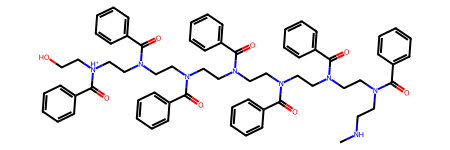

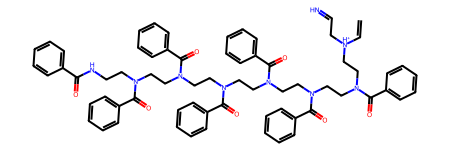

Score
Tanimoto (rdkit binary fp)     1.000000
Tanimoto (Morgan-3 binary fp)  0.315789
Tanimoto (MAP4 fp)             0.424150
Ruzicka (Morgan-3 count fp)    0.816456
Ruzicka (Morgan-9 count fp)    0.719595

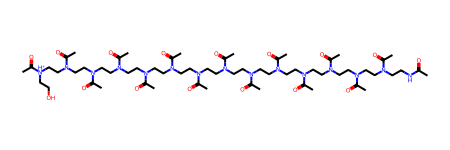

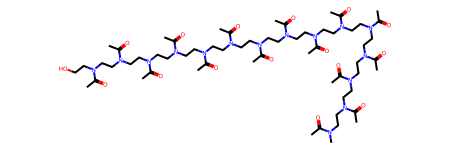

Score
Tanimoto (rdkit binary fp)     1.000000
Tanimoto (Morgan-3 binary fp)  0.315789
Tanimoto (MAP4 fp)             0.416796
Ruzicka (Morgan-3 count fp)    0.831683
Ruzicka (Morgan-9 count fp)    0.748663

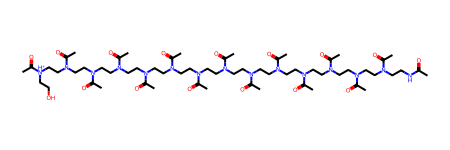

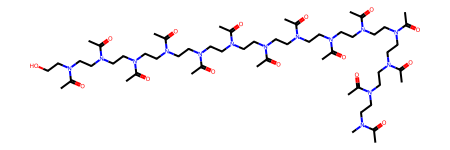

Score
Tanimoto (rdkit binary fp)     0.872180
Tanimoto (Morgan-3 binary fp)  0.367347
Tanimoto (MAP4 fp)             0.433735
Ruzicka (Morgan-3 count fp)    0.805970
Ruzicka (Morgan-9 count fp)    0.677686

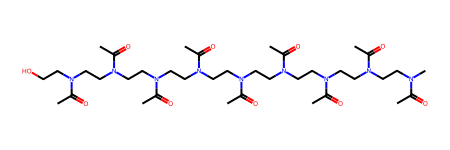

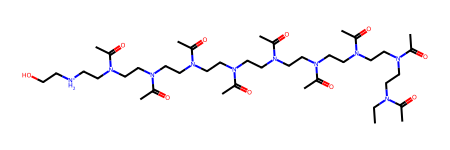

Score
Tanimoto (rdkit binary fp)     0.872180
Tanimoto (Morgan-3 binary fp)  0.367347
Tanimoto (MAP4 fp)             0.439153
Ruzicka (Morgan-3 count fp)    0.802575
Ruzicka (Morgan-9 count fp)    0.706161

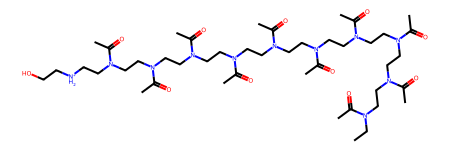

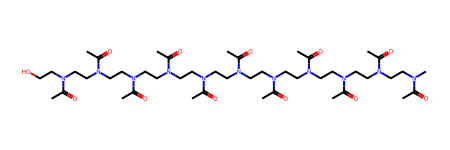

Score
Tanimoto (rdkit binary fp)     0.872180
Tanimoto (Morgan-3 binary fp)  0.367347
Tanimoto (MAP4 fp)             0.436863
Ruzicka (Morgan-3 count fp)    0.822727
Ruzicka (Morgan-9 count fp)    0.707500

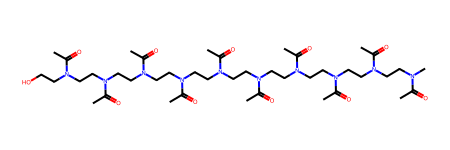

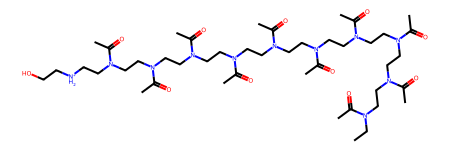

Score
Tanimoto (rdkit binary fp)     1.000000
Tanimoto (Morgan-3 binary fp)  0.315789
Tanimoto (MAP4 fp)             0.403356
Ruzicka (Morgan-3 count fp)    0.807547
Ruzicka (Morgan-9 count fp)    0.710472

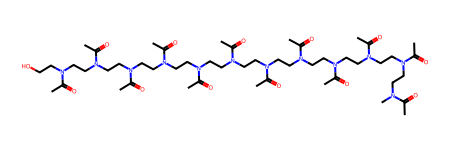

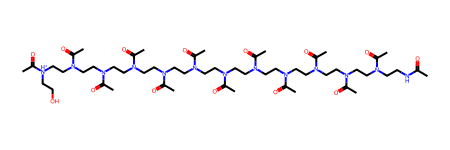

In [157]:
show_pairs(unique_pairs)

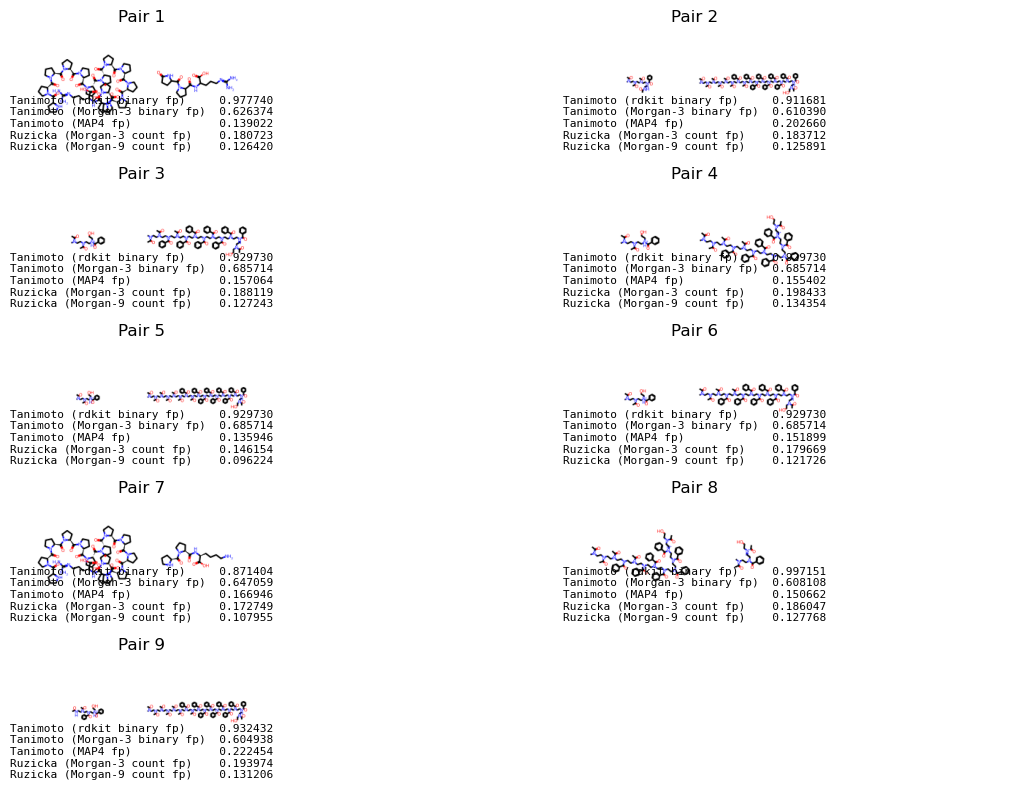

In [97]:
show_pairs_in_grid(unique_pairs, ncols=2, figsize=(12, 8))

In [169]:
idx = np.where((similarities_morgan9_count < 0.1) \
               & (similarities_map4 > 0.9))
idx[0].shape

(28,)

In [170]:
pairs = list(zip(idx[0], idx[1]))
unique_pairs = set()
for pair in pairs[:20]:
    sorted_pair = tuple(sorted(pair))
    unique_pairs.add(sorted_pair)
unique_pairs = list(unique_pairs)
unique_pairs

[(np.int64(9321), np.int64(26444)),
 (np.int64(18571), np.int64(18953)),
 (np.int64(1495), np.int64(26444)),
 (np.int64(18953), np.int64(37563)),
 (np.int64(640), np.int64(4507)),
 (np.int64(18953), np.int64(28321)),
 (np.int64(640), np.int64(26444)),
 (np.int64(4507), np.int64(29874)),
 (np.int64(1495), np.int64(18953)),
 (np.int64(4507), np.int64(32709)),
 (np.int64(1495), np.int64(4507)),
 (np.int64(4507), np.int64(9321))]

Score
Tanimoto (rdkit binary fp)     0.275211
Tanimoto (Morgan-3 binary fp)  0.065217
Tanimoto (MAP4 fp)             0.904297
Ruzicka (Morgan-3 count fp)    0.070825
Ruzicka (Morgan-9 count fp)    0.093333

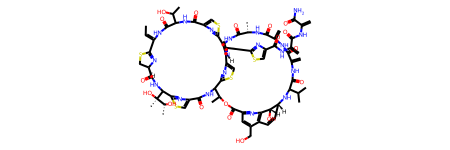

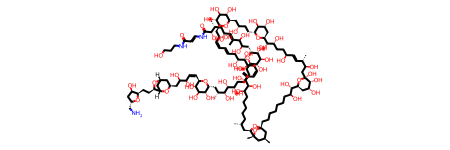

Score
Tanimoto (rdkit binary fp)     0.191375
Tanimoto (Morgan-3 binary fp)  0.046392
Tanimoto (MAP4 fp)             0.914160
Ruzicka (Morgan-3 count fp)    0.039572
Ruzicka (Morgan-9 count fp)    0.059548

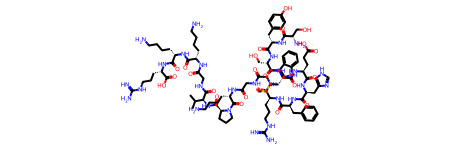

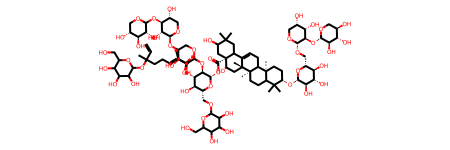

Score
Tanimoto (rdkit binary fp)     0.253128
Tanimoto (Morgan-3 binary fp)  0.069182
Tanimoto (MAP4 fp)             0.950427
Ruzicka (Morgan-3 count fp)    0.101957
Ruzicka (Morgan-9 count fp)    0.095186

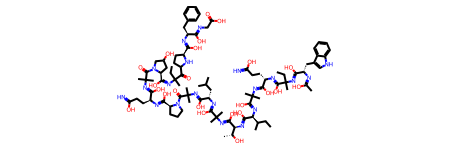

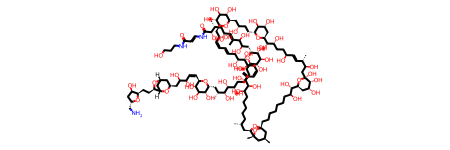

Score
Tanimoto (rdkit binary fp)     0.168200
Tanimoto (Morgan-3 binary fp)  0.048649
Tanimoto (MAP4 fp)             0.928379
Ruzicka (Morgan-3 count fp)    0.055499
Ruzicka (Morgan-9 count fp)    0.065380

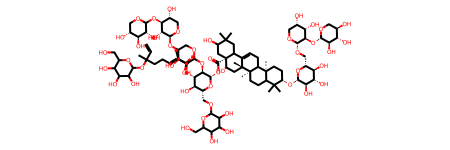

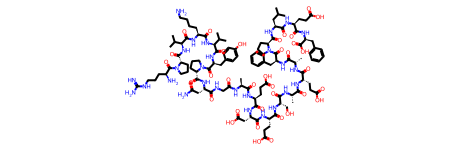

Score
Tanimoto (rdkit binary fp)     0.276673
Tanimoto (Morgan-3 binary fp)  0.055666
Tanimoto (MAP4 fp)             0.906006
Ruzicka (Morgan-3 count fp)    0.067016
Ruzicka (Morgan-9 count fp)    0.094731

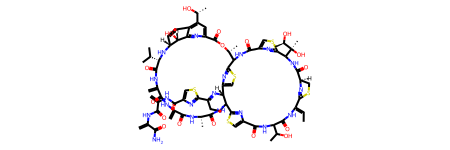

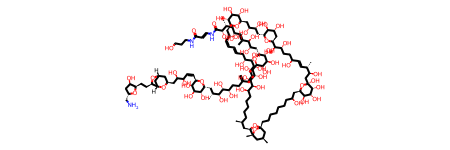

Score
Tanimoto (rdkit binary fp)     0.226991
Tanimoto (Morgan-3 binary fp)  0.058166
Tanimoto (MAP4 fp)             0.941866
Ruzicka (Morgan-3 count fp)    0.074957
Ruzicka (Morgan-9 count fp)    0.081823

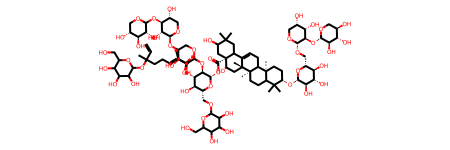

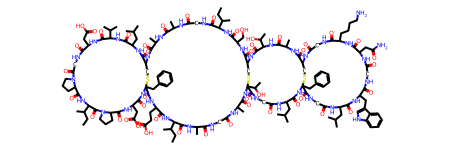

Score
Tanimoto (rdkit binary fp)     0.274153
Tanimoto (Morgan-3 binary fp)  0.061386
Tanimoto (MAP4 fp)             0.905029
Ruzicka (Morgan-3 count fp)    0.070675
Ruzicka (Morgan-9 count fp)    0.092070

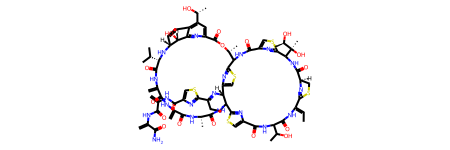

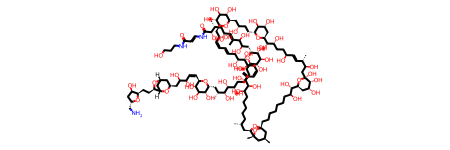

Score
Tanimoto (rdkit binary fp)     0.229583
Tanimoto (Morgan-3 binary fp)  0.066667
Tanimoto (MAP4 fp)             0.906006
Ruzicka (Morgan-3 count fp)    0.094496
Ruzicka (Morgan-9 count fp)    0.086587

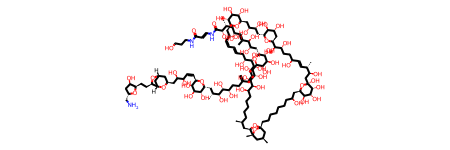

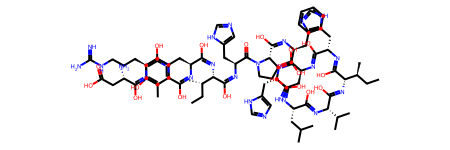

Score
Tanimoto (rdkit binary fp)     0.238367
Tanimoto (Morgan-3 binary fp)  0.074074
Tanimoto (MAP4 fp)             0.904820
Ruzicka (Morgan-3 count fp)    0.089157
Ruzicka (Morgan-9 count fp)    0.085926

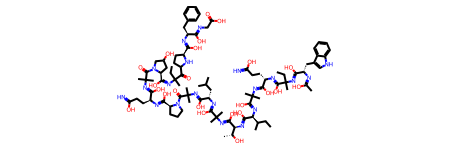

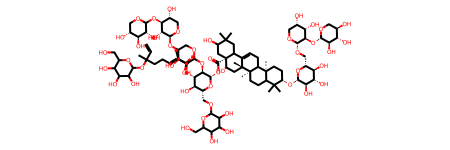

Score
Tanimoto (rdkit binary fp)     0.289791
Tanimoto (Morgan-3 binary fp)  0.062500
Tanimoto (MAP4 fp)             0.903053
Ruzicka (Morgan-3 count fp)    0.093586
Ruzicka (Morgan-9 count fp)    0.094402

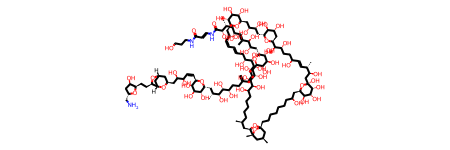

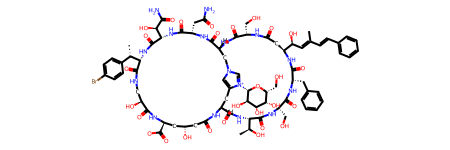

Score
Tanimoto (rdkit binary fp)     0.252181
Tanimoto (Morgan-3 binary fp)  0.072187
Tanimoto (MAP4 fp)             0.950928
Ruzicka (Morgan-3 count fp)    0.101538
Ruzicka (Morgan-9 count fp)    0.097921

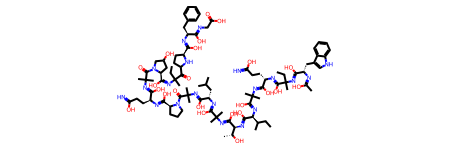

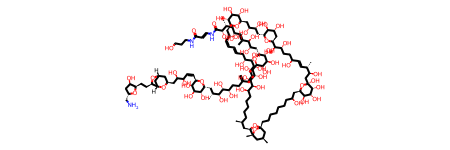

Score
Tanimoto (rdkit binary fp)     0.277746
Tanimoto (Morgan-3 binary fp)  0.059524
Tanimoto (MAP4 fp)             0.905273
Ruzicka (Morgan-3 count fp)    0.067156
Ruzicka (Morgan-9 count fp)    0.091923

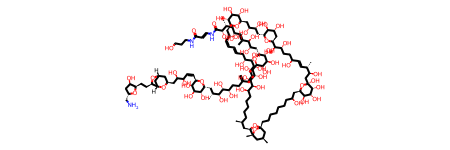

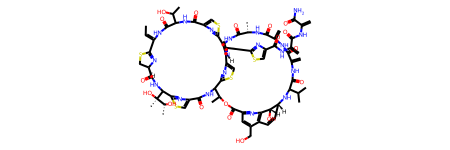

In [171]:
from rdkit import Chem
from rdkit.Chem import Draw


for pair in unique_pairs:
    display(get_score_summary(pair[0], pair[1]))

    smiles1 = compounds.smiles[indices_selected[pair[0]]]
    smiles2 = compounds.smiles[indices_selected[pair[1]]]
    mol = Chem.MolFromSmiles(smiles1)
    display(mol)
    mol = Chem.MolFromSmiles(smiles2)
    display(mol)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm


# try something less memory hungry


def hex_comparison(similarities1, similarities2, label1, label2, filename=None):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    
    # Compute the 2D histogram directly, without flattening
    hb = ax.hexbin(similarities1.ravel(), similarities2.ravel(),
                   gridsize=50,
                   cmap='viridis',
                   mincnt=1,
                   norm=LogNorm(),
                   zorder=2)
    
    # Add the grid
    ax.grid(True, zorder=1)
    
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('Count')
    
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    ax.set_aspect('equal', 'box')

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

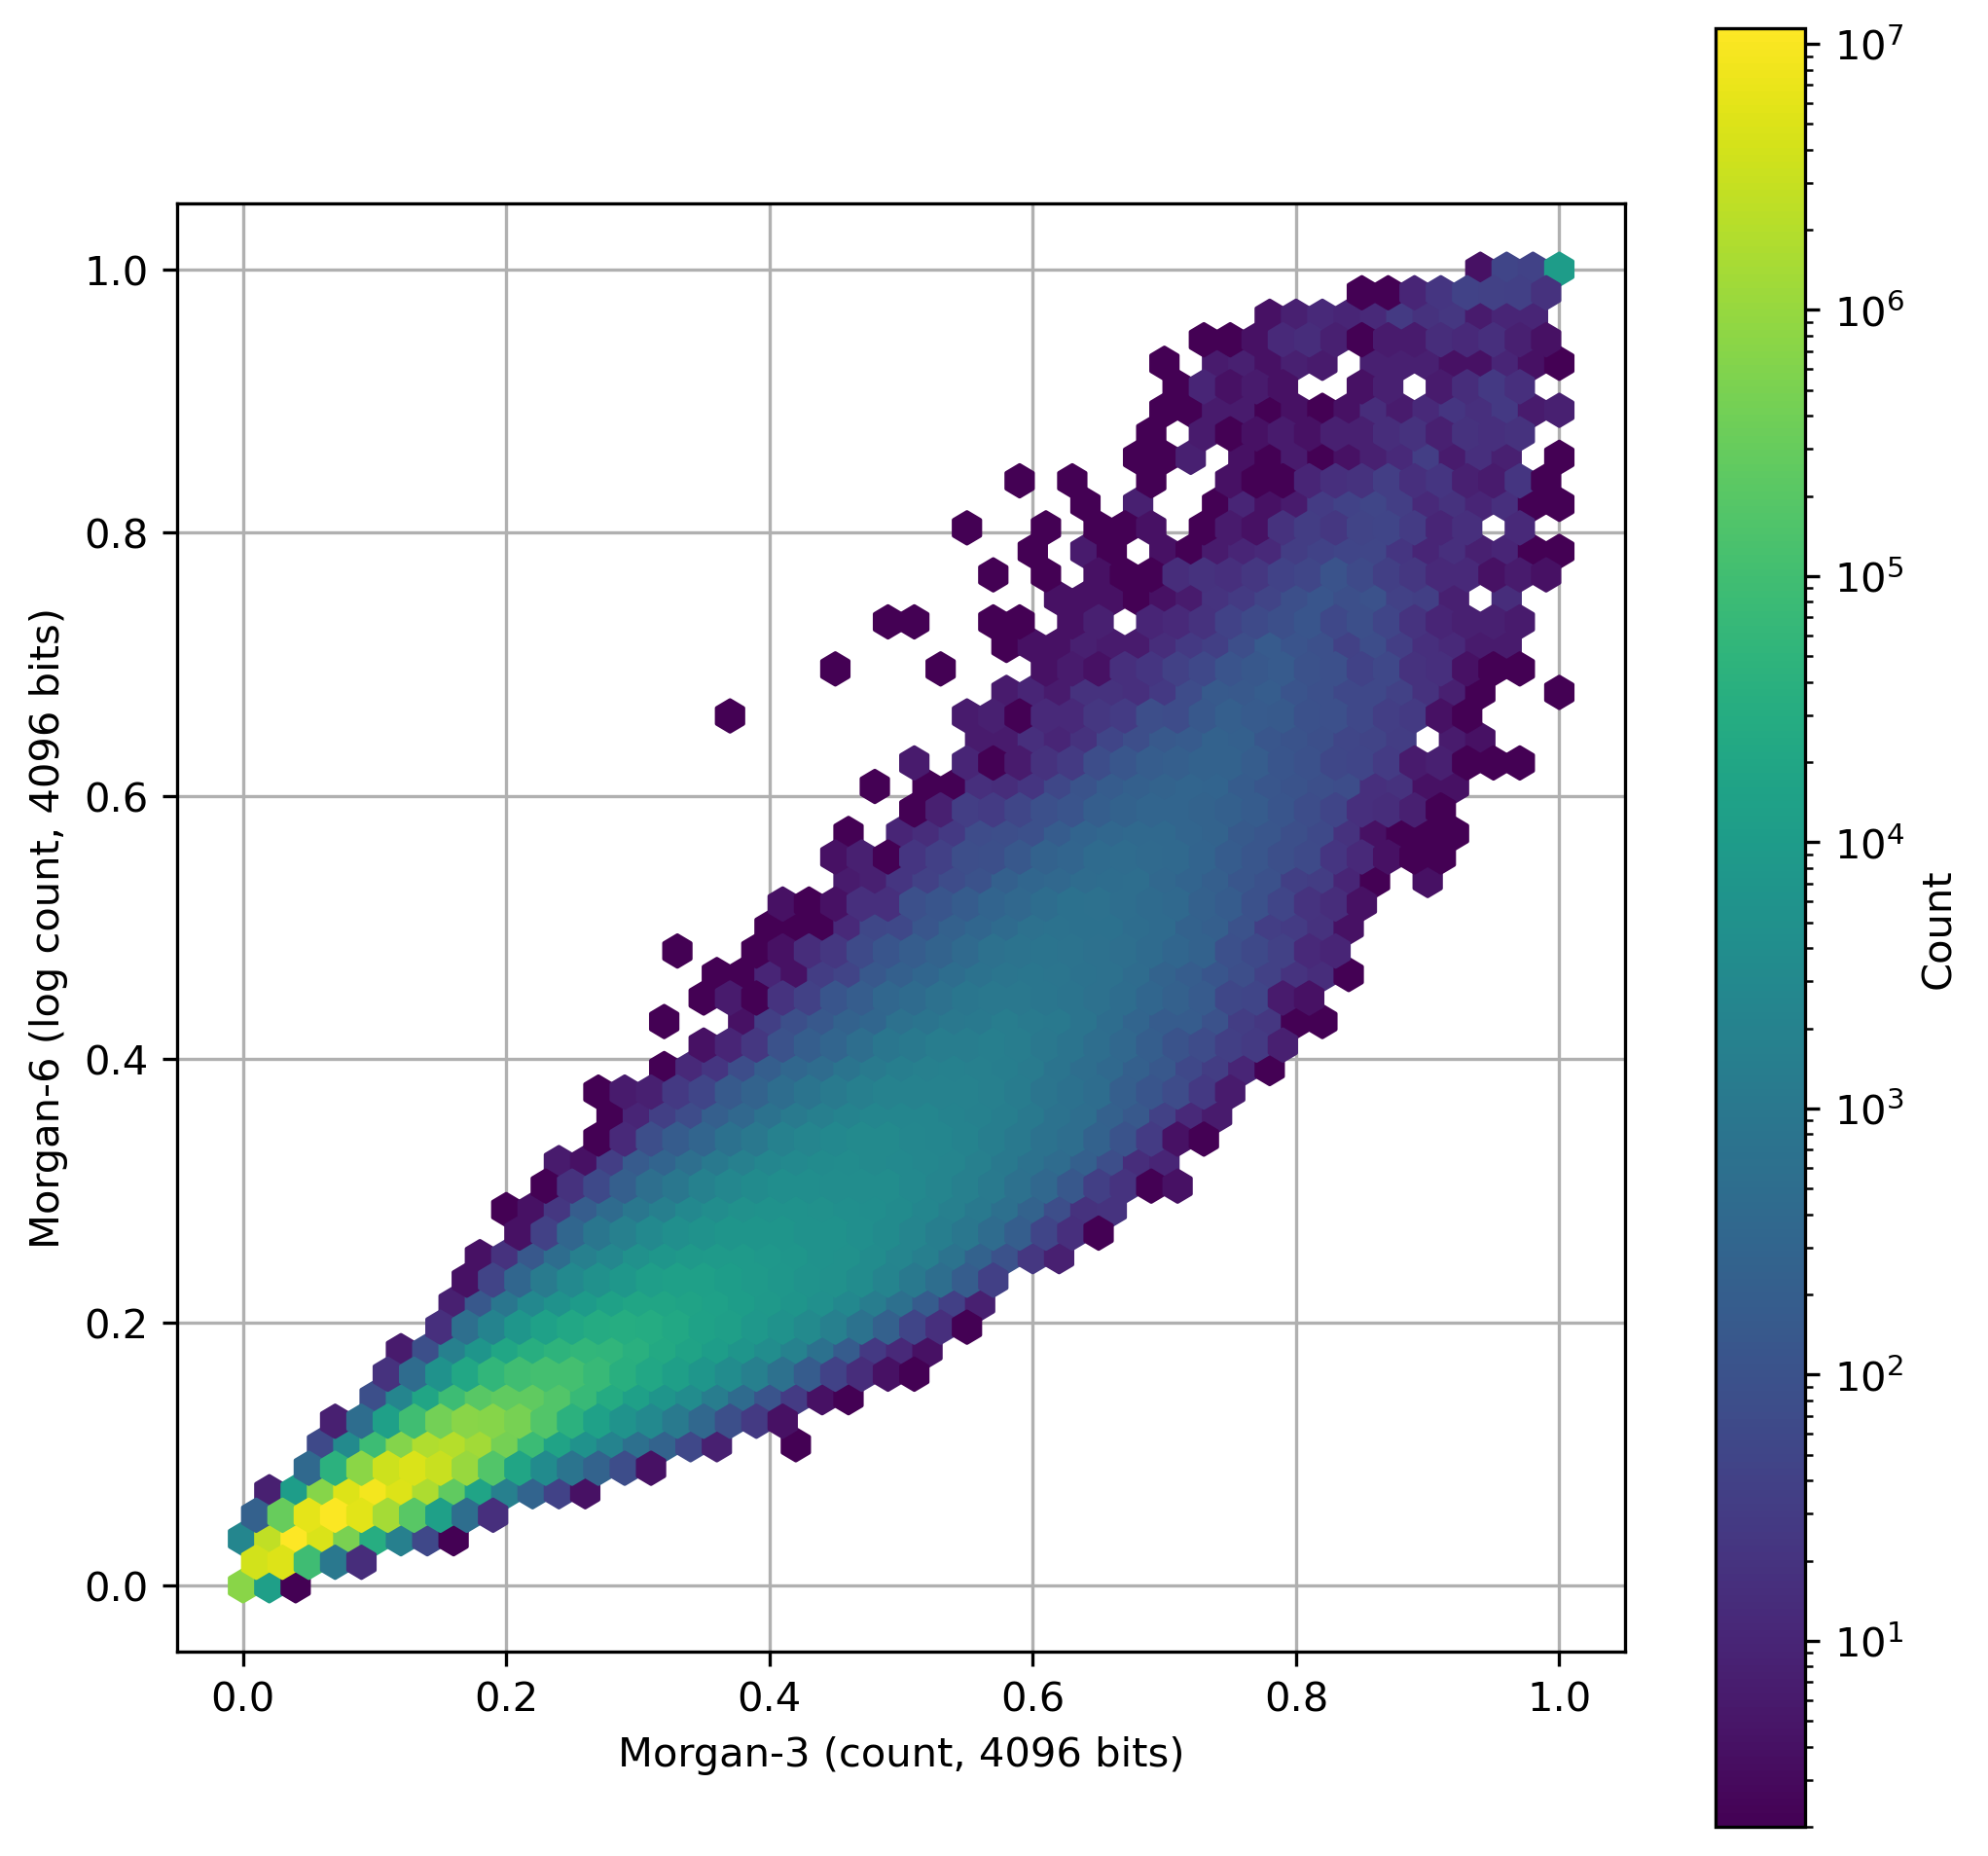

In [61]:
hex_comparison(
    similarities_count,
    similarities_count_morgan6_log,
    f"Morgan-3 (count, {NBITS} bits)",
    f"Morgan-6 (log count, {NBITS} bits)",
)

In [10]:
NBITS = 4096

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def contour_comparison(similarities1, similarities2, label1, label2, bins=100, filename=None):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    
    # Compute the 2D histogram with fewer bins to reduce memory usage
    hist, x_edges, y_edges = np.histogram2d(
        similarities1.ravel(), 
        similarities2.ravel(), 
        bins=bins
    )
    
    # Use contourf to plot the density as filled contours
    X, Y = np.meshgrid(x_edges, y_edges)
    cf = ax.contourf(X[:-1, :-1], Y[:-1, :-1], hist.T, 
                     levels=20, cmap='viridis', norm=LogNorm(), zorder=2)
    
    # Add colorbar
    cb = fig.colorbar(cf, ax=ax)
    cb.set_label('Count')
    
    # Add grid and labels
    ax.grid(True, zorder=1)
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    ax.set_aspect('equal', 'box')
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter

def smooth_contour_comparison(similarities1, similarities2, label1, label2, bins=100, sigma=0.5, filename=None):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    
    # Compute the 2D histogram
    hist, x_edges, y_edges = np.histogram2d(
        similarities1.ravel(), 
        similarities2.ravel(), 
        bins=bins
    )
    
    # Apply Gaussian smoothing to the histogram
    smoothed_hist = gaussian_filter(hist, sigma=sigma)
    
    # Define contour levels starting from 1 (actual counts)
    min_level = 1
    max_level = np.max(smoothed_hist)
    levels = np.logspace(np.log10(min_level), np.log10(max_level), num=50)
    
    # Use contourf to plot the smoothed density
    X, Y = np.meshgrid(x_edges, y_edges)
    cf = ax.contourf(X[:-1, :-1], Y[:-1, :-1], smoothed_hist.T, 
                     levels=levels, cmap='viridis', norm=LogNorm(vmin=min_level, vmax=max_level), zorder=2)
    
    # Add colorbar with rounded tick values
    cb = fig.colorbar(cf, ax=ax)
    tick_values = np.logspace(np.log10(min_level), np.log10(max_level), num=10)
    cb.set_ticks(tick_values)
    cb.set_ticklabels([f"{int(t):,}" for t in tick_values])  # Rounded and formatted as integers
    cb.set_label('Count')
    
    # Add grid and labels
    ax.grid(True, zorder=1)
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    ax.set_aspect('equal', 'box')
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()


/tmp/ipykernel_16416/4202724471.py:26: UserWarning: Log scale: values of z <= 0 have been masked
  cf = ax.contourf(X[:-1, :-1], Y[:-1, :-1], smoothed_hist.T,


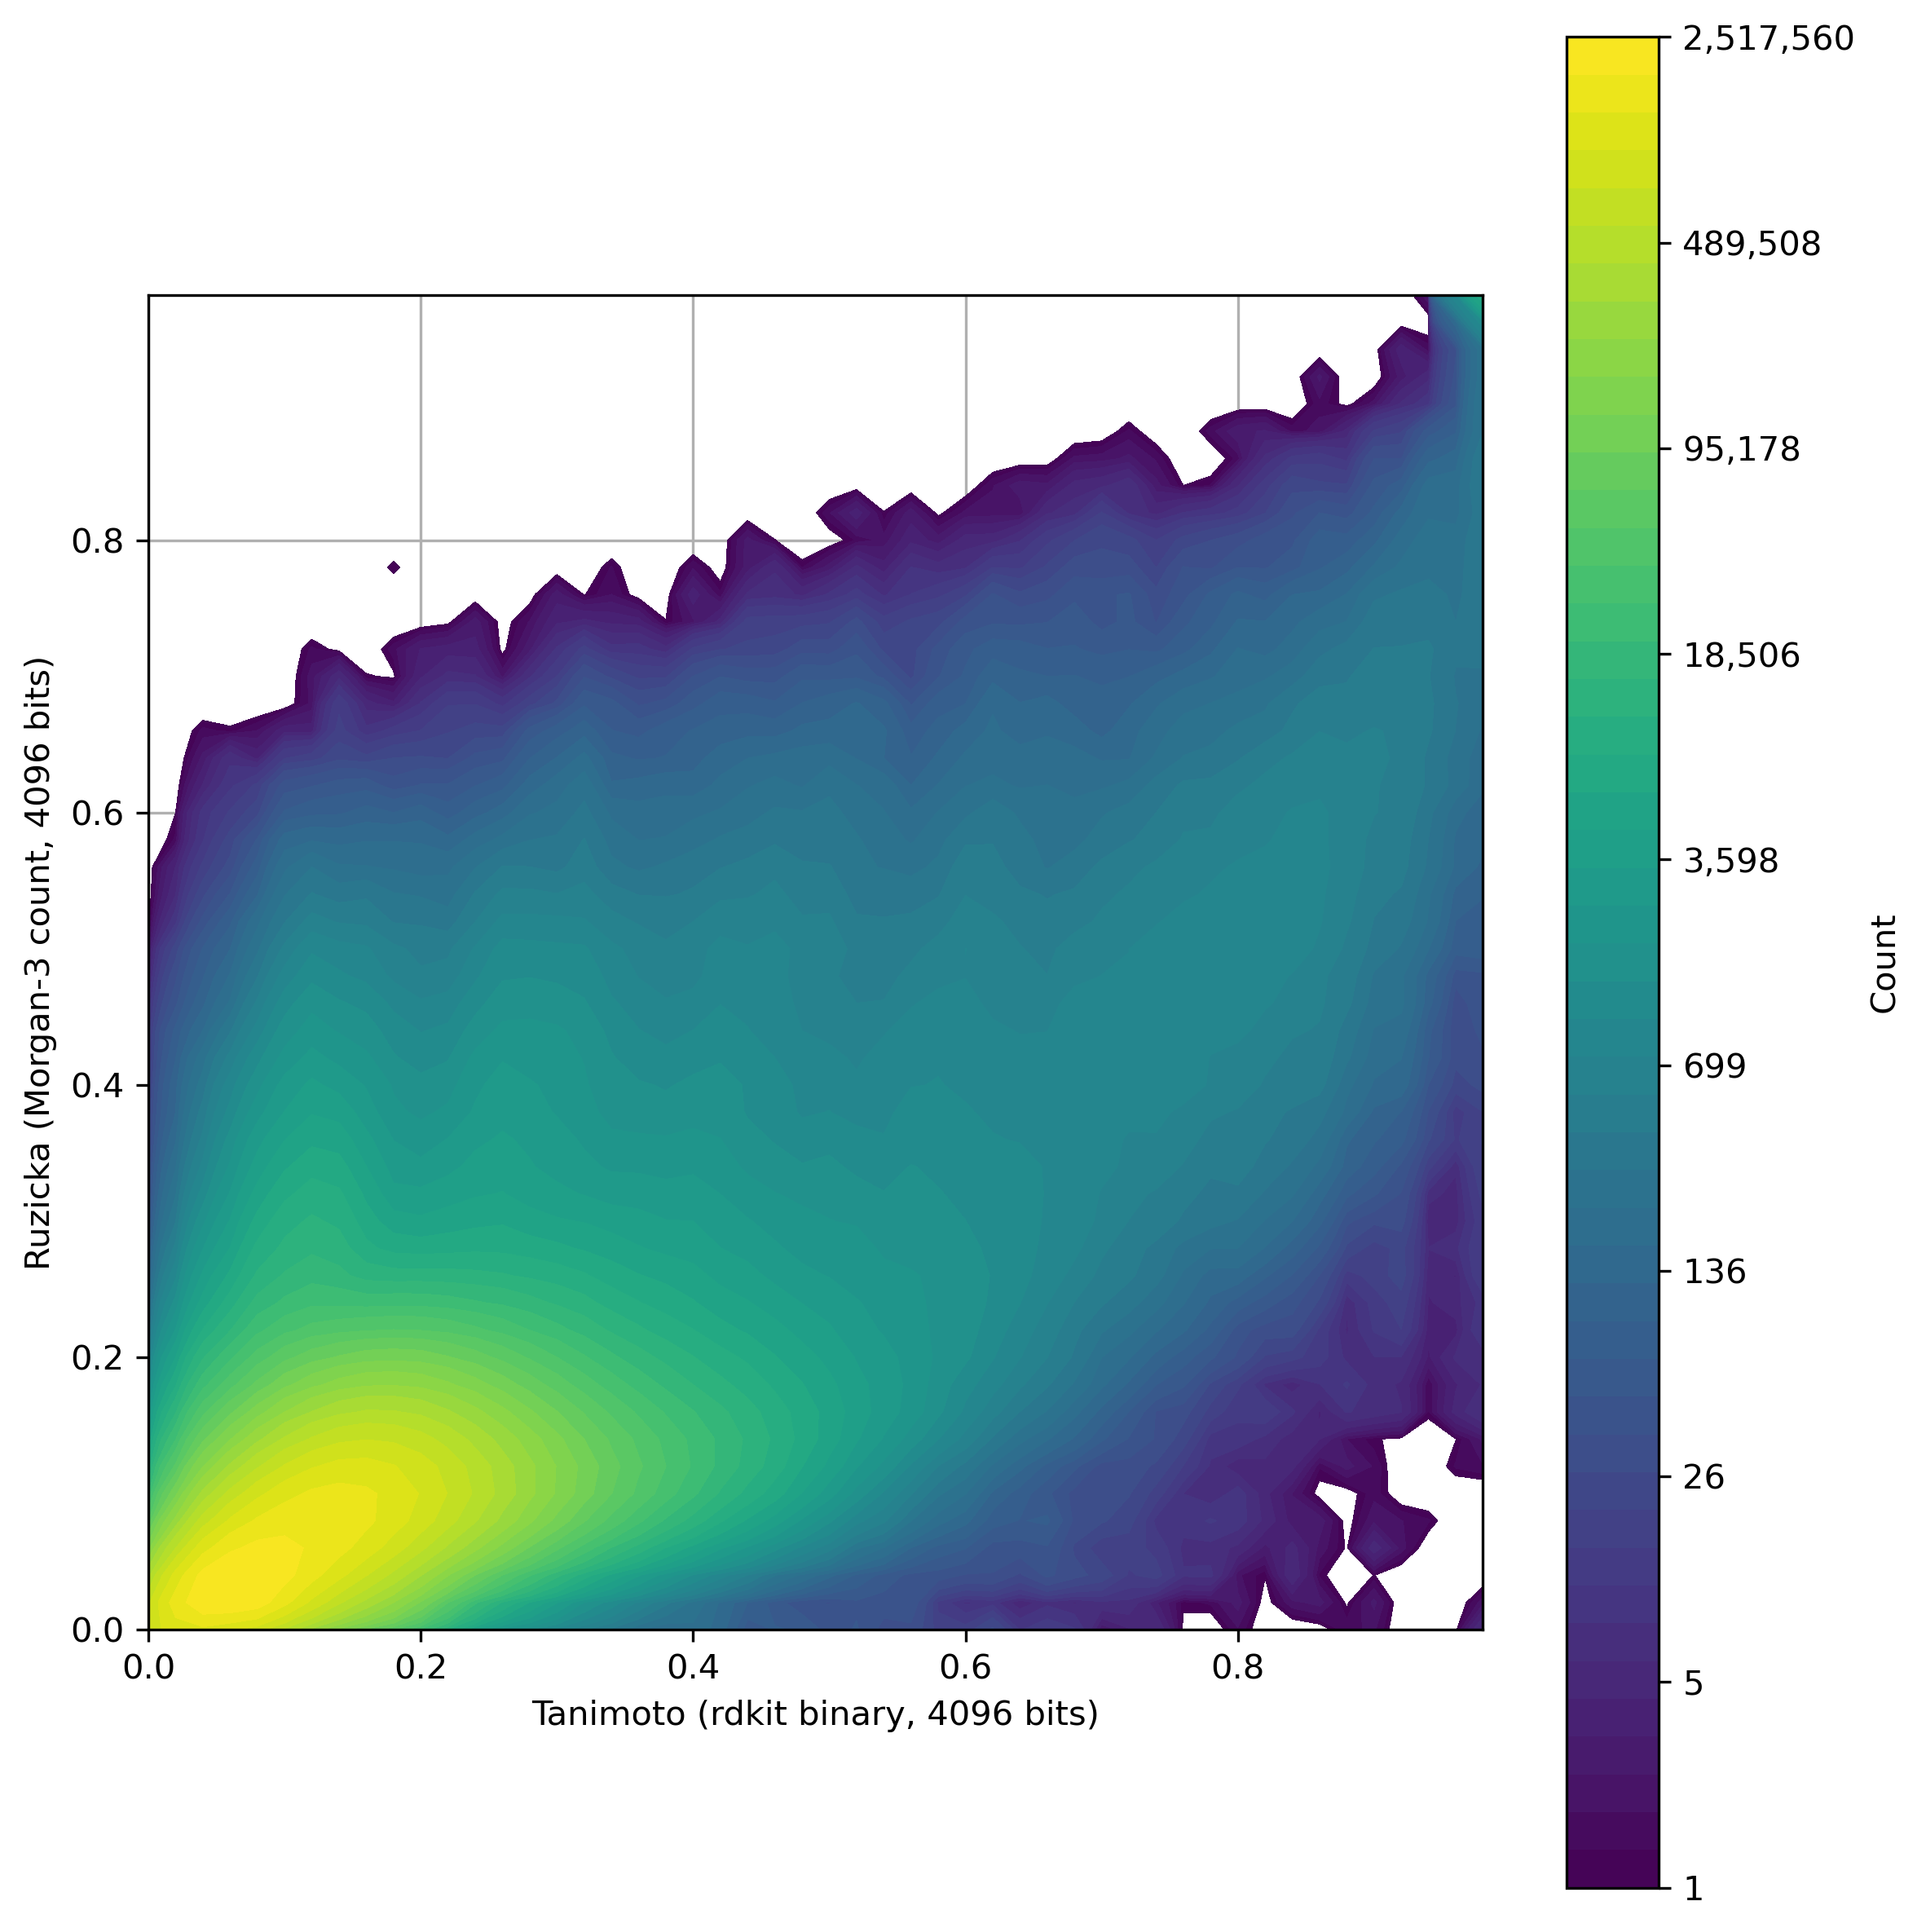

In [34]:
smooth_contour_comparison(
    similarities_classic[:10000, :10000],
    similarities_morgan3_count[:10000, :10000],
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    bins=50,
    filename="contourplot_tanimoto_rdkit_vs_ruzicka_morgan3.png"
)

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter

def heatmap_with_contours(similarities1, similarities2, label1, label2, bins=100, sigma=1, filename=None):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    
    # Compute the 2D histogram
    hist, x_edges, y_edges = np.histogram2d(
        similarities1.ravel(), 
        similarities2.ravel(), 
        bins=bins
    )
    
    # Display the heatmap using imshow with logarithmic color scale
    im = ax.imshow(hist.T, origin='lower', aspect='equal',
                   extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                   cmap='viridis', alpha=0.9, norm=LogNorm(vmin=1, vmax=np.max(hist)))
    
    # Add colorbar with proper tick formatting
    cb = fig.colorbar(im, ax=ax)
    cb.set_label('Count')
    
    # Apply Gaussian smoothing for smoother contours
    smoothed_hist = gaussian_filter(hist, sigma=sigma)
    
    # Create contour lines with the same colormap as the heatmap
    X, Y = np.meshgrid(x_edges, y_edges)
    levels = np.logspace(0, np.log10(np.max(smoothed_hist)), num=10)

    contour = ax.contour(X[:-1, :-1], Y[:-1, :-1], smoothed_hist.T, 
                         levels=levels, cmap='viridis', norm=LogNorm(vmin=1, vmax=np.max(hist)), 
                         linewidths=1.5, alpha=1.0)
    
    # Add grid and labels
    ax.grid(True, zorder=1)
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()


/tmp/ipykernel_16416/3092145610.py:31: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(X[:-1, :-1], Y[:-1, :-1], smoothed_hist.T,
/tmp/ipykernel_16416/3092145610.py:31: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X[:-1, :-1], Y[:-1, :-1], smoothed_hist.T,
/tmp/ipykernel_16416/3092145610.py:34: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contour(X[:-1, :-1], Y[:-1, :-1], smoothed_hist.T,
/tmp/ipykernel_16416/3092145610.py:34: UserWarning: The following kwargs were not used by contour: 'linestyle'
  contour = ax.contour(X[:-1, :-1], Y[:-1, :-1], smoothed_hist.T,


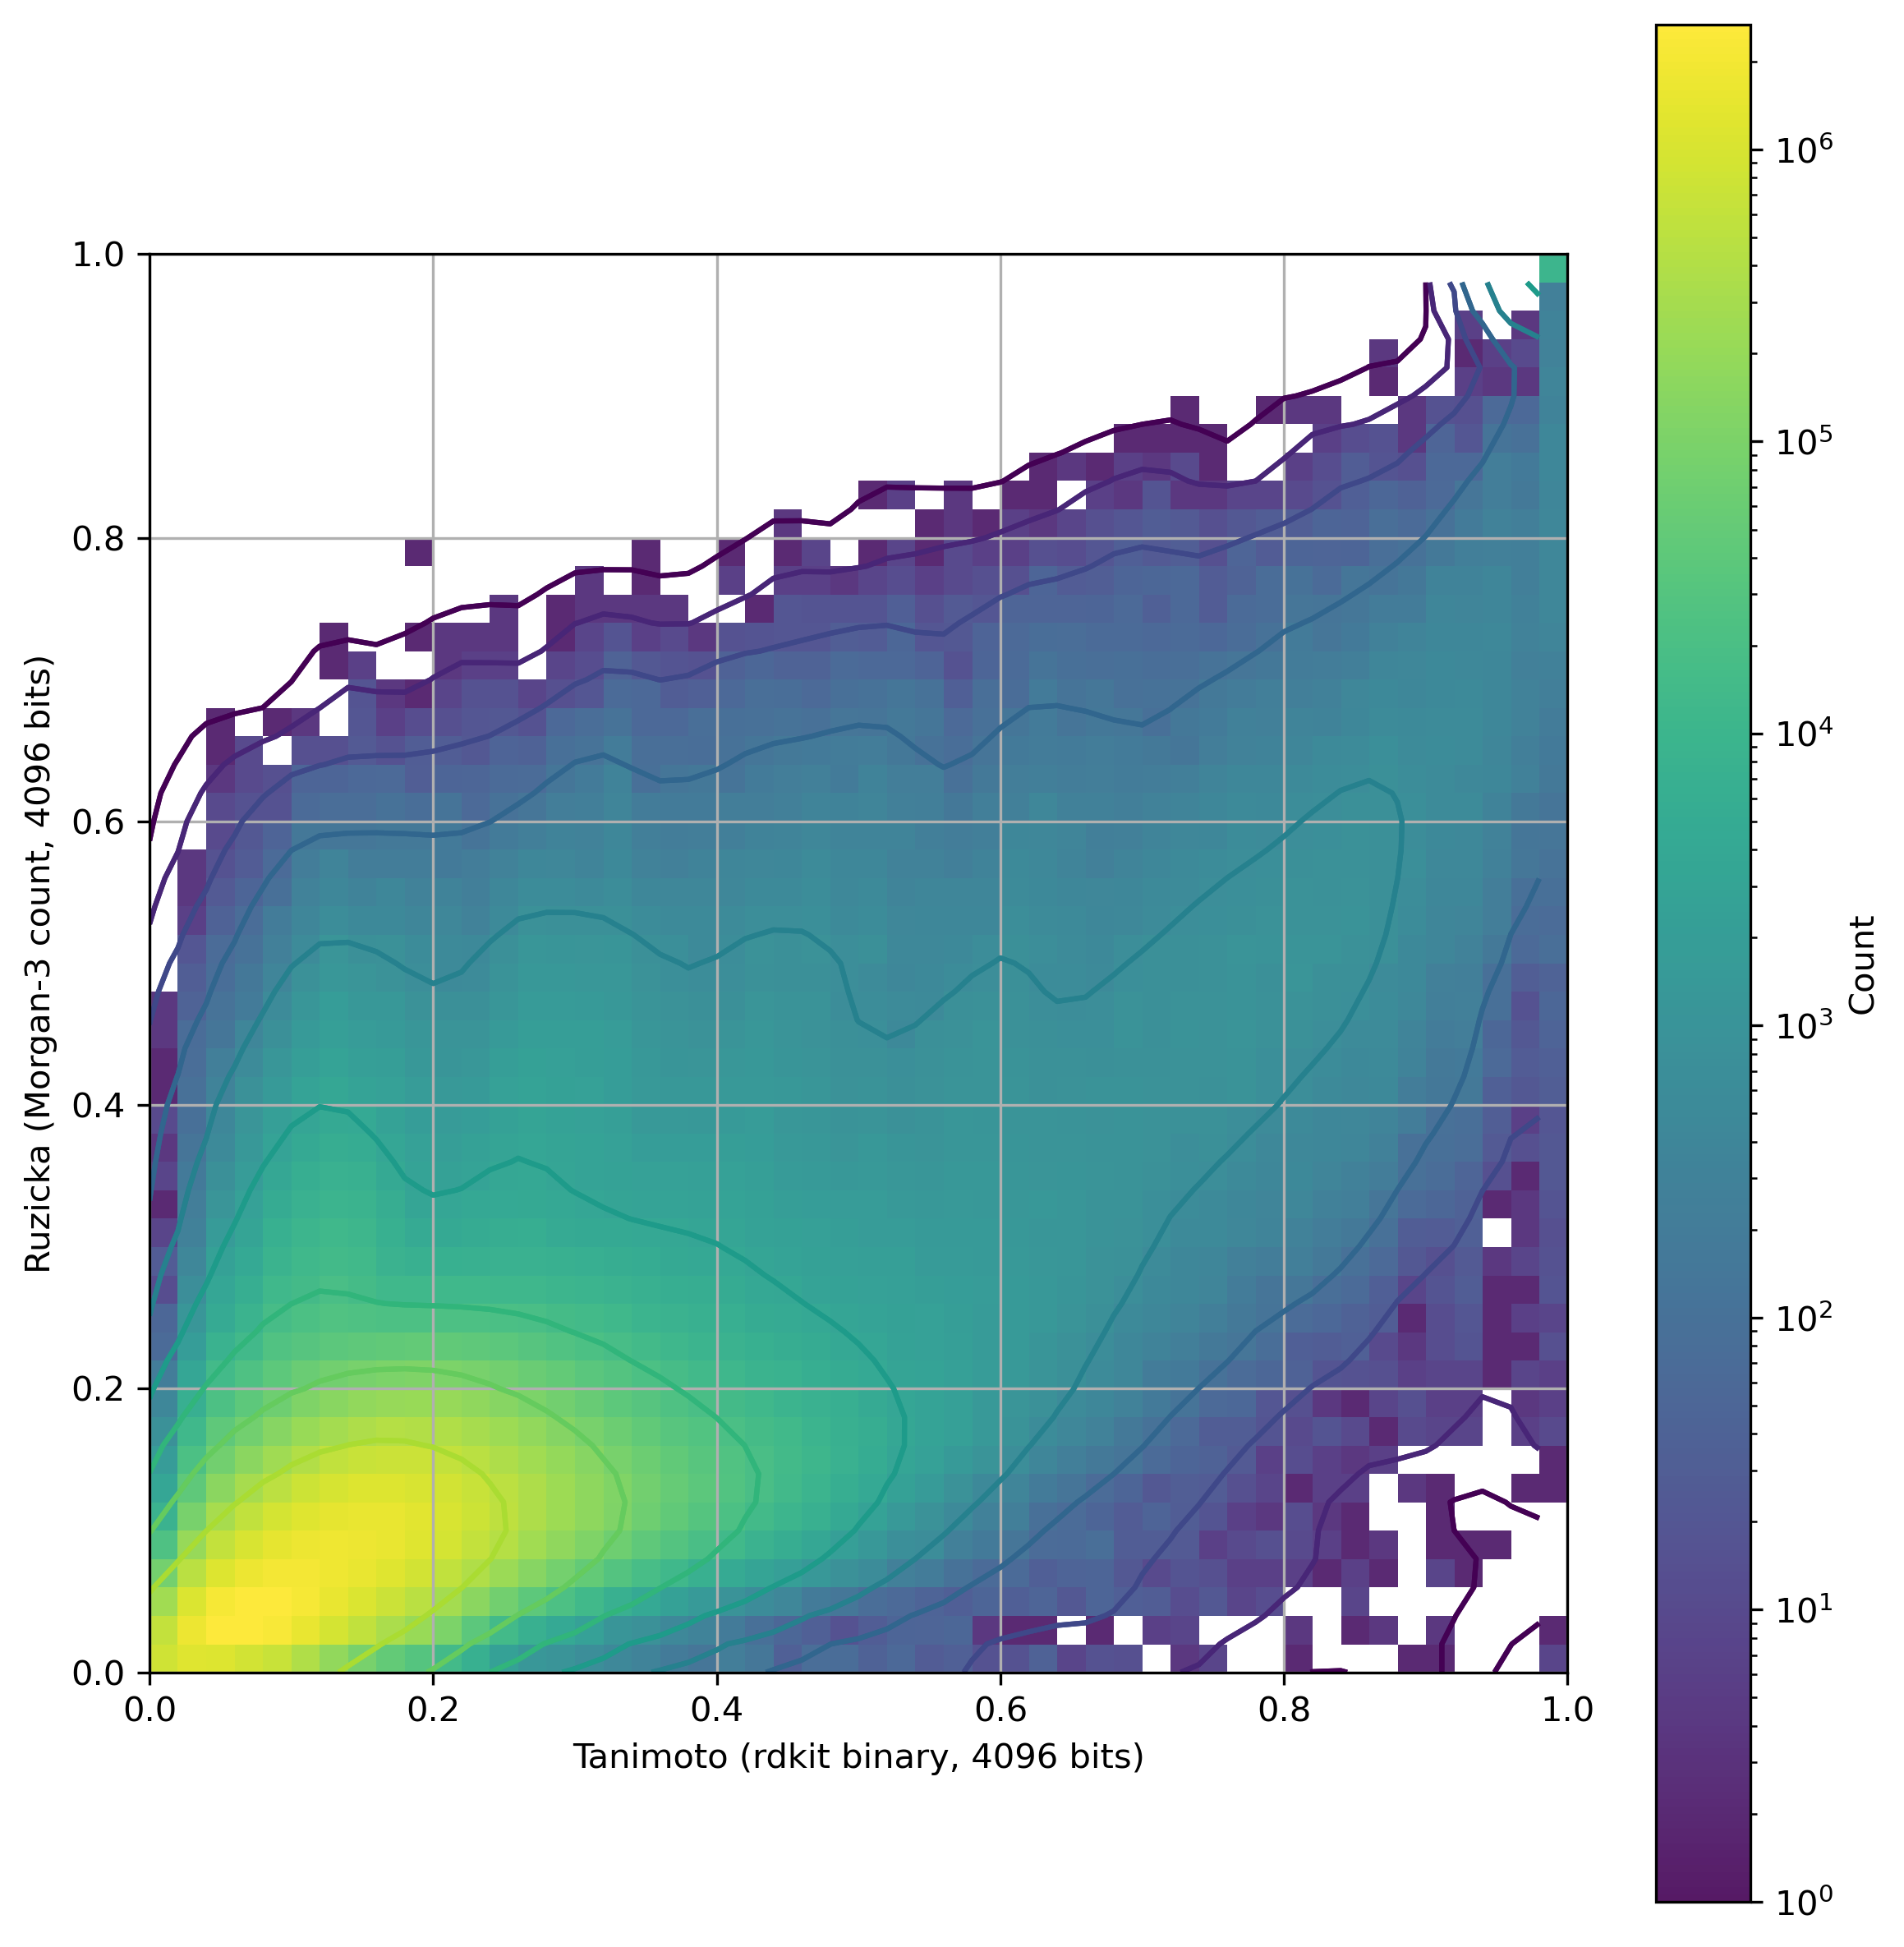

In [54]:
heatmap_with_contours(
    similarities_classic[:10000, :10000],
    similarities_morgan3_count[:10000, :10000],
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    bins=50,
    filename="heatmap_tanimoto_rdkit_vs_ruzicka_morgan3.png"
)

/tmp/ipykernel_16416/3681283330.py:17: UserWarning: Log scale: values of z <= 0 have been masked
  cf = ax.contourf(X[:-1, :-1], Y[:-1, :-1], hist.T,


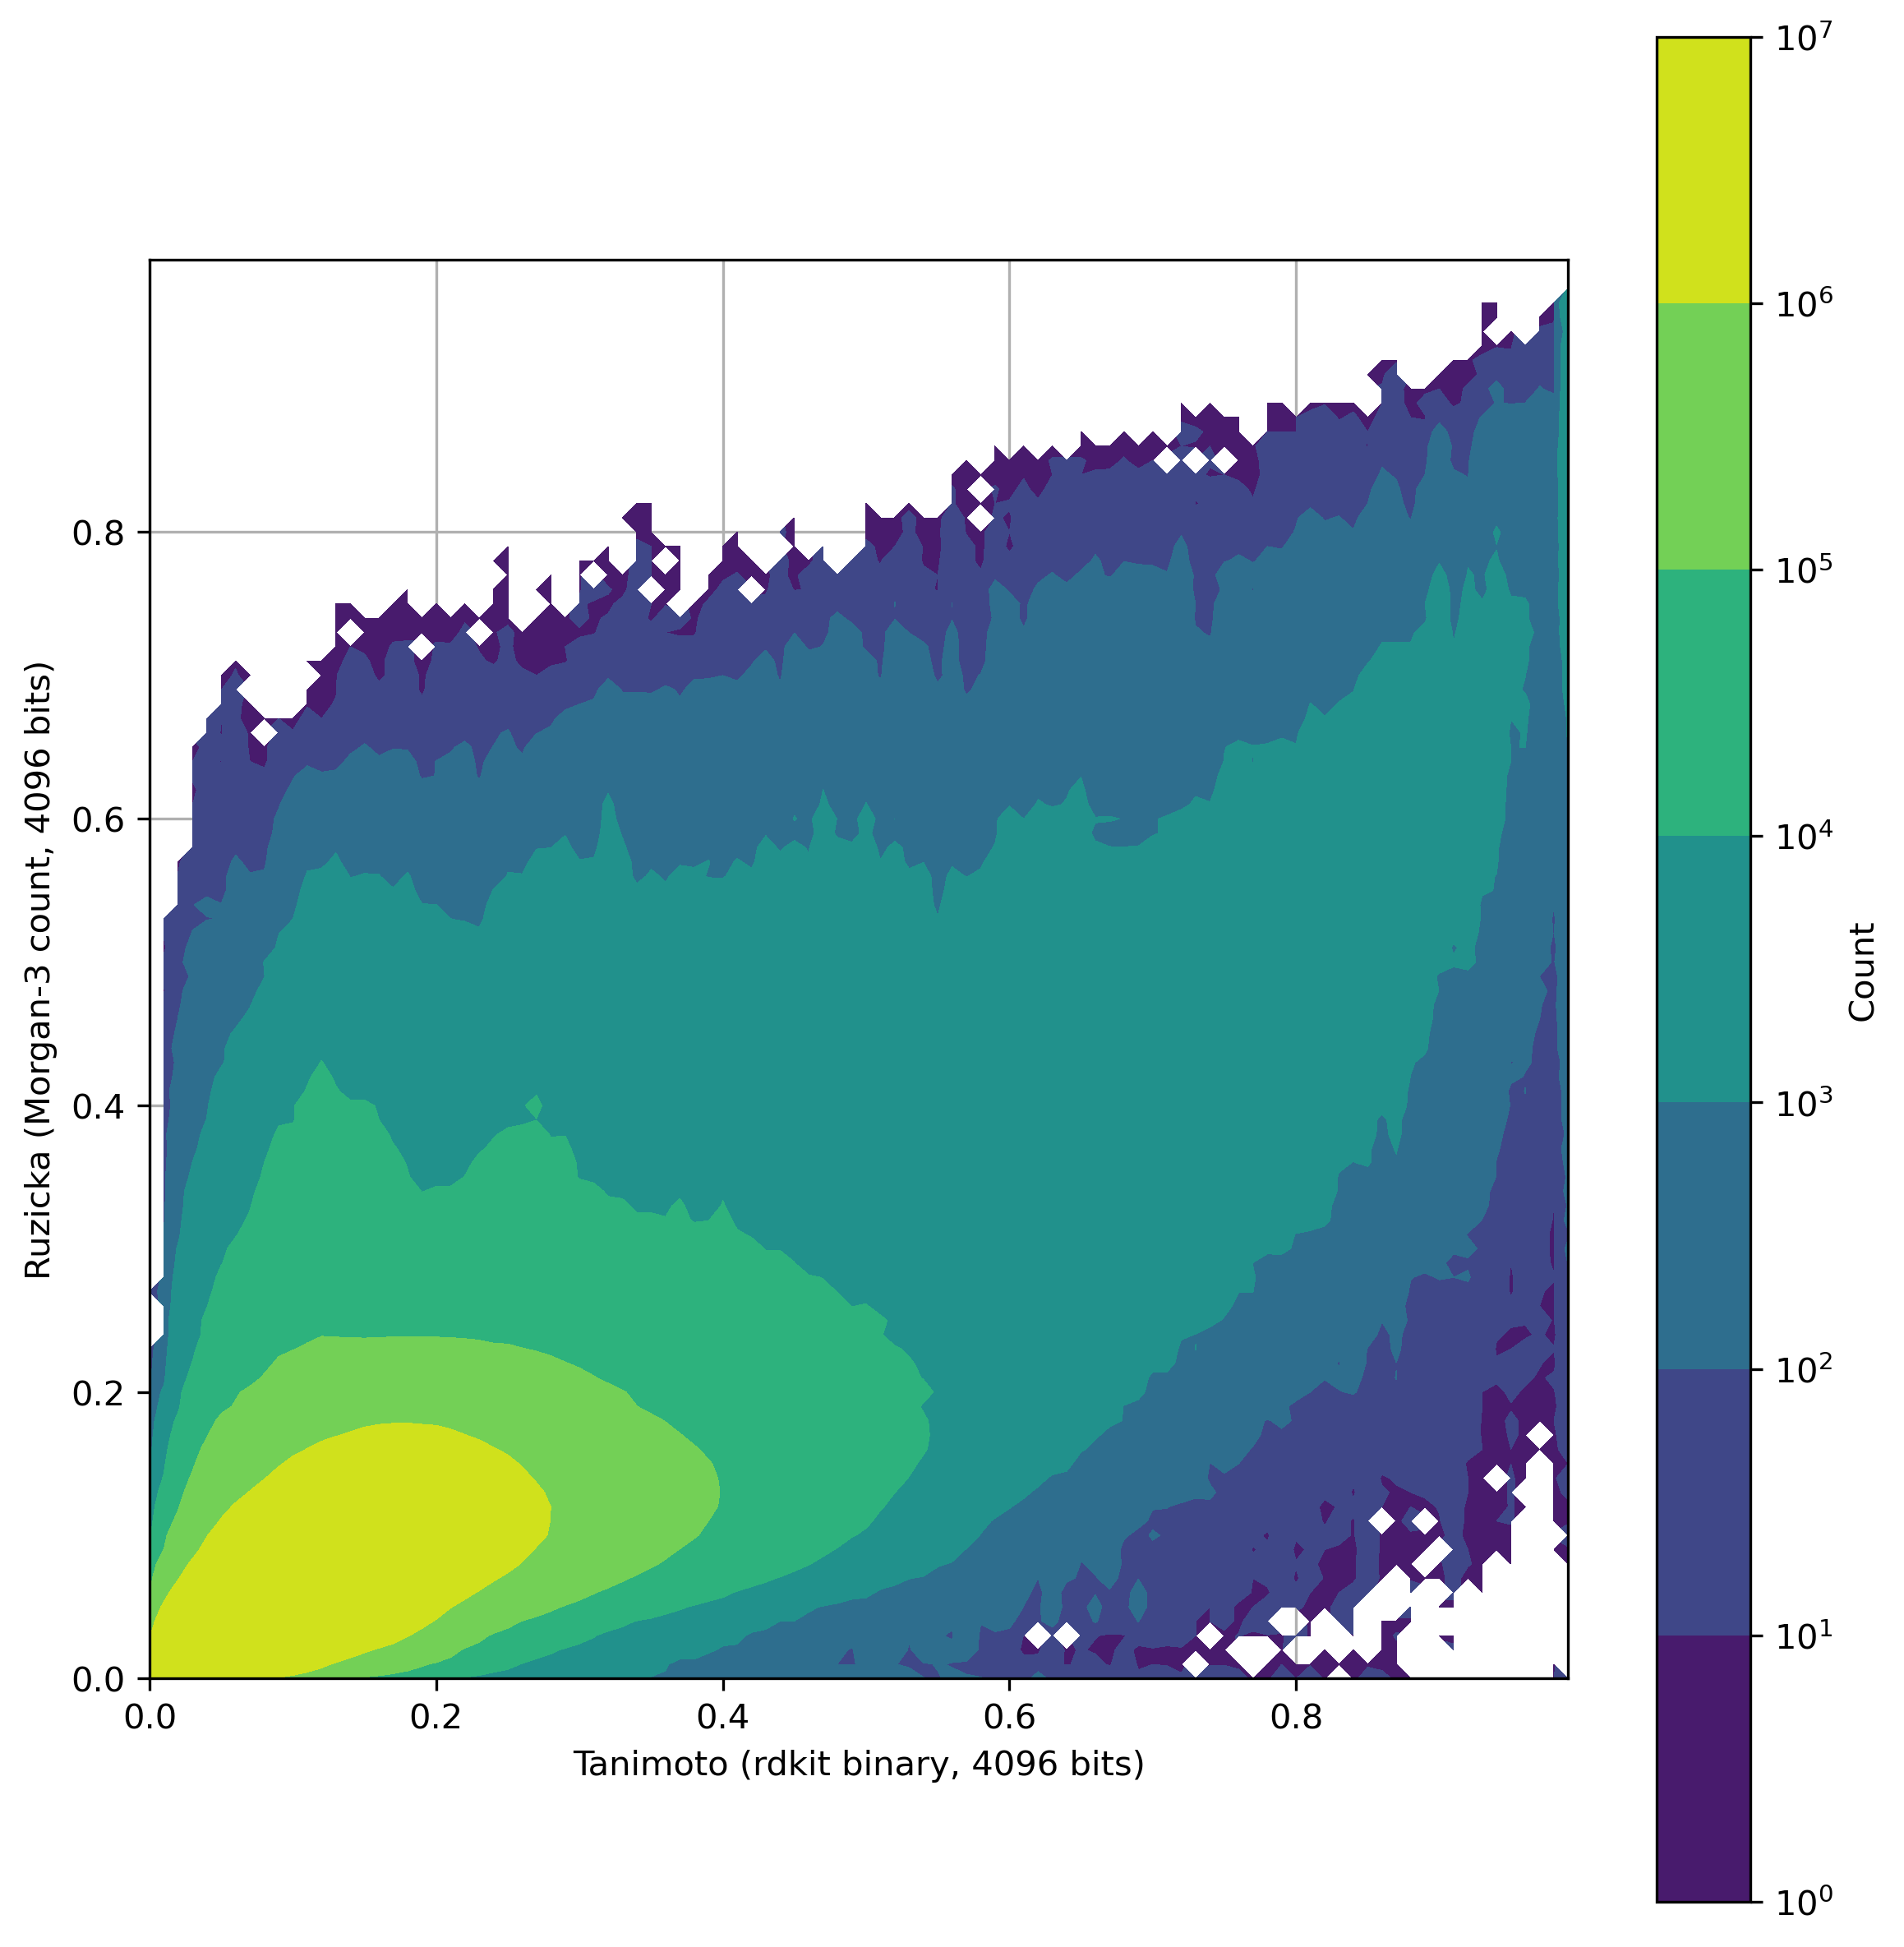

In [12]:
contour_comparison(
    similarities_classic,
    similarities_morgan3_count,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    filename="contourplot_tanimoto_rdkit_vs_ruzicka_morgan3.png"
)

In [ ]:
hex_comparison(
    similarities_classic,
    similarities_morgan3_count,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    filename="hexplot_tanimoto_rdkit_vs_ruzicka_morgan3.png"
)

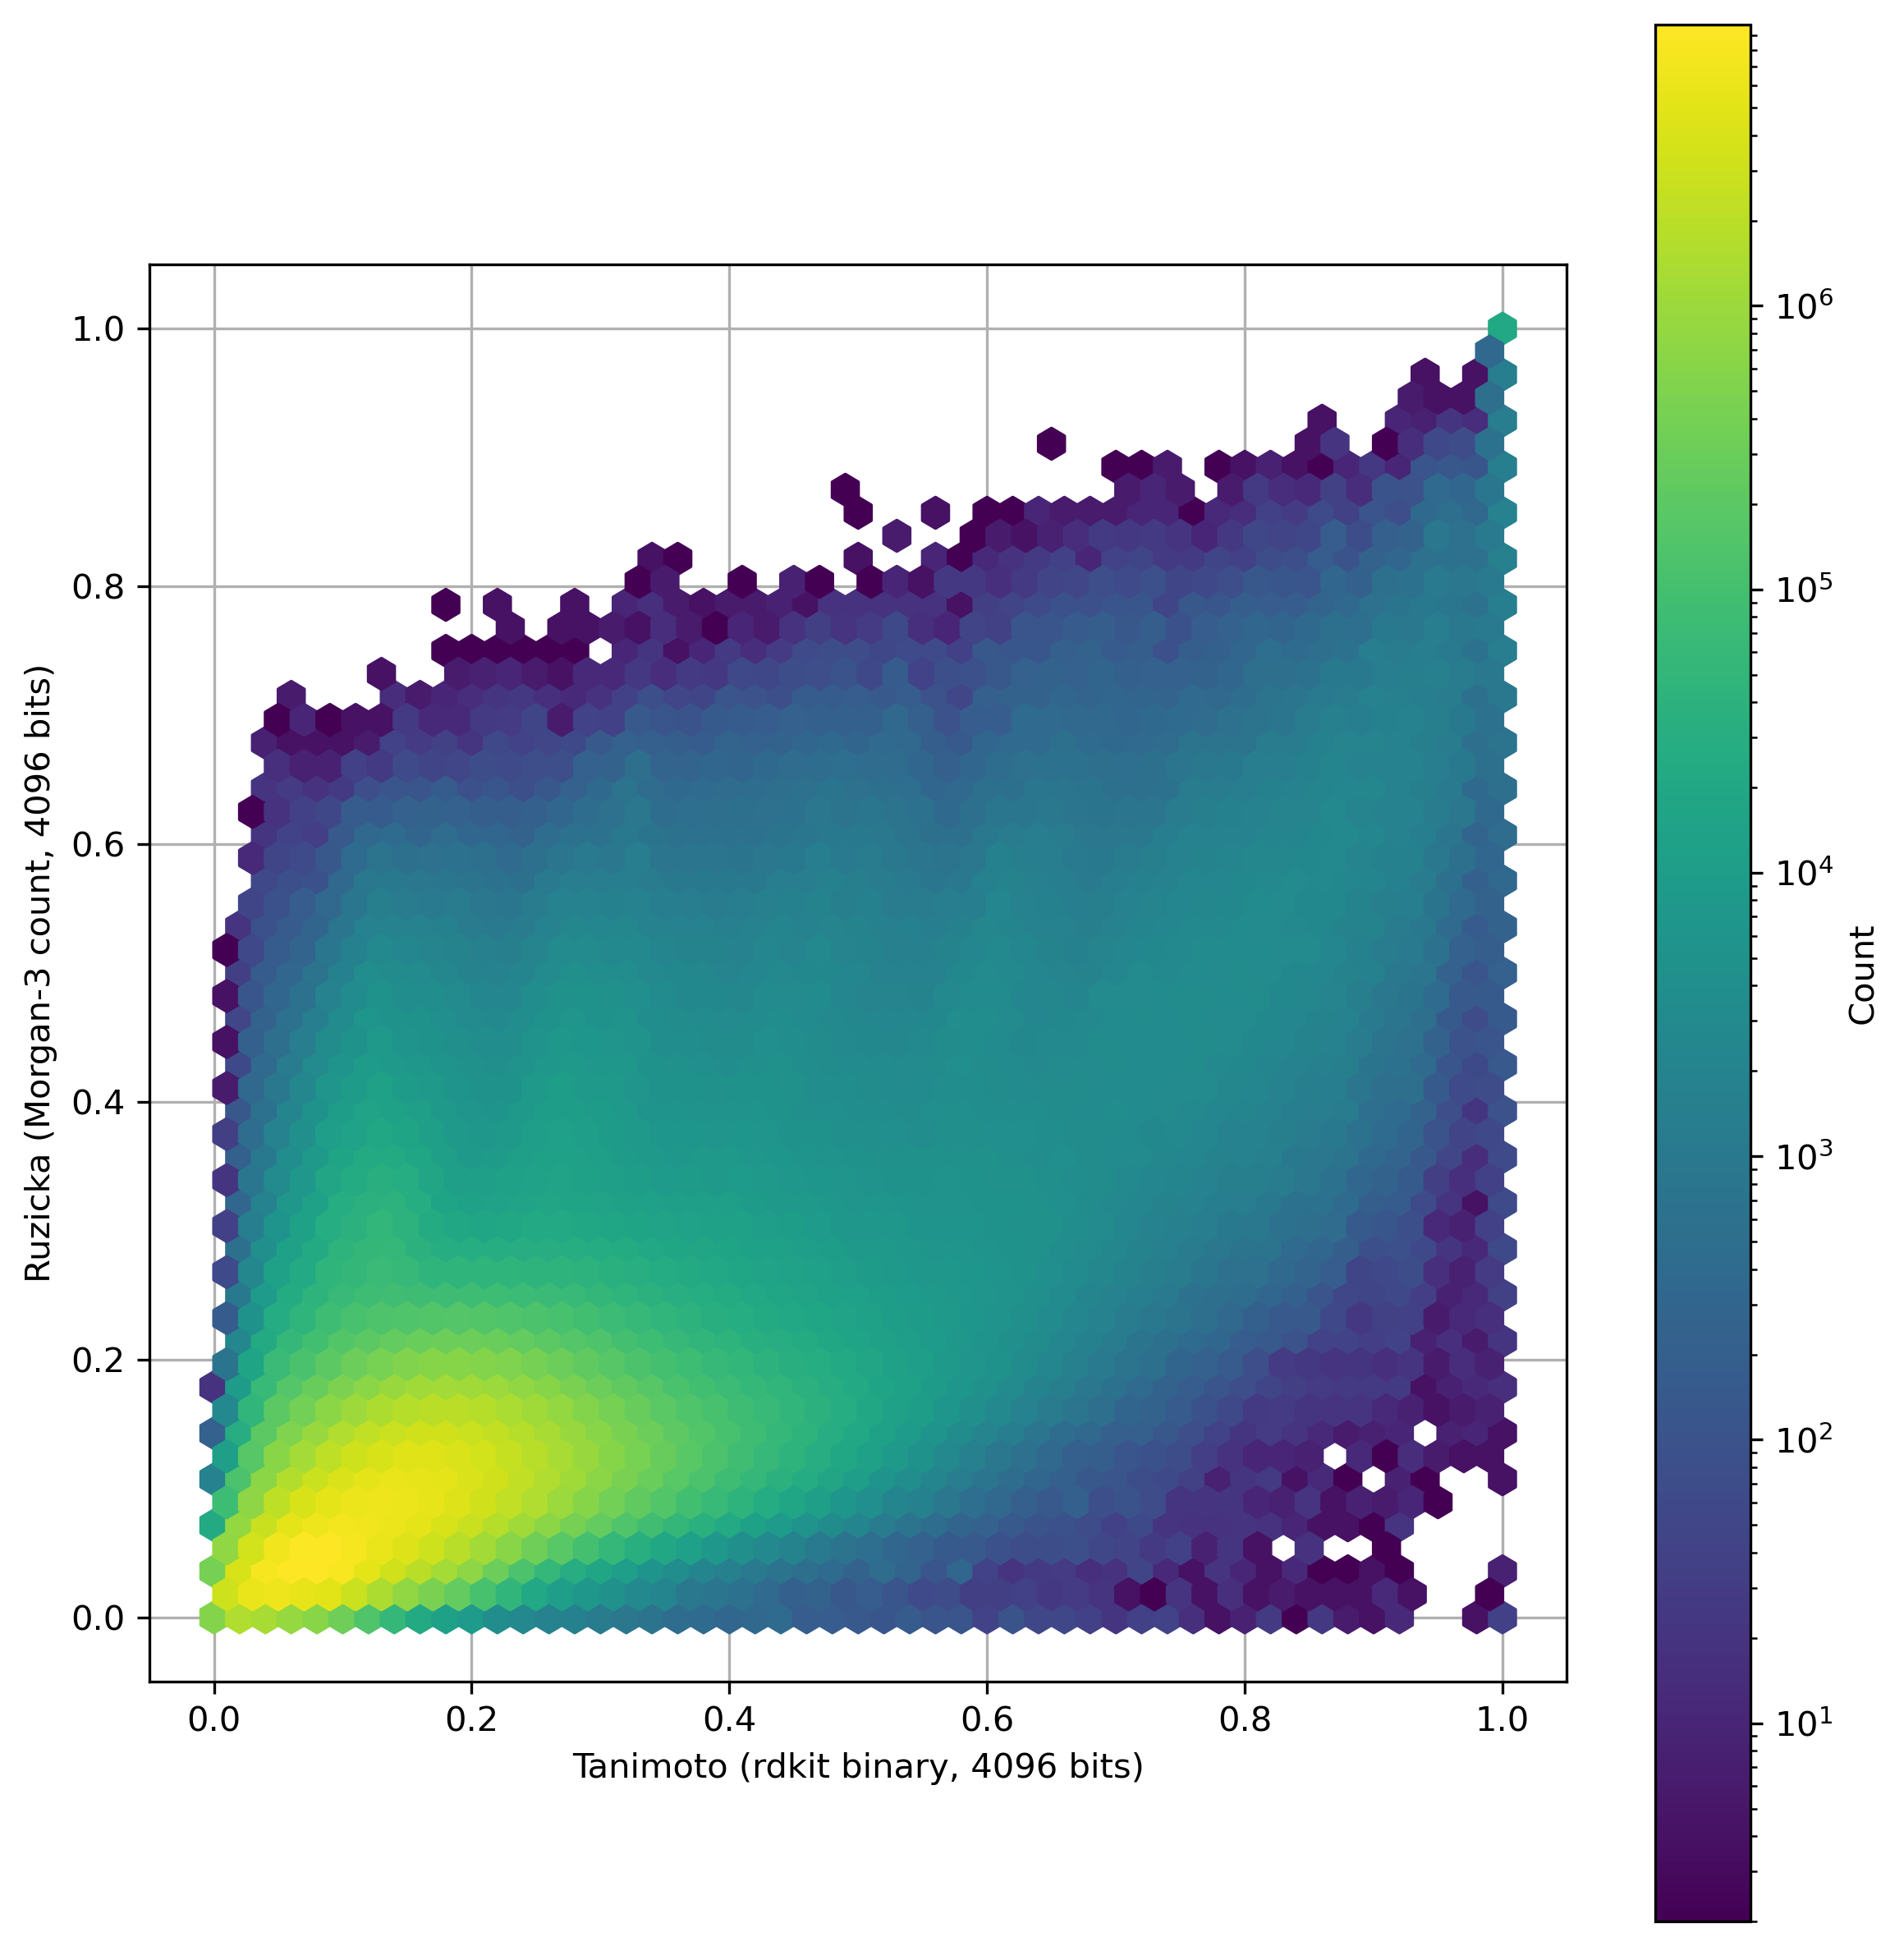

In [33]:
hex_comparison(
    similarities_classic[:20000, :20000],
    similarities_morgan3_count[:20000, :20000],
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    filename="hexplot_tanimoto_rdkit_vs_ruzicka_morgan3.png"
)

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def contour_comparison(similarities1, similarities2, label1, label2, filename=None, gridsize=50, batch_size=1e8):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    
    # Define bin edges for the 2D histogram
    xedges = np.linspace(np.min(similarities1), np.max(similarities1), gridsize + 1)
    yedges = np.linspace(np.min(similarities2), np.max(similarities2), gridsize + 1)
    
    # Initialize combined histogram counts
    combined_hist = np.zeros((gridsize, gridsize))
    
    # Total number of elements in the arrays
    total_elements = similarities1.size
    
    # Loop over the data in batches
    for start in range(0, total_elements, int(batch_size)):
        end = min(start + int(batch_size), total_elements)
        
        # Select the batch (slice the array)
        batch_similarities1 = similarities1.flatten()[start:end]
        batch_similarities2 = similarities2.flatten()[start:end]
        
        # Compute the 2D histogram for the batch
        hist, _, _ = np.histogram2d(batch_similarities1, batch_similarities2, bins=[xedges, yedges])
        
        # Accumulate the histogram counts
        combined_hist += hist
    
    # Generate contour plot (using log scale for count values)
    contour = ax.contour(xedges[:-1], yedges[:-1], combined_hist.T, levels=100, cmap='viridis', norm=LogNorm(), zorder=2)
    
    # Add the grid
    ax.grid(True, zorder=1)
    
    # Add colorbar
    cb = fig.colorbar(contour, ax=ax)
    cb.set_label('Count')
    
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    ax.set_aspect('equal', 'box')
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()


/tmp/ipykernel_129914/3810334956.py:33: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contour(xedges[:-1], yedges[:-1], combined_hist.T, levels=100, cmap='viridis', norm=LogNorm(), zorder=2)


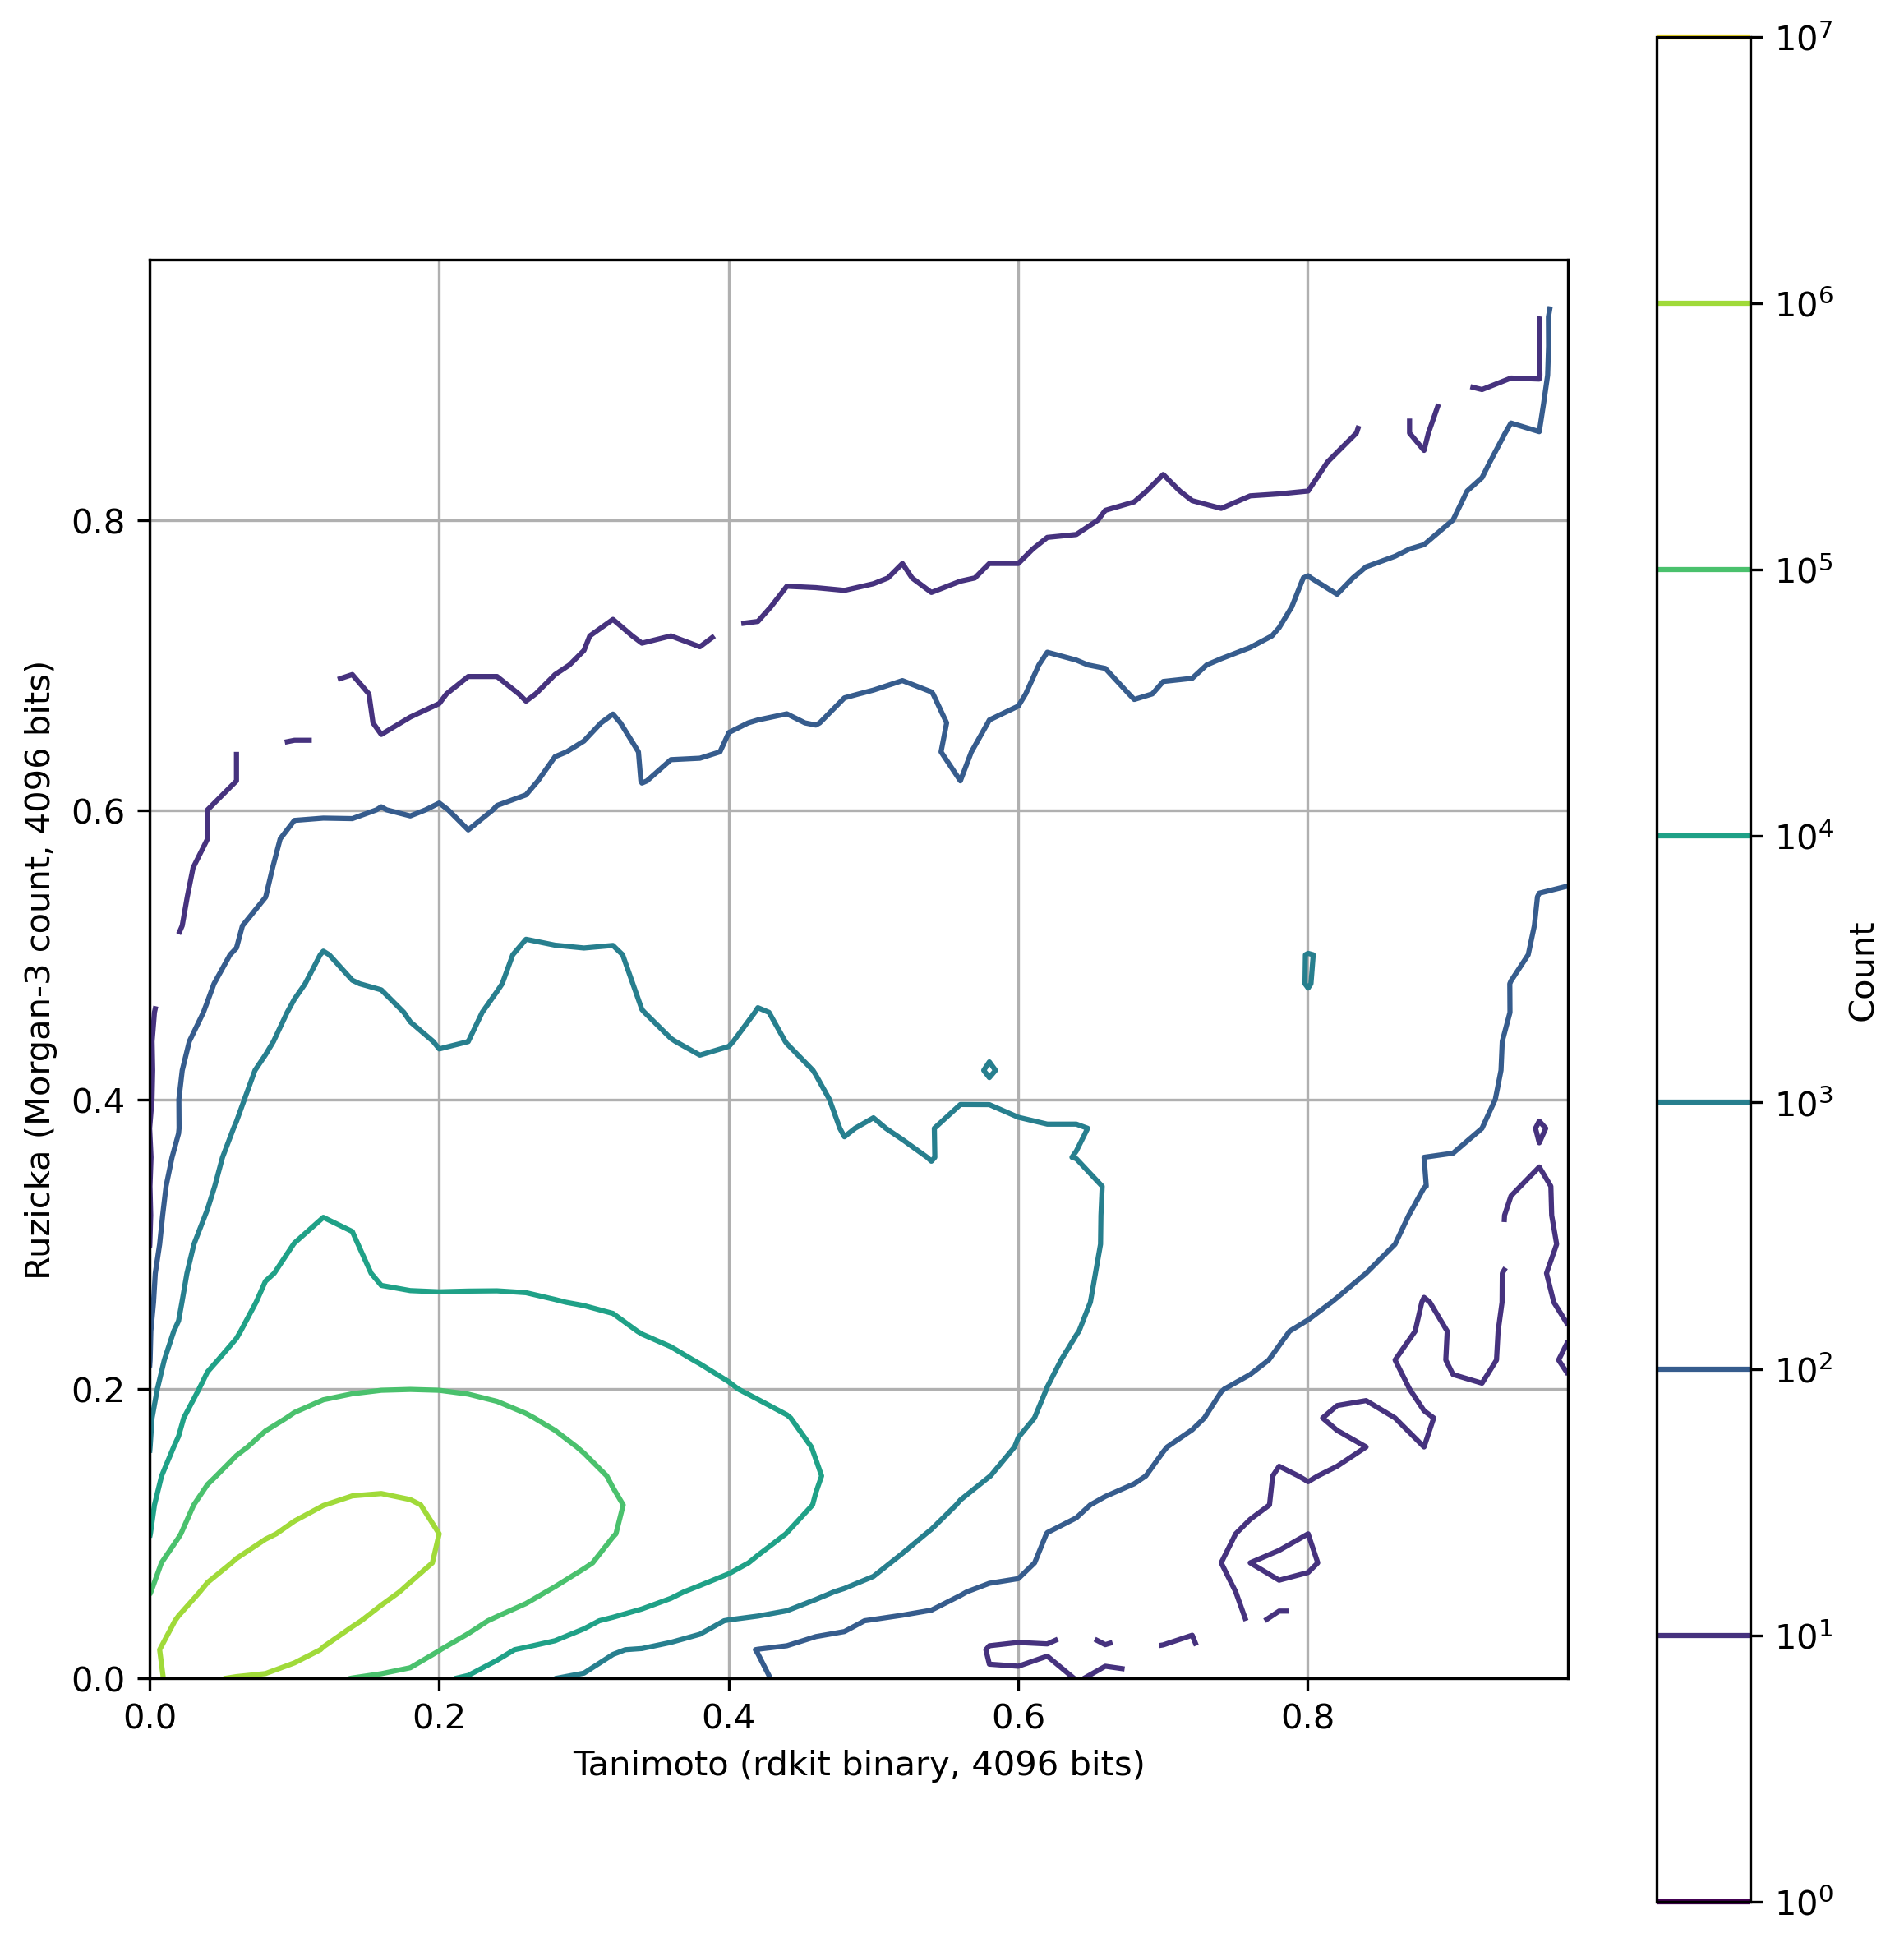

In [52]:
contour_comparison(
    similarities_classic[:10000, :10000],
    similarities_morgan3_count[:10000, :10000],
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    #filename="hexplot_tanimoto_rdkit_vs_ruzicka_morgan3.png"
)

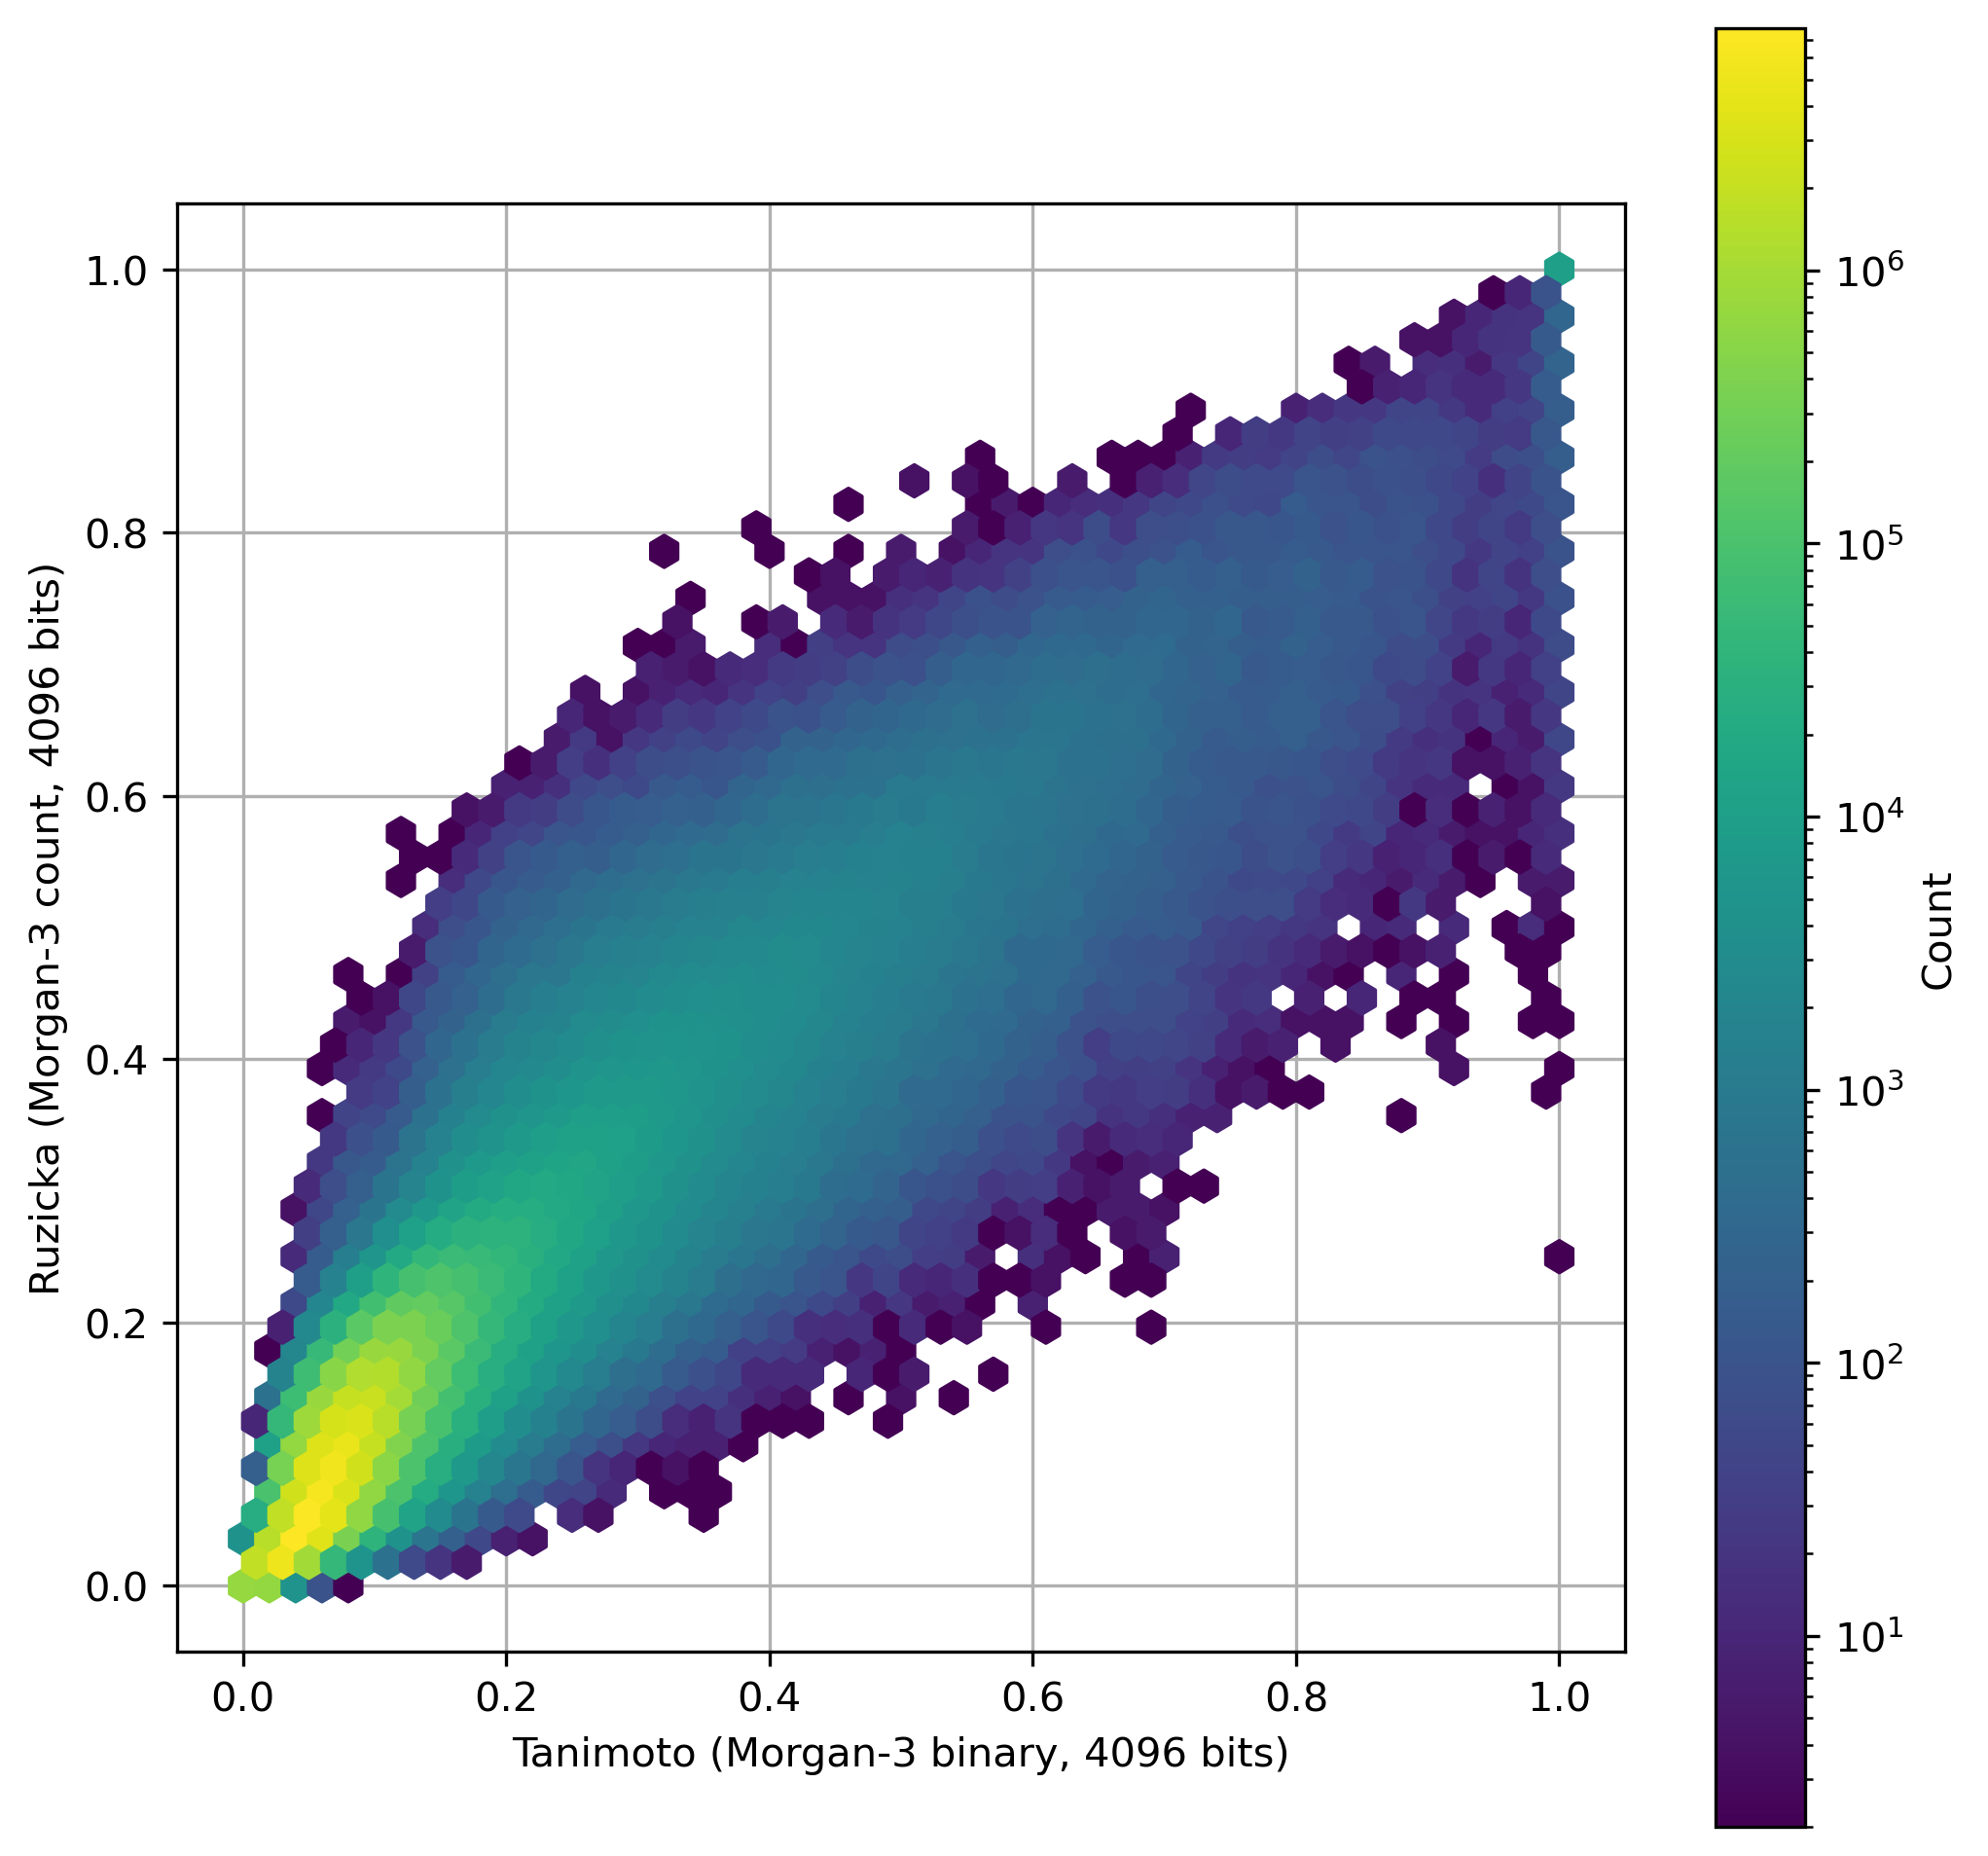

In [33]:
hex_comparison(
    similarities_morgan3[:10000, :10000],
    similarities_morgan3_count[:10000, :10000],
    f"Tanimoto (Morgan-3 binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

NBITS = 4096

def hex_comparison(similarities1, similarities2, label1, label2, batch_size=1e6, gridsize=50):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    
    # Create the bin edges for x and y based on the specified gridsize
    xedges = np.linspace(np.min(similarities1), np.max(similarities1), gridsize + 1)
    yedges = np.linspace(np.min(similarities2), np.max(similarities2), gridsize + 1)
    
    # Initialize the combined bin count
    combined_counts = np.zeros((gridsize, gridsize))
    
    # Total number of elements in the arrays
    total_elements = similarities1.size
    
    # Loop over the data in batches
    for start in range(0, total_elements, int(batch_size)):
        end = min(start + int(batch_size), total_elements)
        
        # Select the batch (slice the array)
        batch_similarities1 = similarities1.flatten()[start:end]
        batch_similarities2 = similarities2.flatten()[start:end]
        
        # Compute the 2D histogram for the current batch
        hist, _, _ = np.histogram2d(batch_similarities1, batch_similarities2, bins=[xedges, yedges])
        
        # Accumulate the counts in the combined histogram
        combined_counts += hist
    
    # Generate the hexbin plot using the combined counts
    hb = ax.hexbin(xedges[:-1], yedges[:-1], C=combined_counts.flatten(), gridsize=gridsize,
                   cmap='viridis', norm=LogNorm(), mincnt=1, zorder=2)
    
    # Add the grid
    ax.grid(True, zorder=1)
    
    # Add colorbar
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('Count')
    
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    ax.set_aspect('equal', 'box')
    
    plt.show()



In [ ]:
hex_comparison(
    similarities_classic,
    similarities_morgan3_count,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
)

In [26]:
hex_comparison(
    similarities_classic,
    similarities_count_morgan6_log,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Ruzicka (Morgan-6 log count, {NBITS} bits)",
)

NameError: name 'similarities_count_morgan6_log' is not defined

In [104]:
def get_score_summary(id1, id2):
    scores = {
        "Tanimoto (binary fp)": similarities_classic[id1, id2],
        #"Weigthed Tanimoto (binary fp)": similarities_binary_weighted[id1, id2],
        "Ruzicka (Morgan-3 count fp)": similarities_count_morgan3[id1, id2],
        "Ruzicka (Morgan-6 count fp)": similarities_count_morgan6[id1, id2],
        "Ruzicka (Morgan-6 log-count fp)": similarities_count_morgan6_log[id1, id2],
        #"Weighted Ruzicka (count fp)": similarities_count_weighted[id1, id2],
        #"Weighted Ruzicka (log-count fp)": similarities_count_log_weighted[id1, id2],
        #"(Ruzicka (log-tfidf count fp)": similarities_tfidf_log[id1, id2],
    }
    scores = pd.DataFrame.from_dict(scores, orient='index', columns=["Score"])
    return scores

In [105]:
idx = np.where((similarities_count > 0.9) \
               & (similarities_count_morgan6 < 0.7))
idx

(array([  54,  537,  611, 1412, 2614, 2786, 2853, 2917, 3297, 3332, 3708,
        3714, 3714, 4112, 5012, 5493, 5657, 5919, 5919, 6023, 6621, 6785,
        6794, 6821, 6945, 6945, 7090, 7561, 7729, 7929, 8047, 8293, 8456,
        9103, 9620, 9991]),
 array([5493, 6945, 1412,  611, 4112, 8456, 8047, 9991, 3708, 7090, 3297,
        5919, 8293, 2614, 7729,   54, 7561, 3714, 6945, 9103, 6785, 6621,
        7929, 9620,  537, 5919, 3332, 5657, 5012, 6794, 2853, 3714, 2786,
        6023, 6821, 2917]))

In [106]:
pairs = list(zip(idx[0], idx[1]))
unique_pairs = set()
for pair in pairs:
    sorted_pair = tuple(sorted(pair))
    unique_pairs.add(sorted_pair)
unique_pairs = list(unique_pairs)
unique_pairs

[(np.int64(3714), np.int64(8293)),
 (np.int64(2786), np.int64(8456)),
 (np.int64(611), np.int64(1412)),
 (np.int64(5012), np.int64(7729)),
 (np.int64(54), np.int64(5493)),
 (np.int64(3297), np.int64(3708)),
 (np.int64(5657), np.int64(7561)),
 (np.int64(2614), np.int64(4112)),
 (np.int64(3714), np.int64(5919)),
 (np.int64(2853), np.int64(8047)),
 (np.int64(537), np.int64(6945)),
 (np.int64(2917), np.int64(9991)),
 (np.int64(6023), np.int64(9103)),
 (np.int64(5919), np.int64(6945)),
 (np.int64(6621), np.int64(6785)),
 (np.int64(6794), np.int64(7929)),
 (np.int64(6821), np.int64(9620)),
 (np.int64(3332), np.int64(7090))]

Score
Tanimoto (binary fp)             0.975904
Ruzicka (Morgan-3 count fp)      0.937008
Ruzicka (Morgan-6 count fp)      0.690909
Ruzicka (Morgan-6 log-count fp)  0.622285

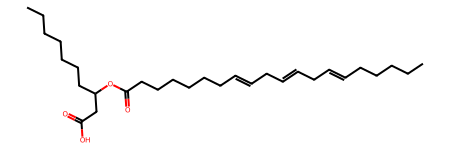

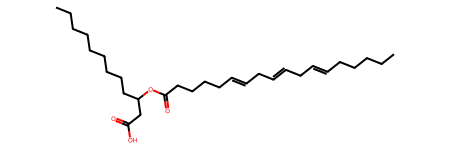

Score
Tanimoto (binary fp)             1.000000
Ruzicka (Morgan-3 count fp)      0.917808
Ruzicka (Morgan-6 count fp)      0.663934
Ruzicka (Morgan-6 log-count fp)  0.621252

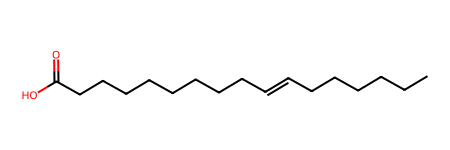

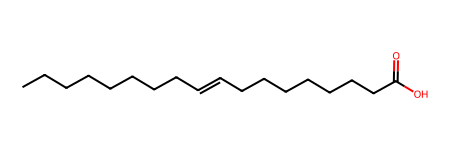

Score
Tanimoto (binary fp)             1.000000
Ruzicka (Morgan-3 count fp)      0.920792
Ruzicka (Morgan-6 count fp)      0.682635
Ruzicka (Morgan-6 log-count fp)  0.637080

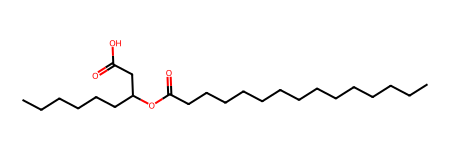

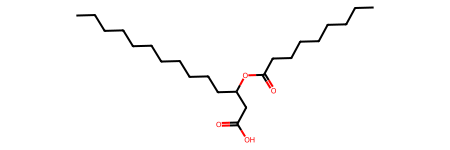

Score
Tanimoto (binary fp)             1.000000
Ruzicka (Morgan-3 count fp)      0.905660
Ruzicka (Morgan-6 count fp)      0.685714
Ruzicka (Morgan-6 log-count fp)  0.627691

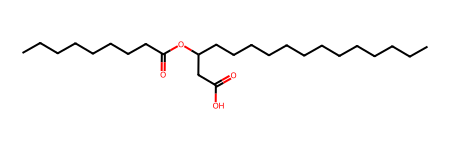

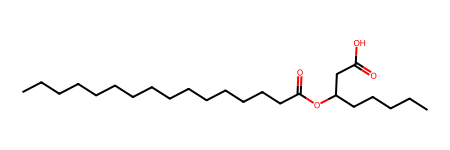

Score
Tanimoto (binary fp)             1.000000
Ruzicka (Morgan-3 count fp)      0.901235
Ruzicka (Morgan-6 count fp)      0.617647
Ruzicka (Morgan-6 log-count fp)  0.571007

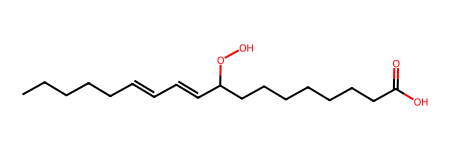

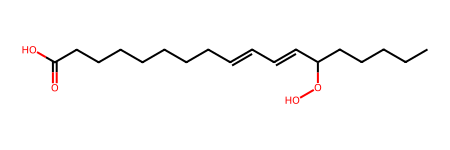

Score
Tanimoto (binary fp)             1.000000
Ruzicka (Morgan-3 count fp)      0.905882
Ruzicka (Morgan-6 count fp)      0.625000
Ruzicka (Morgan-6 log-count fp)  0.580816

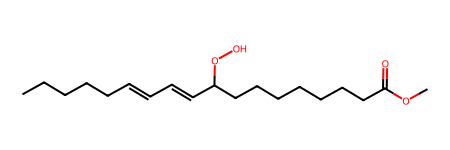

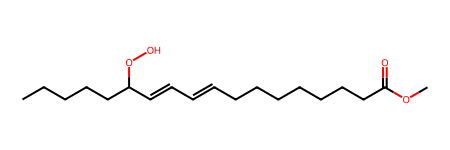

Score
Tanimoto (binary fp)             1.000000
Ruzicka (Morgan-3 count fp)      0.915789
Ruzicka (Morgan-6 count fp)      0.645570
Ruzicka (Morgan-6 log-count fp)  0.576056

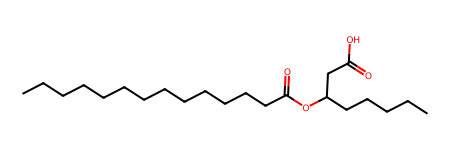

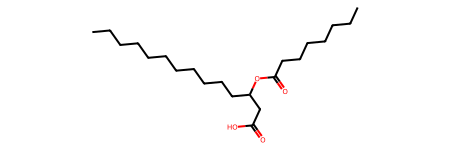

Score
Tanimoto (binary fp)             1.000000
Ruzicka (Morgan-3 count fp)      0.906977
Ruzicka (Morgan-6 count fp)      0.668966
Ruzicka (Morgan-6 log-count fp)  0.628604

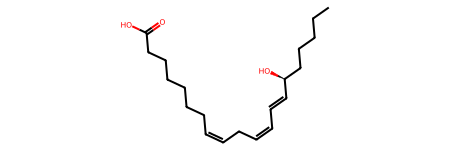

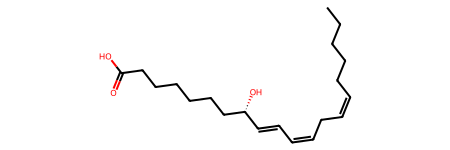

Score
Tanimoto (binary fp)             0.975904
Ruzicka (Morgan-3 count fp)      0.920635
Ruzicka (Morgan-6 count fp)      0.689815
Ruzicka (Morgan-6 log-count fp)  0.632140

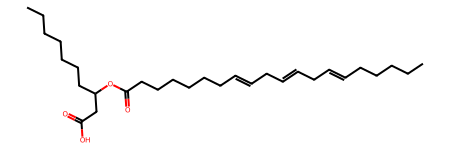

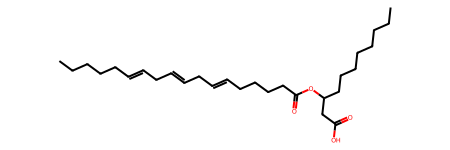

Score
Tanimoto (binary fp)             0.938824
Ruzicka (Morgan-3 count fp)      0.917431
Ruzicka (Morgan-6 count fp)      0.636816
Ruzicka (Morgan-6 log-count fp)  0.550062

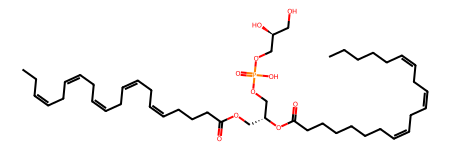

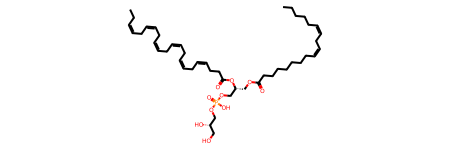

Score
Tanimoto (binary fp)             0.975904
Ruzicka (Morgan-3 count fp)      0.902439
Ruzicka (Morgan-6 count fp)      0.671429
Ruzicka (Morgan-6 log-count fp)  0.611920

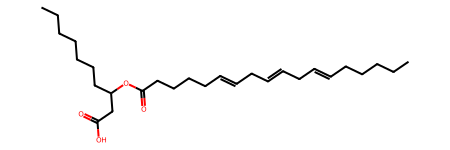

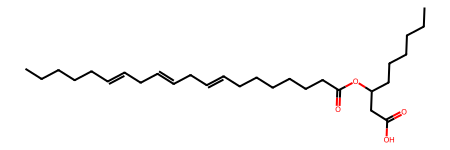

Score
Tanimoto (binary fp)             1.000000
Ruzicka (Morgan-3 count fp)      0.909091
Ruzicka (Morgan-6 count fp)      0.673333
Ruzicka (Morgan-6 log-count fp)  0.614753

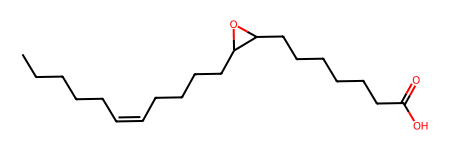

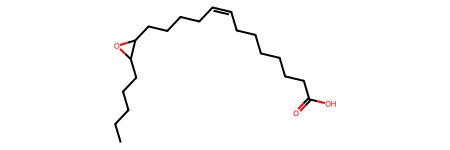

Score
Tanimoto (binary fp)             0.991736
Ruzicka (Morgan-3 count fp)      0.937500
Ruzicka (Morgan-6 count fp)      0.697436
Ruzicka (Morgan-6 log-count fp)  0.652863

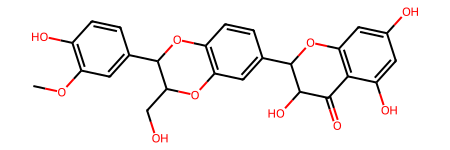

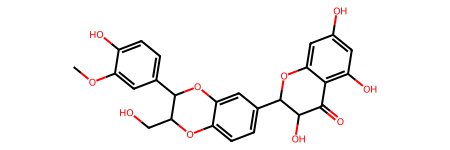

Score
Tanimoto (binary fp)             0.975904
Ruzicka (Morgan-3 count fp)      0.919355
Ruzicka (Morgan-6 count fp)      0.672897
Ruzicka (Morgan-6 log-count fp)  0.601483

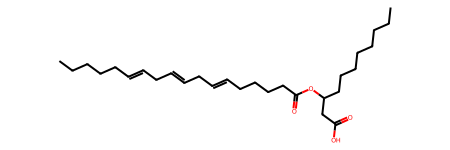

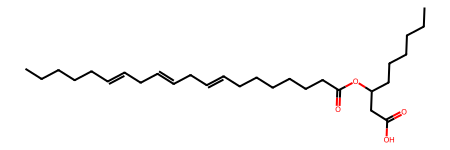

Score
Tanimoto (binary fp)             1.000000
Ruzicka (Morgan-3 count fp)      0.913978
Ruzicka (Morgan-6 count fp)      0.689655
Ruzicka (Morgan-6 log-count fp)  0.645364

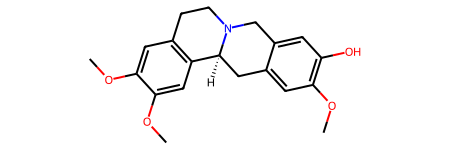

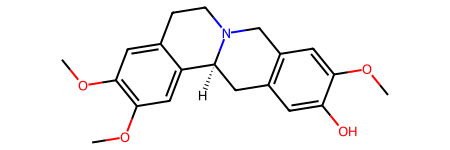

Score
Tanimoto (binary fp)             0.979522
Ruzicka (Morgan-3 count fp)      0.946903
Ruzicka (Morgan-6 count fp)      0.682382
Ruzicka (Morgan-6 log-count fp)  0.616067

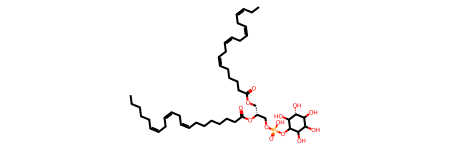

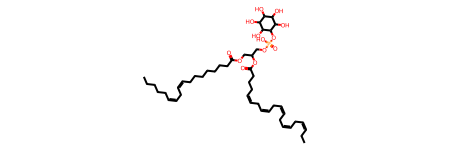

Score
Tanimoto (binary fp)             1.000000
Ruzicka (Morgan-3 count fp)      0.942446
Ruzicka (Morgan-6 count fp)      0.693780
Ruzicka (Morgan-6 log-count fp)  0.633877

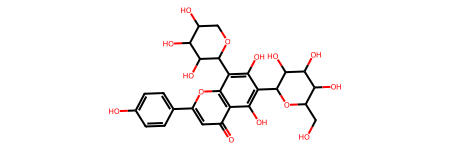

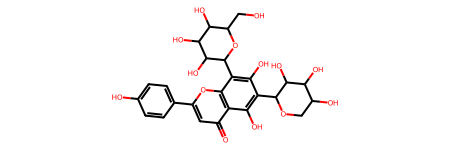

Score
Tanimoto (binary fp)             0.982558
Ruzicka (Morgan-3 count fp)      0.917526
Ruzicka (Morgan-6 count fp)      0.662651
Ruzicka (Morgan-6 log-count fp)  0.615297

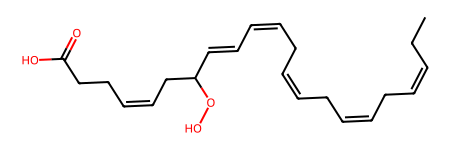

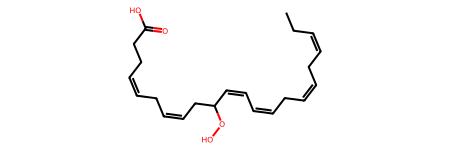

In [107]:
from rdkit import Chem
from rdkit.Chem import Draw


for pair in unique_pairs:
    display(get_score_summary(pair[0], pair[1]))

    smiles1 = compounds.smiles[indices_selected[pair[0]]]
    smiles2 = compounds.smiles[indices_selected[pair[1]]]
    mol = Chem.MolFromSmiles(smiles1)
    display(mol)
    mol = Chem.MolFromSmiles(smiles2)
    display(mol)

In [108]:
idx = np.where((similarities_count_morgan3 > 0.95) \
               & (similarities_count_morgan6_log < 0.7))
idx

(array([5420, 7474, 7561, 8030, 8194, 8682]),
 array([8682, 8030, 8194, 7474, 7561, 5420]))

In [109]:
pairs = list(zip(idx[0], idx[1]))
unique_pairs = set()
for pair in pairs:
    sorted_pair = tuple(sorted(pair))
    unique_pairs.add(sorted_pair)
unique_pairs = list(unique_pairs)
unique_pairs

[(np.int64(7474), np.int64(8030)),
 (np.int64(7561), np.int64(8194)),
 (np.int64(5420), np.int64(8682))]

Score
Tanimoto (binary fp)             1.000000
Ruzicka (Morgan-3 count fp)      0.963470
Ruzicka (Morgan-6 count fp)      0.793103
Ruzicka (Morgan-6 log-count fp)  0.695763

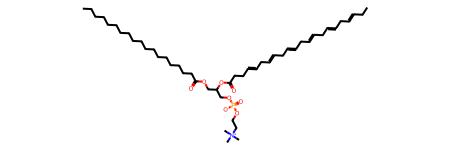

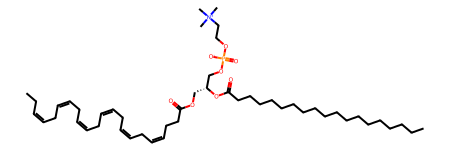

Score
Tanimoto (binary fp)             1.000000
Ruzicka (Morgan-3 count fp)      1.000000
Ruzicka (Morgan-6 count fp)      0.756757
Ruzicka (Morgan-6 log-count fp)  0.689111

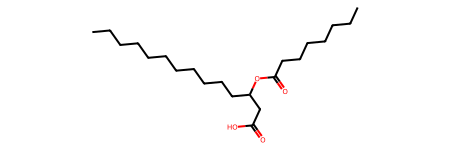

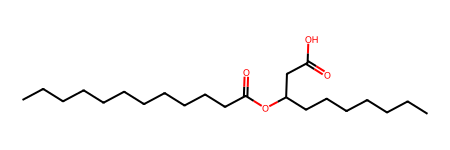

Score
Tanimoto (binary fp)             1.000000
Ruzicka (Morgan-3 count fp)      0.970803
Ruzicka (Morgan-6 count fp)      0.710744
Ruzicka (Morgan-6 log-count fp)  0.620972

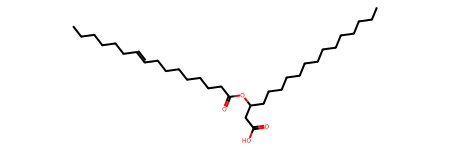

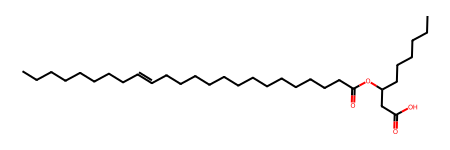

In [110]:
from rdkit import Chem
from rdkit.Chem import Draw


for pair in unique_pairs:
    display(get_score_summary(pair[0], pair[1]))

    smiles1 = compounds.smiles[indices_selected[pair[0]]]
    smiles2 = compounds.smiles[indices_selected[pair[1]]]
    mol = Chem.MolFromSmiles(smiles1)
    display(mol)
    mol = Chem.MolFromSmiles(smiles2)
    display(mol)

In [111]:
idx = np.where((similarities_count_morgan3 > 0.6) \
               & (similarities_count_morgan6_log < 0.25))
idx

(array([1499, 2224, 5012, 5378, 6138, 7186, 7186, 7620, 7620, 7951, 7985,
        9429]),
 array([9429, 7951, 7186, 7620, 7620, 5012, 7985, 5378, 6138, 2224, 7186,
        1499]))

In [112]:
pairs = list(zip(idx[0], idx[1]))
unique_pairs = set()
for pair in pairs:
    sorted_pair = tuple(sorted(pair))
    unique_pairs.add(sorted_pair)
unique_pairs = list(unique_pairs)
unique_pairs

[(np.int64(7186), np.int64(7985)),
 (np.int64(5012), np.int64(7186)),
 (np.int64(2224), np.int64(7951)),
 (np.int64(1499), np.int64(9429)),
 (np.int64(5378), np.int64(7620)),
 (np.int64(6138), np.int64(7620))]

Score
Tanimoto (binary fp)             0.488038
Ruzicka (Morgan-3 count fp)      0.608000
Ruzicka (Morgan-6 count fp)      0.369863
Ruzicka (Morgan-6 log-count fp)  0.245362

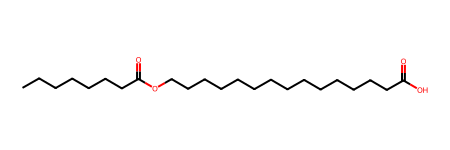

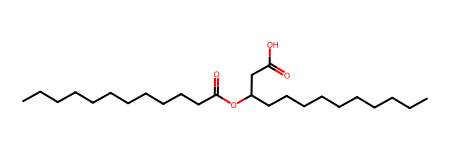

Score
Tanimoto (binary fp)             0.488038
Ruzicka (Morgan-3 count fp)      0.608000
Ruzicka (Morgan-6 count fp)      0.376147
Ruzicka (Morgan-6 log-count fp)  0.245052

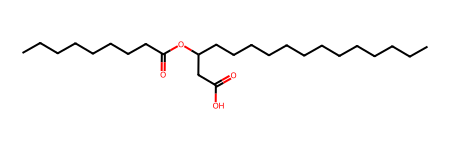

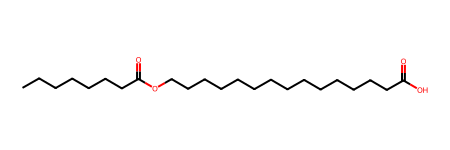

Score
Tanimoto (binary fp)             0.214751
Ruzicka (Morgan-3 count fp)      0.601852
Ruzicka (Morgan-6 count fp)      0.388325
Ruzicka (Morgan-6 log-count fp)  0.247969

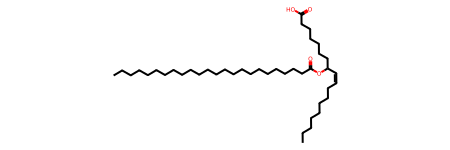

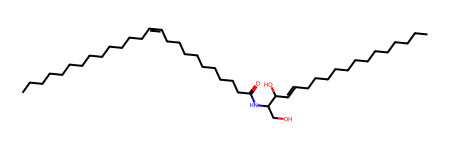

Score
Tanimoto (binary fp)             0.134078
Ruzicka (Morgan-3 count fp)      0.622549
Ruzicka (Morgan-6 count fp)      0.511429
Ruzicka (Morgan-6 log-count fp)  0.241245

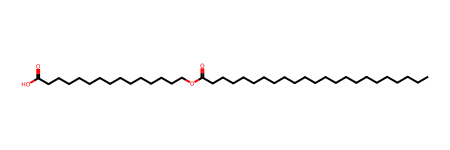

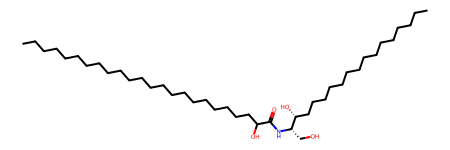

Score
Tanimoto (binary fp)             0.439655
Ruzicka (Morgan-3 count fp)      0.605405
Ruzicka (Morgan-6 count fp)      0.405405
Ruzicka (Morgan-6 log-count fp)  0.245951

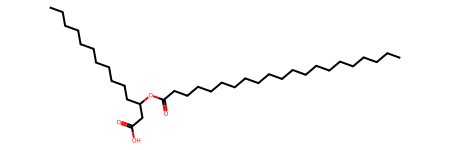

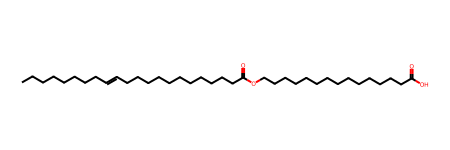

Score
Tanimoto (binary fp)             0.409449
Ruzicka (Morgan-3 count fp)      0.601064
Ruzicka (Morgan-6 count fp)      0.401760
Ruzicka (Morgan-6 log-count fp)  0.247579

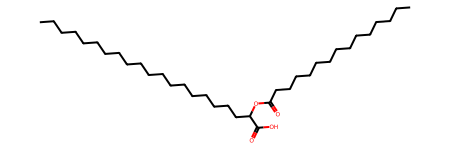

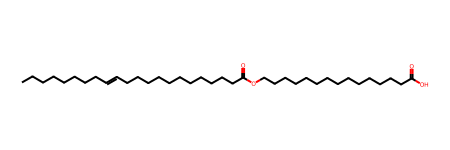

In [113]:
for pair in unique_pairs:
    display(get_score_summary(pair[0], pair[1]))

    smiles1 = compounds.smiles[indices_selected[pair[0]]]
    smiles2 = compounds.smiles[indices_selected[pair[1]]]
    mol = Chem.MolFromSmiles(smiles1)
    display(mol)
    mol = Chem.MolFromSmiles(smiles2)
    display(mol)

## First quick check for bit collisions
- simply use much longer vectors

In [23]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=16392)

fp_generator = FingerprintGenerator(fpgen)
count = True

fingerprints = []
for inchikey, row in tqdm(compounds.iterrows(), total=len(compounds)):
    fp = fp_generator.fingerprint_from_smiles(row.smiles, count)
    if fp is None:
        print(f"Missing fingerprint for {inchikey}: {row.smiles}")
    else:
        fingerprints.append(fp)

fingerprints_16392 = np.vstack(fingerprints)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [24]:
#fingerprints_selected = fingerprints_16392[indices_selected]
#fingerprints_selected.shape

(37663, 16392)

In [25]:
%%time

#similarities_count_morgan3_16392 = compute_ruzicka_similarities(fingerprints_selected)

CPU times: user 6h 17min 38s, sys: 7.87 s, total: 6h 17min 46s
Wall time: 12min 54s


In [26]:
np.abs(similarities_count_morgan3_16392 - similarities_count_morgan3).max()

NameError: name 'similarities_count_morgan3' is not defined

In [ ]:
plt.hist(np.abs(similarities_count_morgan3_16392 - similarities_count_morgan3).reshape(-1), bins=50)

In [ ]:
idx = np.where(np.abs(similarities_count_morgan3_16392 - similarities_count_morgan3) > 0.1)
idx

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw


for i in range(len(idx[0])):
    m = idx[0][i]
    n = idx[1][i]
    smiles1 = compounds.smiles[indices_selected[m]]
    smiles2 = compounds.smiles[indices_selected[n]]
    print(similarities_count_morgan3_16392[m, n], similarities_count_morgan3[m, n]) 
    mol = Chem.MolFromSmiles(smiles1)
    display(mol)
    mol = Chem.MolFromSmiles(smiles2)
    display(mol)